In [49]:
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import scipy
import matplotlib
import tqdm
from scipy import integrate, fft, sparse
import pandas as pd
import seaborn as sns
import random
import anndata
import os
from sklearn.metrics import confusion_matrix
import loompy as lp

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import kneighbors_graph

import igraph as ig
import leidenalg as la

from sklearn.metrics import adjusted_rand_score

**Set path to monod package**

In [50]:
import sys
import importlib
sys.path.insert(0, '/home/tchari/monod/src/')

In [51]:
import monod
#importlib.reload(monod)
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference

In [164]:
import warnings
warnings.filterwarnings('ignore', category=PendingDeprecationWarning) 

## **Define Functions for Simulations**

In [53]:
class BurstModel():
    """
    Given parameters for bursty transcription, splicing, deg generate P(U,S) for set of (U,S) counts
    """
    def __init__(self,seq_model='None',quad_method='fixed_quad',fixed_quad_T=10,quad_order=60,quad_vec_T=np.inf):
        self.seq_model = seq_model
        self.quad_method = quad_method
        self.fixed_quad_T = fixed_quad_T
        self.quad_order = quad_order
        self.quad_vec_T = quad_vec_T
        
    def burst_intfun(self, x, g, b, beta, gamma):
        if np.isclose(beta, gamma):
            c_1 = g[0]  
            c_2 = x * beta * g[1]
        else:
            f = beta / (beta - gamma)
            c_2 = g[1] * f
            c_1 = g[0] - c_2

        U = b * (np.exp(-beta * x) * c_1 + np.exp(-gamma * x) * c_2)
        return U / (1 - U)    
    
    def eval_model_pgf(self, p_, g):
        p = 10**p_
        b, beta, gamma = p

        
        fun = lambda x: self.burst_intfun(x, g, b, beta, gamma)
        if self.quad_method == "quad_vec":
            T = self.quad_vec_T * (1 / beta + 1 / gamma + 1)
            gf = scipy.integrate.quad_vec(fun, 0, T)[0]
        elif self.quad_method == "fixed_quad":
            T = self.fixed_quad_T * (1 / beta + 1 / gamma + 1)
            gf = scipy.integrate.fixed_quad(fun, 0, T, n=self.quad_order)[0]
        else:
            raise ValueError("Please use one of the specified quadrature methods.")
        return gf  # this is the log-generating function

    def get_Pss(self, p, limits, samp=None):
        u = []
        mx = np.copy(limits)
        mx[-1] = mx[-1] // 2 + 1
        for i in range(len(mx)):
            l = np.arange(mx[i])
            u_ = np.exp(-2j * np.pi * l / limits[i]) - 1
            u.append(u_)
        g = np.meshgrid(*[u_ for u_ in u], indexing="ij")
        for i in range(len(mx)):
            g[i] = g[i].flatten()
        g = np.asarray(g)[:, :, None]

        if self.seq_model == "Bernoulli":
            g *= np.asarray(samp)[:, None, None]
        elif self.seq_model == "Poisson":
            g = np.exp((np.power(10, samp))[:, None, None] * g) - 1

        gf = self.eval_model_pgf(p, g)
        gf = np.exp(gf)
        gf = gf.reshape(tuple(mx))
        
        
        Pss = scipy.fft.irfftn(gf, s=tuple(limits))
        
        
        Pss = np.abs(Pss) / np.sum(np.abs(Pss))
        
        Pss = Pss.squeeze()
        return Pss

In [58]:
def sample_from_p(num_data_points, Pss):
    """
    Given a P(U,S) distribution, sample (U,S) counts
    N = U (nascent/unspliced)
    M = S (mature/spliced)
    """
    mx = Pss.shape
    p_flat = Pss.flatten()
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')    # get grid of possible values
    x_choices = np.arange(np.prod(mx))                 # represent each grid point as a point in a 1D vector
    
    samples = np.random.choice(x_choices, size=num_data_points, replace=True, p=p_flat)
    d_N, d_M = X_N.flatten()[samples], X_M.flatten()[samples]    
    return d_N, d_M

## **Generate Counts**

In [56]:
def make_params(clus,n_genes,lens_sub,samples,glob_samp,num_marks,p=1.0,loc=1.5,single_param=None):
    """
    Given number of clusters (states),genes, and markers per cluster, generate parameters per cluster (state).
    With probability p add noise to b for markers (and change other params with p=1-p)
    """
    #For each gene set params (clus x n_genes x 6), use gene lens from transcriptome file + use same gene names 
    params = np.zeros((clus,n_genes,6)) #params = b,k,beta,gamma,samp_n,samp_m, (ALL LOG10)
    for g in range(n_genes):
        g_len = lens_sub[g]
        params[:,g,0] = samples[g,0] + np.random.randn()*0.05 #b
        params[:,g,1] = 0 #k
        params[:,g,2] = samples[g,1] + np.random.randn()*0.05 #beta
        params[:,g,3] = samples[g,2] + np.random.randn()*0.05 #gamma

        params[:,g,4] = (glob_samp[0]) + np.log10(g_len) #C_nL
        params[:,g,5] = (glob_samp[1]) #lam_m



    #For each clus, select num_marks unique markers, add noise to b (log10b)
    all_choices = np.random.choice(range(n_genes), num_marks*clus, replace=False)
    if num_marks > 0:
        for c in range(clus):
            marks = all_choices[c*num_marks:(c+1)*num_marks]

            #Can change either b or (beta or gamma) or (beta&gamma)
            for m in marks:
                if np.random.rand() < p:
                    params[c,m,0] += loc+np.random.randn()*0.1 #np.random.normal(loc=loc, scale = 0.1) #Only in burst size
                elif single_param == 'beta':
                    params[c,m,2] -= loc+np.random.randn()*0.1
                elif single_param == 'gamma':
                    params[c,m,3] -= loc+np.random.randn()*0.1
                else: 
                    params[c,m,2] -= loc+np.random.randn()*0.1 #np.random.normal(loc=loc, scale = 0.1)
                    params[c,m,3] -= loc+np.random.randn()*0.1 #np.random.normal(loc=loc, scale = 0.1)

    return params,all_choices


In [57]:
def make_counts(clus,n_cells,n_genes,params):
    """
    For each cluster+gene, generate counts (U,S) from parameters 
    """
    all_counts = np.zeros((clus*n_cells,n_genes,2))
    for c in range(clus):

        for g in range(n_genes):

            b = 10**params[c,g,0]
            k = 10**params[c,g,1]
            beta = 10**params[c,g,2]
            gamma = 10**params[c,g,3]

            lam_n = 10**params[c,g,4]
            lam_m = 10**params[c,g,5]

            p = np.log10(np.asarray([b,beta/k,gamma/k]))
            burst_model = BurstModel('Poisson')

            max_mean = b*np.asarray([lam_n/beta,lam_m/gamma]) 

            max_std = np.sqrt(max_mean*(1+np.asarray([lam_n*(1+b), lam_m*(1+b*beta/(beta+gamma))])))

            max_domain = np.maximum((max_mean + 4*max_std).astype(int),15)
          
            Pss = burst_model.get_Pss(p,max_domain,np.log10([lam_n,lam_m]))

            #Get N and M count samples
            sampled = sample_from_p(n_cells, Pss)
            all_counts[c*n_cells:(c+1)*n_cells,g,0] = sampled[0]
            all_counts[c*n_cells:(c+1)*n_cells,g,1] = sampled[1]
            
    return all_counts

In [63]:
#No. of cells per K cell 'type'/state
n_cells = 500
clus = 3 #No. of states to simulate

In [64]:
n_genes = 100 #Total genes
num_marks = 10 #Markers per state

In [65]:
#Technical sampling params
glob_samp = np.asarray([-7.157894736842105, -1.525])

In [66]:
transcriptome = pd.read_csv('/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3',delim_whitespace=True,header = None)
transcriptome.head()

0      1    2   3   4   5   6   7   8   9   ...  39  40  41  42  43  \
0    TNMD  14950   48  23  10   5   2   2   2   2  ...   0   0   0   0   0   
1    DPM1  23689   98  38  25  17  10   6   5   5  ...   0   0   0   0   0   
2   SCYL3  44637  132  51  20  13   9   7   6   4  ...   0   0   0   0   0   
3  TSPAN6  12884   43  18  13   8   3   2   2   1  ...   0   0   0   0   0   
4     FGR  23122   41  18   8   4   1   1   1   1  ...   0   0   0   0   0   

   44  45  46  47  48  
0   0   0   0   0   0  
1   0   0   0   0   0  
2   0   0   0   0   0  
3   0   0   0   0   0  
4   0   0   0   0   0  

[5 rows x 49 columns]

Initialize params and correlations for each gene

In [67]:
np.random.seed(40)

mean = np.asarray([1.2, 0.2, 0.5, 5]) #b, beta, gamma, L
std = np.asarray([0.6, 0.3, 0.5, 0.5]) 
var = std[:, None] * std[None, :] #Make covariance matrix
rho = [0.8, 0.8, 0.8, -0.1, 0, 0] #Incorporate corrs b/w params
pairs = [[1, 2], [0, 1], [0, 2], [0, 3], [1, 3], [2, 3]]
for k, p in enumerate(pairs):
    var[p[0], p[1]] *= rho[k]
    var[p[1], p[0]] *= rho[k]
samples = np.random.multivariate_normal(mean, var, n_genes) #Sample params for each gene


In [68]:
samples.shape

(100, 4)

In [69]:
#Select genes from real transcriptome to get real gene lengths

gene_names = np.array(transcriptome[0])

names_sub = gene_names[0:n_genes]

transcriptome_sub = transcriptome[0:n_genes]
lens_sub = 10**samples[:,3]
transcriptome_sub[1] = [int(i) for i in lens_sub]
transcriptome_sub.head()

#make new transcriptome in same style, with just selected genes
transcriptome_sub.to_csv('/home/tchari/perturbCME/notebooks/mmSim_genome_polyA_cum_3',sep=' ', index=False)

# # Test transcriptome looks ok
# df_read = pd.read_csv('/home/tchari/perturbCME/notebooks/mmSim_genome_polyA_cum_3', delim_whitespace=True)
# df_read


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Simulate (U,S) counts for genes/markers across states

In [16]:
#Get params for all genes, and save which genes are markers for each cluster
all_params = []
all_marks = []
ps = [(0,0),(1.0,1.0),(0.45,1.0),
      (0.1,1.5),(0.1,1.0),
      (0,1.5),(0,1.0)] #Test different simulation scenarios, ps = params for sims
sing_params = [None]*3+['beta']*4
for j in range(len(ps)):
    p = ps[j]
    if j == 0:
        out = make_params(clus,n_genes,lens_sub,samples,glob_samp,0,p=p[0],loc=p[1],single_param=sing_params[j])
    else:
        out = make_params(clus,n_genes,lens_sub,samples,glob_samp,num_marks,p=p[0],loc=p[1],single_param=sing_params[j])
    all_params += [out[0]]
    all_marks += [out[1]]


In [17]:
#Get all sampled counts for each cluster/state
all_counts = []
for params in all_params:
    all_counts += [make_counts(clus,n_cells,n_genes,params)]

In [218]:
#Make cluster assignment labels for all cells
all_assigns = []
for c in range(clus):
    all_assigns += [c]*n_cells

In [19]:
#Save all params and all marks
out_path = '/home/tchari/counts/mixMod_sims/loom/'

print(np.array(all_params).shape)
np.save(out_path+'all_params.npy',np.array(all_params))
np.save(out_path+'all_marks.npy',np.array(all_marks))

(7, 3, 100, 6)


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


**Make sure sims look ok**

Text(0, 0.5, 'log beta (beta)')

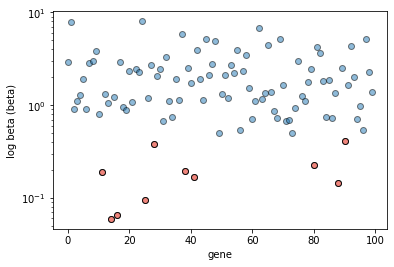

In [20]:
test_out = all_params[-1]
test_marks = all_marks[-1][0:num_marks]

plt.scatter(range(len(test_out[0,:,0])), 10**test_out[0,:,2],alpha=0.5,edgecolor='black')
plt.scatter(np.array(range(len(test_out[0,:,0])))[test_marks], 10**test_out[0,:,2][test_marks],color='salmon',alpha=0.9,edgecolor='black')
plt.yscale('log')
plt.xlabel('gene')
plt.ylabel('log beta (beta)')

Text(0, 0.5, 'log burst size (b)')

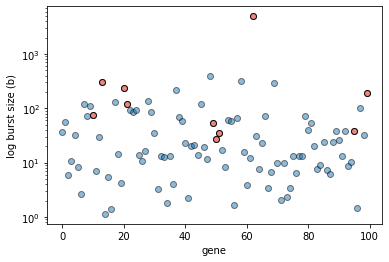

In [21]:
test_out = all_params[1]
test_marks = all_marks[1][0:num_marks]

plt.scatter(range(len(test_out[0,:,0])), 10**test_out[0,:,0],alpha=0.5,edgecolor='black')
plt.scatter(np.array(range(len(test_out[0,:,0])))[test_marks], 10**test_out[0,:,0][test_marks],color='salmon',alpha=0.9,edgecolor='black')
plt.yscale('log')
plt.xlabel('gene')
plt.ylabel('log burst size (b)')

[[1.        0.6751994]
 [0.6751994 1.       ]]


Text(0, 0.5, 'param mean U')

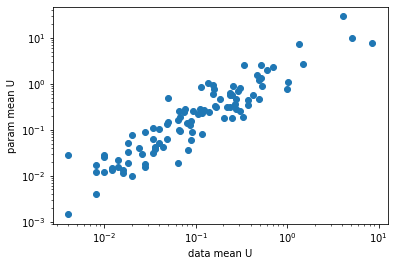

In [22]:
#Check relationship between means and means from params
k1 = all_counts[1][0:500,:,:]
k1.shape

sim_mean = test_out[0,:,0]+test_out[0,:,4]-test_out[0,:,1]
plt.scatter(np.mean(k1[:,:,0],axis=0),10**sim_mean )
print(np.corrcoef(np.mean(k1[:,:,0],axis=0),10**(sim_mean )))
plt.xscale("log")
plt.yscale("log")
plt.xlabel('data mean U')
plt.ylabel('param mean U')

In [23]:
test_cluster = all_counts[-3]

In [24]:
concat_types = np.concatenate((np.mean(test_cluster[0:500,:,:],axis=0),np.mean(test_cluster[500:1000,:,:],axis=0),
          np.mean(test_cluster[1000:1500,:,:],axis=0)),axis=1)


[Text(1, 0.5, '58'),
 Text(1, 1.5, '23'),
 Text(1, 2.5, '54'),
 Text(1, 3.5, '59'),
 Text(1, 4.5, '17'),
 Text(1, 5.5, '48'),
 Text(1, 6.5, '66'),
 Text(1, 7.5, '36'),
 Text(1, 8.5, '69'),
 Text(1, 9.5, '18'),
 Text(1, 10.5, '38'),
 Text(1, 11.5, '93'),
 Text(1, 12.5, '0'),
 Text(1, 13.5, '37'),
 Text(1, 14.5, '29'),
 Text(1, 15.5, '44'),
 Text(1, 16.5, '63'),
 Text(1, 17.5, '8'),
 Text(1, 18.5, '12'),
 Text(1, 19.5, '20'),
 Text(1, 20.5, '32'),
 Text(1, 21.5, '72'),
 Text(1, 22.5, '99'),
 Text(1, 23.5, '46'),
 Text(1, 24.5, '71'),
 Text(1, 25.5, '25'),
 Text(1, 26.5, '91'),
 Text(1, 27.5, '95'),
 Text(1, 28.5, '49'),
 Text(1, 29.5, '87'),
 Text(1, 30.5, '61'),
 Text(1, 31.5, '52'),
 Text(1, 32.5, '88'),
 Text(1, 33.5, '22'),
 Text(1, 34.5, '70'),
 Text(1, 35.5, '90'),
 Text(1, 36.5, '98'),
 Text(1, 37.5, '84'),
 Text(1, 38.5, '75'),
 Text(1, 39.5, '78'),
 Text(1, 40.5, '34'),
 Text(1, 41.5, '64'),
 Text(1, 42.5, '10'),
 Text(1, 43.5, '80'),
 Text(1, 44.5, '14'),
 Text(1, 45.5, '6'),
 

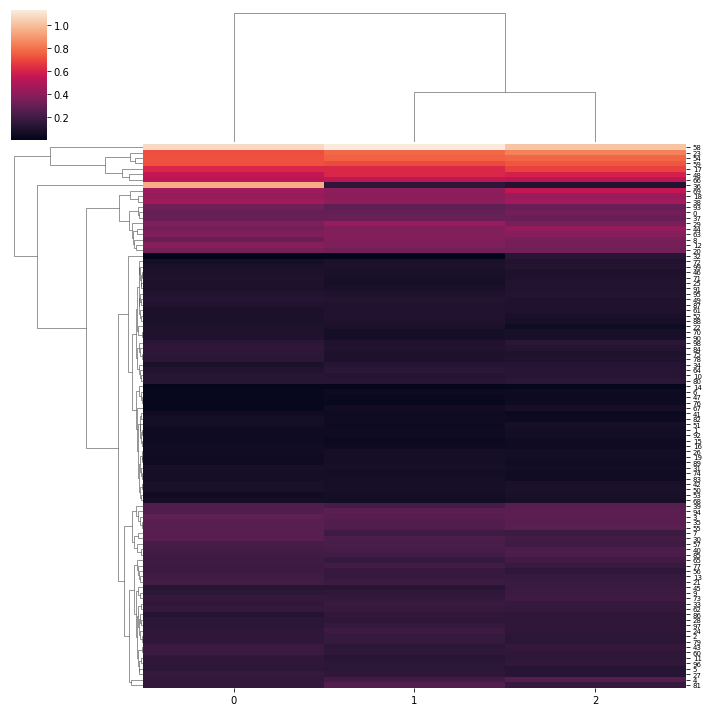

In [25]:
#How separated are clusters by 'DE genes,', cluster on mean Spliced counts
g = sns.clustermap(np.log1p(concat_types[:,[1,3,5]]),yticklabels=True)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 7)



[Text(1, 0.5, '37'),
 Text(1, 1.5, '13'),
 Text(1, 2.5, '59'),
 Text(1, 3.5, '88'),
 Text(1, 4.5, '89'),
 Text(1, 5.5, '8'),
 Text(1, 6.5, '77'),
 Text(1, 7.5, '63'),
 Text(1, 8.5, '9'),
 Text(1, 9.5, '28'),
 Text(1, 10.5, '48'),
 Text(1, 11.5, '7'),
 Text(1, 12.5, '32'),
 Text(1, 13.5, '42'),
 Text(1, 14.5, '30'),
 Text(1, 15.5, '57'),
 Text(1, 16.5, '65'),
 Text(1, 17.5, '97'),
 Text(1, 18.5, '70'),
 Text(1, 19.5, '72'),
 Text(1, 20.5, '4'),
 Text(1, 21.5, '12'),
 Text(1, 22.5, '91'),
 Text(1, 23.5, '16'),
 Text(1, 24.5, '47'),
 Text(1, 25.5, '26'),
 Text(1, 26.5, '33'),
 Text(1, 27.5, '93'),
 Text(1, 28.5, '67'),
 Text(1, 29.5, '87'),
 Text(1, 30.5, '84'),
 Text(1, 31.5, '45'),
 Text(1, 32.5, '79'),
 Text(1, 33.5, '24'),
 Text(1, 34.5, '22'),
 Text(1, 35.5, '68'),
 Text(1, 36.5, '49'),
 Text(1, 37.5, '0'),
 Text(1, 38.5, '85'),
 Text(1, 39.5, '1'),
 Text(1, 40.5, '35'),
 Text(1, 41.5, '36'),
 Text(1, 42.5, '53'),
 Text(1, 43.5, '6'),
 Text(1, 44.5, '54'),
 Text(1, 45.5, '46'),
 Text

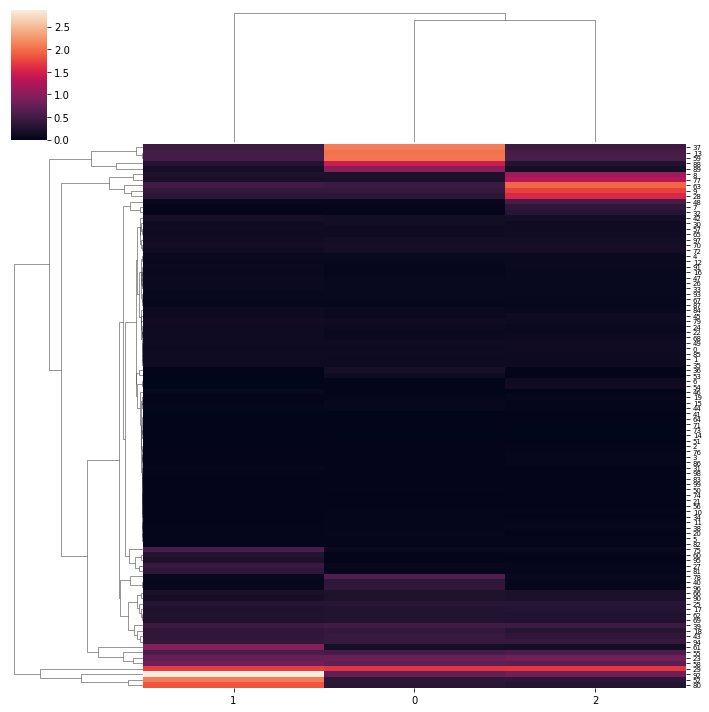

In [26]:
#How separated are clusters by 'DE genes,', cluster on mean Unspliced counts
g = sns.clustermap(np.log1p(concat_types[:,[0,2,4]]),yticklabels=True)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 7)



Text(0, 0.5, 'Mature counts')

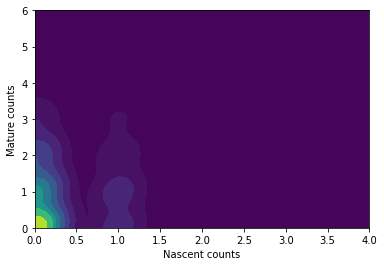

In [27]:
plt.figure()
test_gene = k1[:,50,:]
sns.kdeplot(x=test_gene[:,0], y=test_gene[:,1], cmap="viridis", shade=True, thresh=0)
plt.xlim(np.min(test_gene[:,0]),np.max(test_gene[:,0]))
plt.ylim(np.min(test_gene[:,1]),np.max(test_gene[:,1]))
plt.xlabel('Nascent counts')
plt.ylabel('Mature counts')


In [28]:
np.max(k1)

55.0

**Save count matrices for Monod**

In [29]:
!mkdir ~/counts/mixMod_sims
!mkdir ~/counts/mixMod_sims/loom/

mkdir: cannot create directory ‘/home/tchari/counts/mixMod_sims’: File exists
mkdir: cannot create directory ‘/home/tchari/counts/mixMod_sims/loom/’: File exists


In [70]:
out_names = ['single_clus_test','lowest_b_sim','lowest_b_beta_g_sim',
             'beta90_sim','lowest_beta90_sim',
             'beta100_sim','lowest_beta100_sim'] 

In [31]:
#And save counts to loom file, for meK-Means/Monod processing
out_path = '/home/tchari/counts/mixMod_sims/loom/'
geneNames = names_sub
for ind in range(len(out_names)):
    U = all_counts[ind][:,:,0]
    S = all_counts[ind][:,:,1]
    
    bars = [str(i) for i in range(n_cells*clus)]

    fname = out_path+out_names[ind]+'.loom'

    print('Making Loom')
    #Make loom of U/S
    retAdata = anndata.AnnData(
                X=sparse.csr_matrix(S),
                layers={
                    'spliced': sparse.csr_matrix(S),
                    'unspliced': sparse.csr_matrix(U),
                },
                obs=pd.DataFrame({'barcode': np.array(bars)},index=np.array(bars)),
                var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
            )

    retAdata.write_loom(fname)
    print(fname)


Making Loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


/home/tchari/counts/mixMod_sims/loom/single_clus_test.loom
Making Loom
/home/tchari/counts/mixMod_sims/loom/lowest_b_sim.loom
Making Loom
/home/tchari/counts/mixMod_sims/loom/lowest_b_beta_g_sim.loom
Making Loom
/home/tchari/counts/mixMod_sims/loom/beta90_sim.loom
Making Loom
/home/tchari/counts/mixMod_sims/loom/lowest_beta90_sim.loom
Making Loom
/home/tchari/counts/mixMod_sims/loom/beta100_sim.loom
Making Loom
/home/tchari/counts/mixMod_sims/loom/lowest_beta100_sim.loom


In [32]:
#----- EXTRA CONTROL: Make loom with just one cluster, for comparing to Monod fits -----
out_path = '/home/tchari/counts/mixMod_sims/loom/'
U = all_counts[1][0:n_cells,:,0]
S = all_counts[1][0:n_cells,:,1]
geneNames = names_sub
bs = [str(i) for i in range(n_cells)]

fname = out_path+'oneClus_lowest_b_sim.loom'

print('Making Loom')
#Make loom of U/S
retAdata = anndata.AnnData(
			X=sparse.csr_matrix(S),
			layers={
				'spliced': sparse.csr_matrix(S),
				'unspliced': sparse.csr_matrix(U),
			},
			obs=pd.DataFrame({'barcode': np.array(bs)},index=np.array(bs)),
			var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
		)

retAdata.write_loom(fname)
print(fname)

Making Loom
/home/tchari/counts/mixMod_sims/loom/oneClus_lowest_b_sim.loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [33]:
#----- EXTRA CONTROL: Make loom with just one cluster, for comparing to Monod fits, for b,beta and gamma sim -----
out_path = '/home/tchari/counts/mixMod_sims/loom/'
U = all_counts[2][0:n_cells,:,0]
S = all_counts[2][0:n_cells,:,1]
geneNames = names_sub
bs = [str(i) for i in range(n_cells)]

fname = out_path+'oneClus_lowest_b_beta_g_sim.loom'

print('Making Loom')
#Make loom of U/S
retAdata = anndata.AnnData(
			X=sparse.csr_matrix(S),
			layers={
				'spliced': sparse.csr_matrix(S),
				'unspliced': sparse.csr_matrix(U),
			},
			obs=pd.DataFrame({'barcode': np.array(bs)},index=np.array(bs)),
			var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
		)

retAdata.write_loom(fname)
print(fname)

Making Loom
/home/tchari/counts/mixMod_sims/loom/oneClus_lowest_b_beta_g_sim.loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [34]:
#----- EXTRA CONTROL: Make loom with just one cluster, for comparing to Monod fits, for b,beta sim -----
out_path = '/home/tchari/counts/mixMod_sims/loom/'
U = all_counts[3][0:n_cells,:,0]
S = all_counts[3][0:n_cells,:,1]
geneNames = names_sub
bs = [str(i) for i in range(n_cells)]

fname = out_path+'oneClus_beta90_sim.loom'

print('Making Loom')
#Make loom of U/S
retAdata = anndata.AnnData(
			X=sparse.csr_matrix(S),
			layers={
				'spliced': sparse.csr_matrix(S),
				'unspliced': sparse.csr_matrix(U),
			},
			obs=pd.DataFrame({'barcode': np.array(bs)},index=np.array(bs)),
			var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
		)

retAdata.write_loom(fname)
print(fname)

Making Loom
/home/tchari/counts/mixMod_sims/loom/oneClus_beta90_sim.loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [35]:
# #Check loom ok
# ds = lp.connect('/home/tchari/counts/mixMod_sims/loom/b_sim.loom')

In [36]:
# ds

In [37]:
# ds.close()

## **Run Inference**

Set loom filepaths for each simulation to fit with meK-Means

In [71]:
#Make K*datasets filepaths, for each K to be tested in meK-Means inference
rep_data = list(np.repeat(out_names,5))+['oneClus_lowest_b_sim']+['oneClus_lowest_b_beta_g_sim']+['oneClus_beta90_sim']
ks = [1,2,3,4,5]*len(out_names)+[1,1,1]

dataset_meta = rep_data #['burst_mark_sim','oneClus_burst_mark_sim']
print('dataset_meta: ', dataset_meta)
print()


cluster_names = []

d_names = []
for i in range(len(ks)):
    d_names += [rep_data[i]+'_k'+str(ks[i])]
    
dataset_names = d_names  #To save
print('dataset_names: ', dataset_names)
print('len(dataset_names): ',len(dataset_names))
print()

#Set transcriptome filepath
raw_data_locations = rep_data 
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/mmSim_genome_polyA_cum_3' #'gg_200525_genome_polyA_cum_3'

#Set name of layers in loom
spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

#Set loom filepath for each simulation
loom_filepaths = ['/home/tchari/counts/mixMod_sims/loom/'+x+'.loom' for x in raw_data_locations] 
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

dataset_meta:  ['single_clus_test', 'single_clus_test', 'single_clus_test', 'single_clus_test', 'single_clus_test', 'lowest_b_sim', 'lowest_b_sim', 'lowest_b_sim', 'lowest_b_sim', 'lowest_b_sim', 'lowest_b_beta_g_sim', 'lowest_b_beta_g_sim', 'lowest_b_beta_g_sim', 'lowest_b_beta_g_sim', 'lowest_b_beta_g_sim', 'beta90_sim', 'beta90_sim', 'beta90_sim', 'beta90_sim', 'beta90_sim', 'lowest_beta90_sim', 'lowest_beta90_sim', 'lowest_beta90_sim', 'lowest_beta90_sim', 'lowest_beta90_sim', 'beta100_sim', 'beta100_sim', 'beta100_sim', 'beta100_sim', 'beta100_sim', 'lowest_beta100_sim', 'lowest_beta100_sim', 'lowest_beta100_sim', 'lowest_beta100_sim', 'lowest_beta100_sim', 'oneClus_lowest_b_sim', 'oneClus_lowest_b_beta_g_sim', 'oneClus_beta90_sim']

dataset_names:  ['single_clus_test_k1', 'single_clus_test_k2', 'single_clus_test_k3', 'single_clus_test_k4', 'single_clus_test_k5', 'lowest_b_sim_k1', 'lowest_b_sim_k2', 'lowest_b_sim_k3', 'lowest_b_sim_k4', 'lowest_b_sim_k5', 'lowest_b_beta_g_sim_k1'

In [72]:
print(n_datasets)

38


Dataset single_clus_test. 
	1500 barcodes in loom, 0 pass filter. 1500 in annotations; of these, 1500 in loom and 0 in filtered loom.
	Keep All: 1500 cells in annotations. 1500 in loom. 1500 pass filter.
Dataset single_clus_test. 
	1500 barcodes in loom, 0 pass filter. 1500 in annotations; of these, 1500 in loom and 0 in filtered loom.
	Keep All: 1500 cells in annotations. 1500 in loom. 1500 pass filter.
Dataset single_clus_test. 
	1500 barcodes in loom, 0 pass filter. 1500 in annotations; of these, 1500 in loom and 0 in filtered loom.
	Keep All: 1500 cells in annotations. 1500 in loom. 1500 pass filter.
Dataset single_clus_test. 
	1500 barcodes in loom, 0 pass filter. 1500 in annotations; of these, 1500 in loom and 0 in filtered loom.
	Keep All: 1500 cells in annotations. 1500 in loom. 1500 pass filter.
Dataset single_clus_test. 
	1500 barcodes in loom, 0 pass filter. 1500 in annotations; of these, 1500 in loom and 0 in filtered loom.
	Keep All: 1500 cells in annotations. 1500 in loom

/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


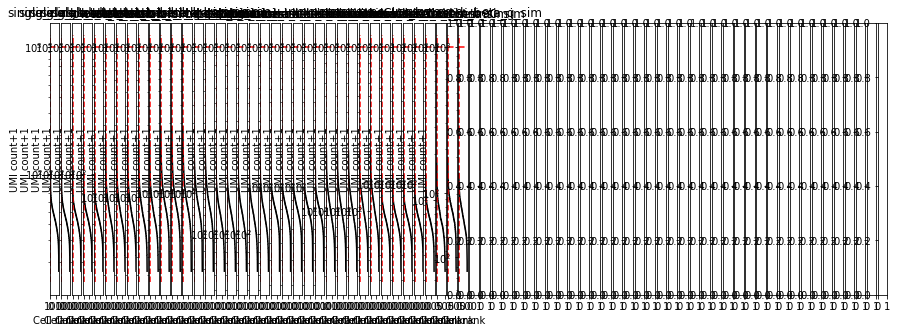

In [73]:
#Usually we would filter for low counts cells, but here we will keep all cell barcodes from simulations
cf = []
thr_lb = [1e3]*len(dataset_meta)*2 #Ignore filter for now, comes from Monod standard for 10x data

fig1,ax1 = plt.subplots(1,len(dataset_meta)*2,figsize=(15,5))

#For each meK-Means run, save cell barcodes to use
for k in range(len(dataset_meta)):
    filename = loom_filepaths[k]
    dataset_name = raw_data_locations[k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = len(bcs)
        annot_bcs_in_loom = len(bcs)
        annot_bcs_in_filt_loom = cf_.sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')

        subcluster = 'Keep All'
        annot_bcs = bcs
      
        
        cf.append(np.isin(bcs,annot_bcs))
        print(f'\t{subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')



    ax1[k].set_title(dataset_name)
    
!mkdir ./figs    
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_burst_mark_sim_forMM.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)

In [74]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

In [75]:
#Define bounds on physical params and sample/technical params (these set to only one set of values)
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5

samp_lb = [-7.157894736842105, -1.525] #-7.5, -2
samp_ub = [-7.157894736842105, -1.525] #-5.5, 0
gridsize = [1,1] #Not searching over grid of technical params for now


**Set up filepaths and gene csv for Monod/meK-Means inference**

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1 created.
INFO:root:Dataset: single_clus_test_k1
INFO:root:1500 cells detected.
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:28 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k1 created.
INFO:root:Dataset: single_clus_test_k2
INFO:root:1500 cells detected.
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:28 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k2 created.
INFO:root:Dataset: single_clus_test_k3
INFO:root:1500 cells detected.
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:28 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k3 created.
INFO:root:Dataset: si

/home/tchari/monod/src/monod/preprocess.py:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))


INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/lowest_beta90_sim_k4 created.
INFO:root:Dataset: lowest_beta90_sim_k5
INFO:root:1500 cells detected.
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:32 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/lowest_beta90_sim_k5 created.
INFO:root:Dataset: beta100_sim_k1
INFO:root:1500 cells detected.
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:33 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/beta100_sim_k1 created.
INFO:root:Dataset: beta100_sim_k2
INFO:root:1500 cells detected.
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:33 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/beta100_sim_k2 created.
INFO:root:Dataset: beta100_sim_k3
INFO:root:1500 cells detected.
INFO:ro

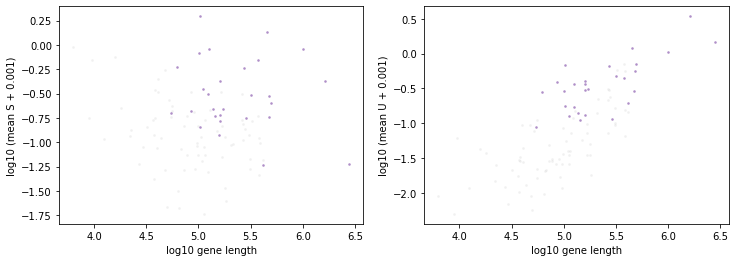

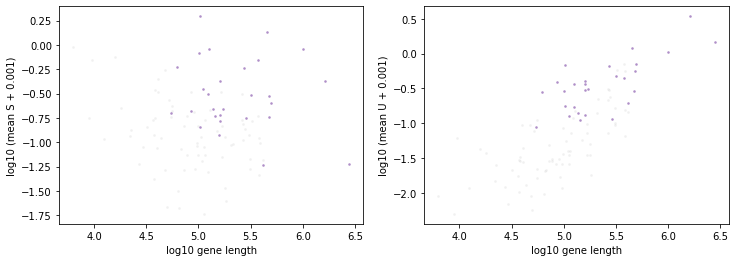

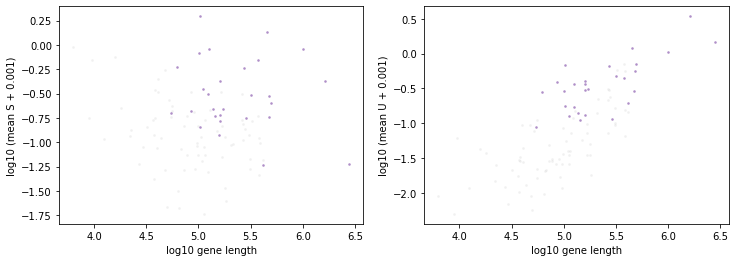

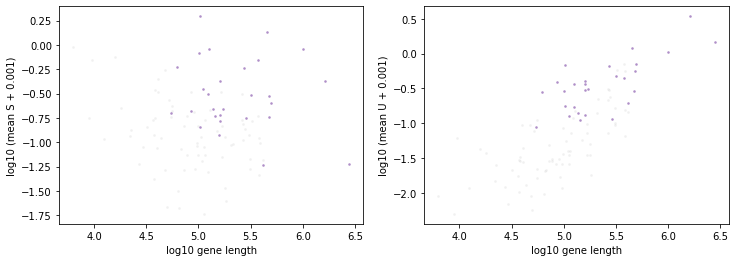

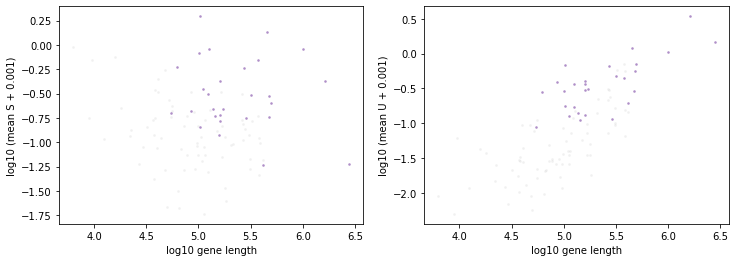

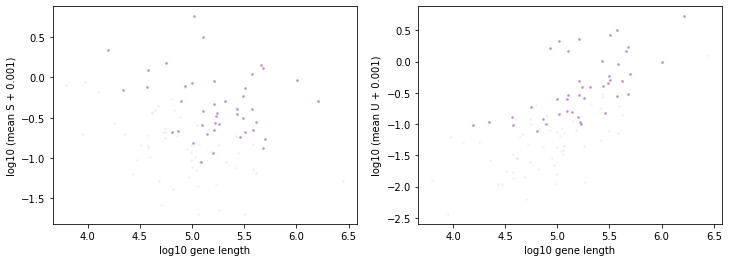

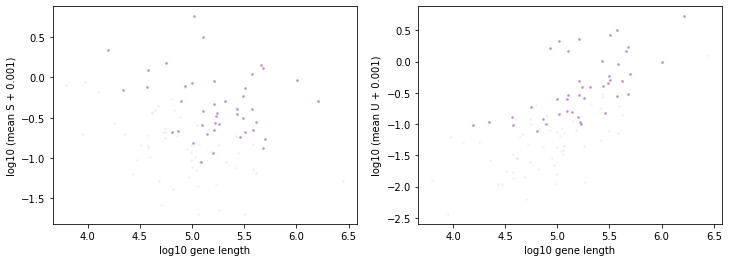

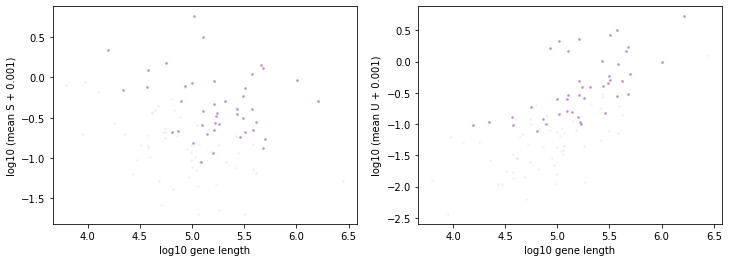

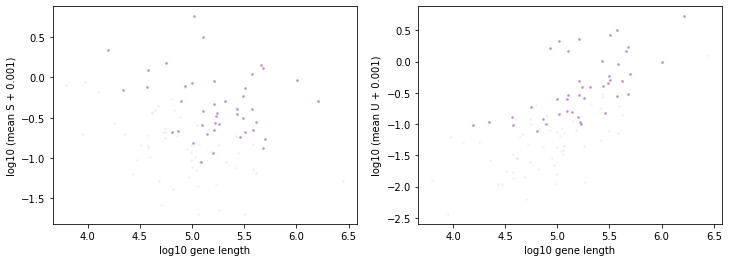

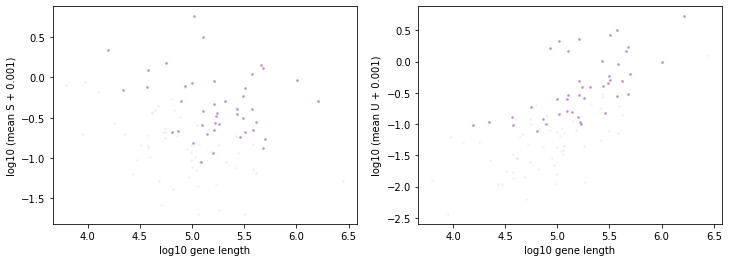

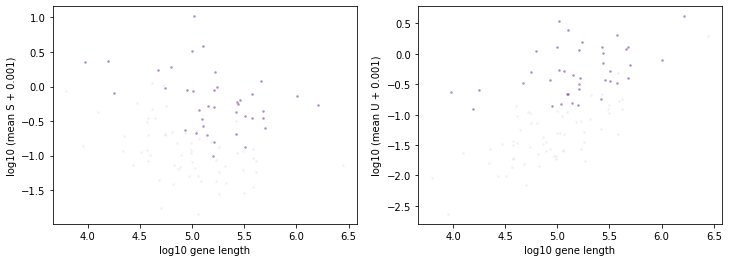

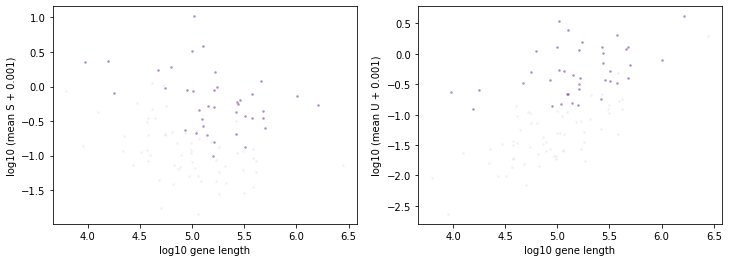

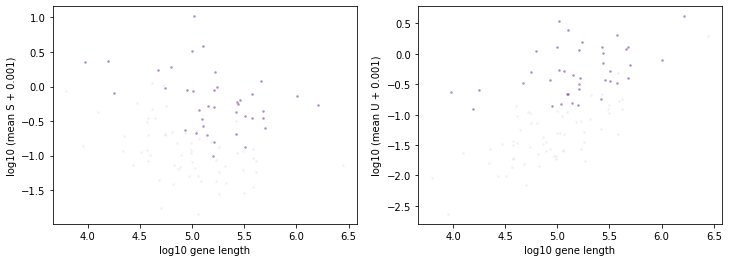

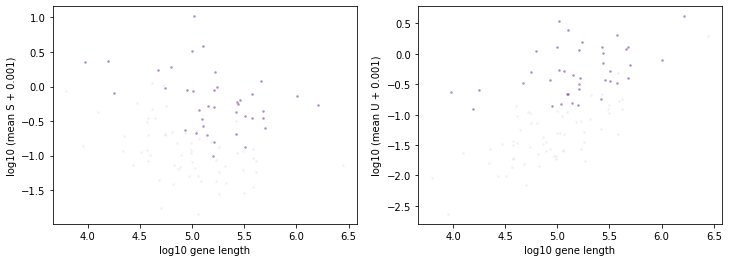

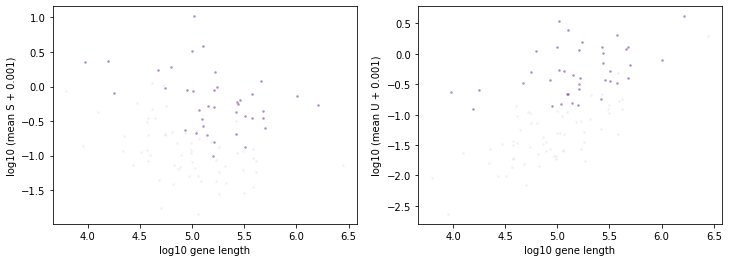

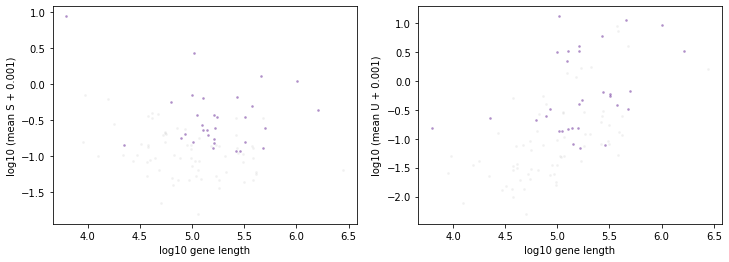

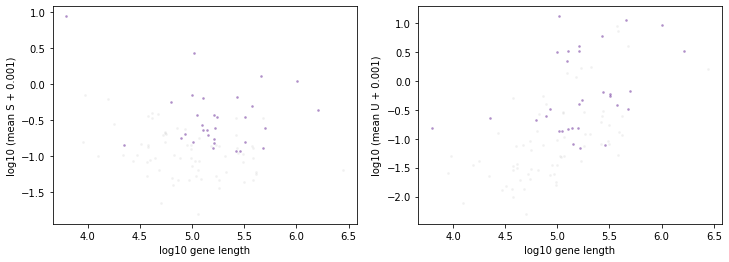

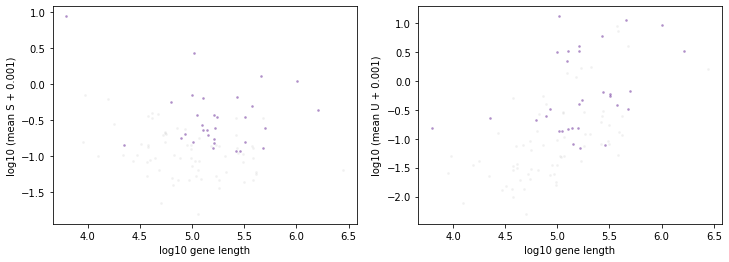

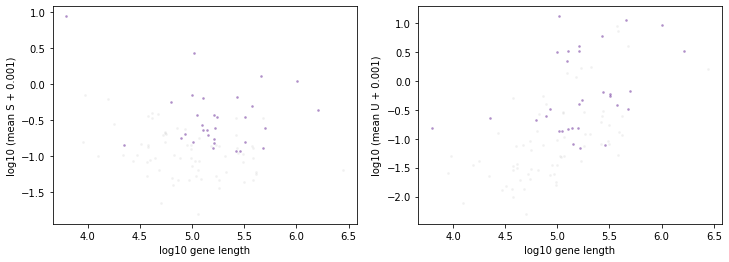

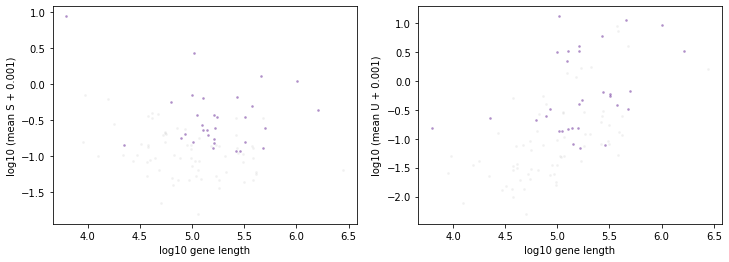

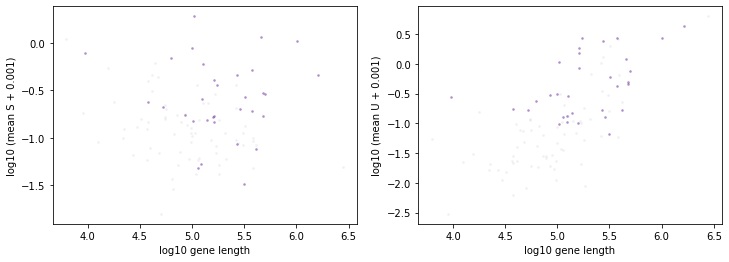

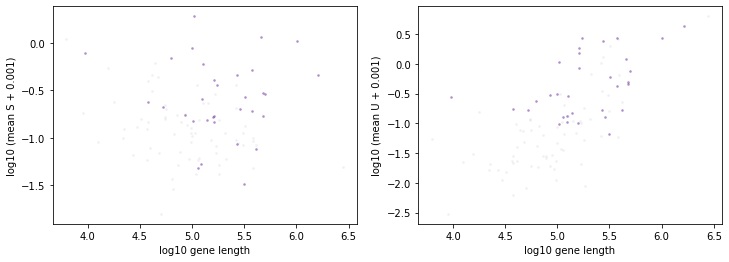

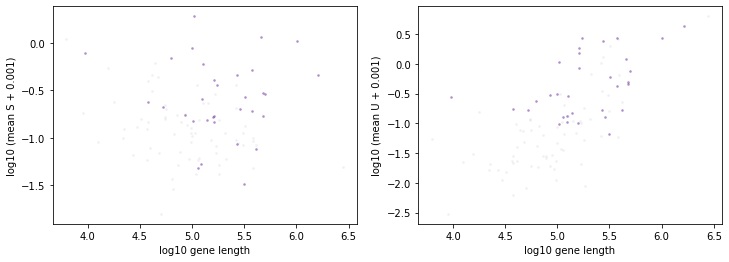

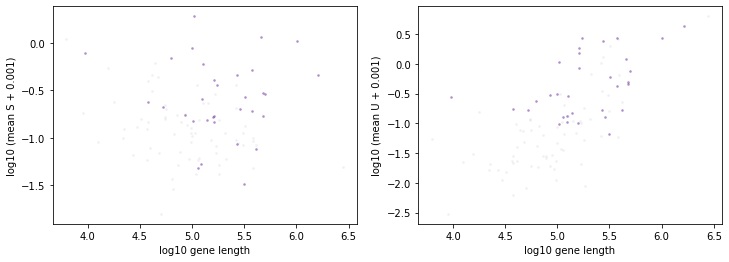

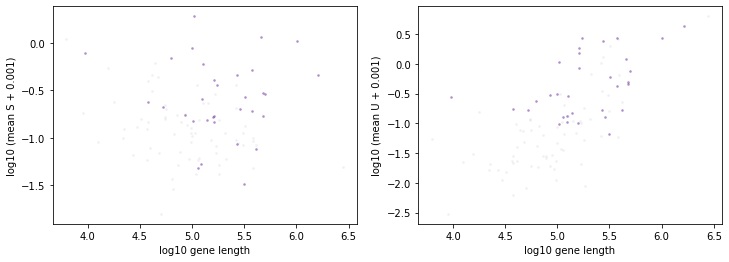

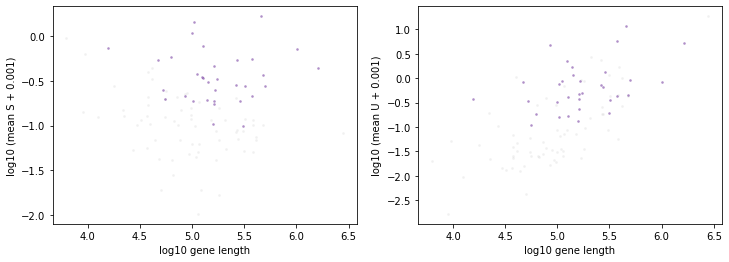

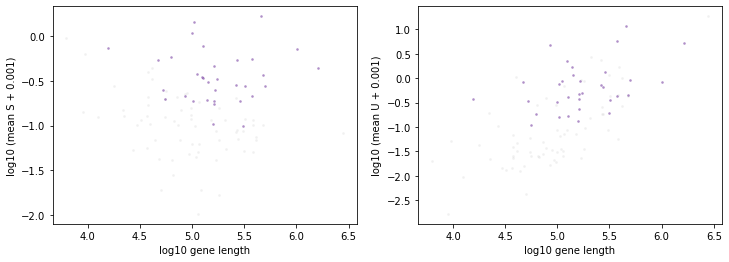

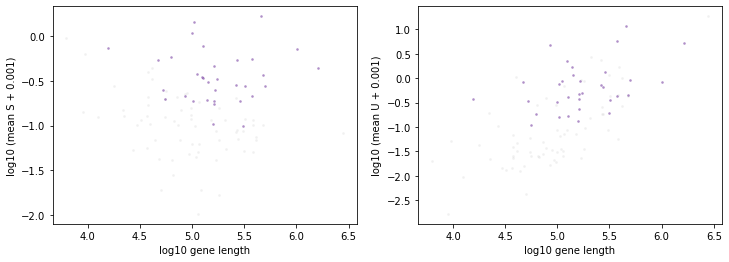

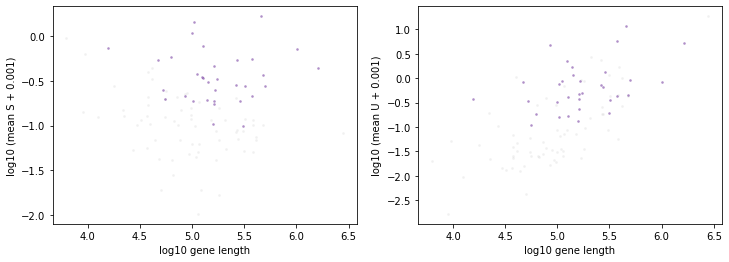

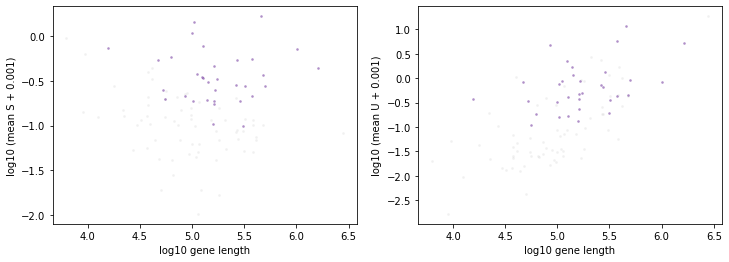

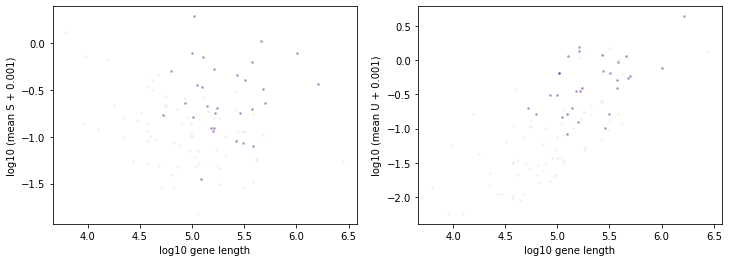

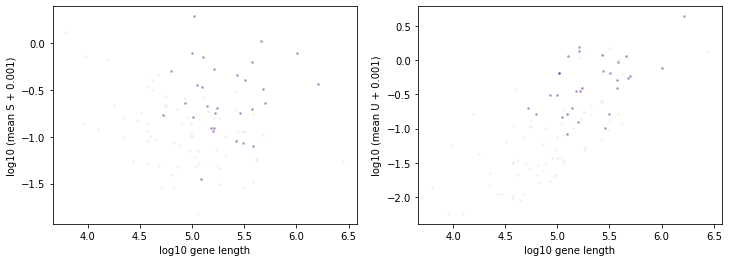

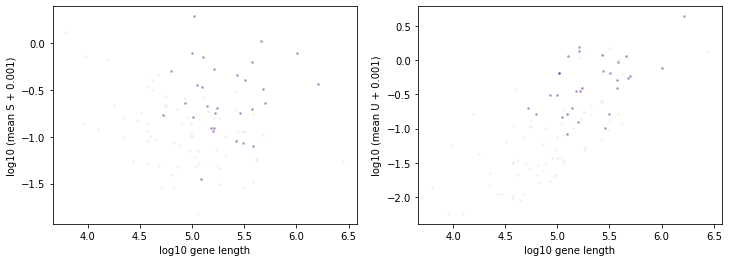

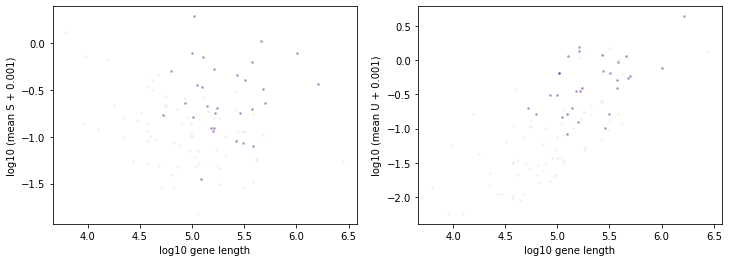

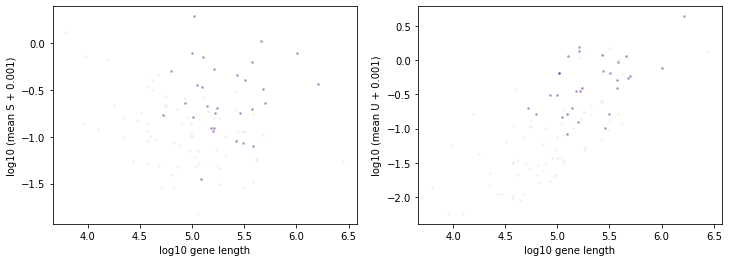

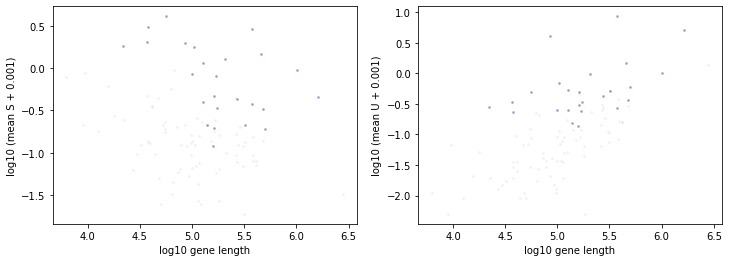

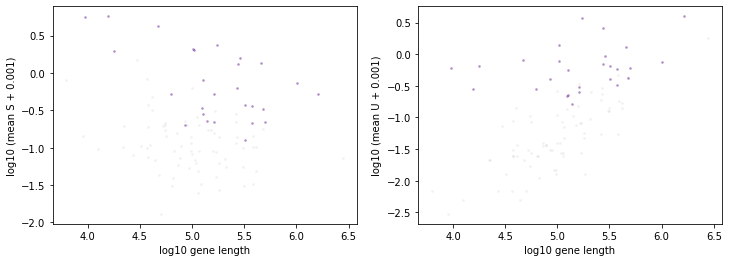

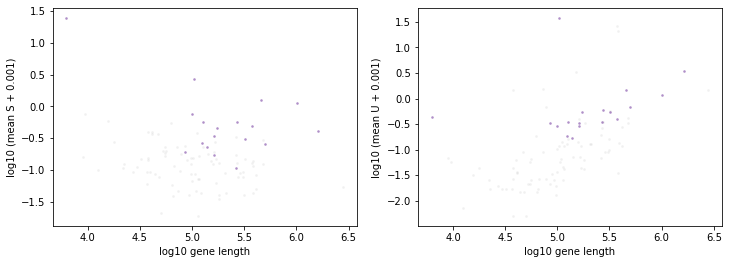

In [45]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='simTests_MM',batch_id=1,\
                                             datestring='230509', n_genes=100,exp_filter_threshold=None,cf=cf) #230411

In [76]:
dir_string = './fits/gg_230509_025_simTests_MM_1'
dataset_strings = [ dir_string+'/'+item for item in dataset_names]
print(dataset_strings)

['./fits/gg_230509_025_simTests_MM_1/single_clus_test_k1', './fits/gg_230509_025_simTests_MM_1/single_clus_test_k2', './fits/gg_230509_025_simTests_MM_1/single_clus_test_k3', './fits/gg_230509_025_simTests_MM_1/single_clus_test_k4', './fits/gg_230509_025_simTests_MM_1/single_clus_test_k5', './fits/gg_230509_025_simTests_MM_1/lowest_b_sim_k1', './fits/gg_230509_025_simTests_MM_1/lowest_b_sim_k2', './fits/gg_230509_025_simTests_MM_1/lowest_b_sim_k3', './fits/gg_230509_025_simTests_MM_1/lowest_b_sim_k4', './fits/gg_230509_025_simTests_MM_1/lowest_b_sim_k5', './fits/gg_230509_025_simTests_MM_1/lowest_b_beta_g_sim_k1', './fits/gg_230509_025_simTests_MM_1/lowest_b_beta_g_sim_k2', './fits/gg_230509_025_simTests_MM_1/lowest_b_beta_g_sim_k3', './fits/gg_230509_025_simTests_MM_1/lowest_b_beta_g_sim_k4', './fits/gg_230509_025_simTests_MM_1/lowest_b_beta_g_sim_k5', './fits/gg_230509_025_simTests_MM_1/beta90_sim_k1', './fits/gg_230509_025_simTests_MM_1/beta90_sim_k2', './fits/gg_230509_025_simTests

In [77]:
len(dataset_strings)

38

**Fit Standard Monod on Control tests (single clusters)**

INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/oneClus_lowest_b_sim_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230509_025_simTests_MM_1/oneClus_lowest_b_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: oneClus_lowest_b_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/oneClus_lowest_b_sim_k1/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/oneClus_lowest_b_sim_k1/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.09s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/oneClus_lowest_b_sim_k1/Bursty_Poisson_1x1/analysis_figures created.
INFO:root:Runtime: 3.6 seconds.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/oneClus_lowest_b_beta_g_sim_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230509_025_simTests_MM_1/oneClus_lowest_b_beta_g_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: oneClus_lowest_b_beta_g_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/oneClus_lowest_b_beta_g_sim_k1/diagnostic_figures created.


INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/oneClus_lowest_b_beta_g_sim_k1/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.44s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/oneClus_lowest_b_beta_g_sim_k1/Bursty_Poisson_1x1/analysis_figures created.
INFO:root:Runtime: 4.0 seconds.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/oneClus_beta90_sim_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230509_025_simTests_MM_1/oneClus_beta90_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: oneClus_beta90_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/oneClus_beta90_sim_k1/diagnostic_figures created.


INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/oneClus_beta90_sim_k1/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.28s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/oneClus_beta90_sim_k1/Bursty_Poisson_1x1/analysis_figures created.
INFO:root:Runtime: 3.8 seconds.


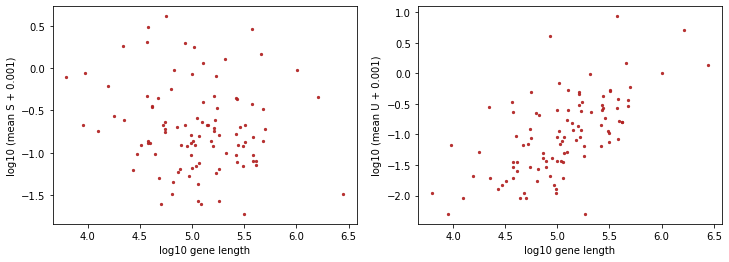

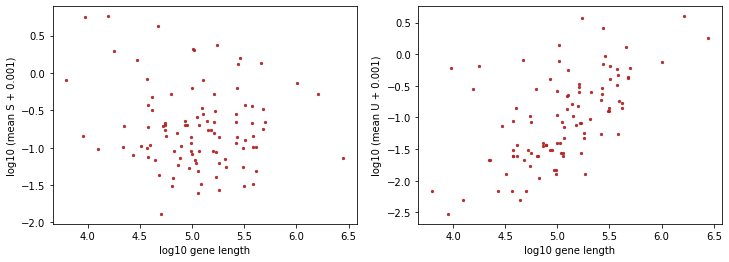

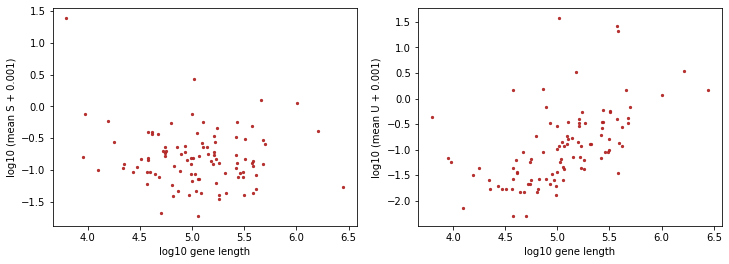

In [48]:
#Control test with standard Monod fit on first, known cluster of cells
result_strings = []
#for i in range(1,2): #n_datasets
for i in range(len(ks)-3,len(ks)):

    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})

    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])

    full_result_string = inference_parameters.fit_all_grid_points(30,search_data)

    result_strings.append(full_result_string)

In [78]:
result_strings = [i+'/Bursty_Poisson_1x1/grid_scan_results.res' for i in dataset_strings[(len(dataset_names)-3):]]


In [80]:
sr = [monod.analysis.load_search_results(i) for i in result_strings]
sr

INFO:root:Grid scan results loaded from ./fits/gg_230509_025_simTests_MM_1/oneClus_lowest_b_sim_k1/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230509_025_simTests_MM_1/oneClus_lowest_b_beta_g_sim_k1/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230509_025_simTests_MM_1/oneClus_beta90_sim_k1/Bursty_Poisson_1x1/grid_scan_results.res.


**Run meK-Means on all cells**

In [81]:
epochs=20

In [ ]:

result_strings = []
for i in range(len(ks)-3): #range(len(ks)-2): #n_datasets, running data with all clusters
    
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,k=ks[i],epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})
    
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[i])
    
    inference_parameters.fit_all_grid_points(50,search_data)


INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.38s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.40s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.47s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.42s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.41s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.28s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.29s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.28s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.24s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.43s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.22s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k2/Bursty_Poisson_1x1 created.


INFO:root:Global inference parameters stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k2/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k2/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.76s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.65s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.54478347 0.45521653]
Q Function:  -140441.71661285288

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.71s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.57694966 0.42305034]
Q Function:  -140228.30909208464

INFO:root:EM Epoch 3/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.66s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48132346 0.51867654]
Q Function:  -137897.18355822004

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.69s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.6480998 0.3519002]
Q Function:  -137544.60560914053

INFO:root:EM Epoch 5/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.77s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.68225206 0.31774794]
Q Function:  -136708.36518307103

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.63s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.54318917 0.45681083]
Q Function:  -139430.92344477965

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.57s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.68597979 0.31402021]
Q Function:  -137152.625718728

INFO:root:EM Epoch 8/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.63s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.55481197 0.44518803]
Q Function:  -139558.10774969572

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.69s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.51949002 0.48050998]
Q Function:  -139121.27384619846

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.74s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.28340345 0.71659655]
Q Function:  -138637.0326215215

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.64s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.29367173 0.70632827]
Q Function:  -139552.39790803462

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.2589609 0.7410391]
Q Function:  -136707.93494460123

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.70s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.1445494 0.8554506]
Q Function:  -137092.01670924659

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.64s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.0071812 0.9928188]
Q Function:  -140262.27418756703

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.11621142e-04 9.99288379e-01]
Q Function:  -139964.5254853454

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667332e-04 9.99333333e-01]
Q Function:  -139943.80353345527

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667332e-04 9.99333333e-01]
Q Function:  -139943.8013557205

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667332e-04 9.99333333e-01]
Q Function:  -139943.8013557205

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.37s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667332e-04 9.99333333e-01]
Q Function:  -139943.8013557205

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667332e-04 9.99333333e-01]
Q Function:  -139943.8013557205

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k3/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.


INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.00it/s]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.37268195 0.29535162 0.33196643]
Q Function:  -140775.73194401813

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.55933192 0.20729269 0.2333754 ]
Q Function:  -137418.2888912612

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.40314435 0.26252637 0.33432928]
Q Function:  -138743.4570575062

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.00s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48858564 0.27990766 0.2315067 ]
Q Function:  -137208.18191727335

INFO:root:EM Epoch 5/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3938453  0.21713075 0.38902395]
Q Function:  -139287.00094961186

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.01s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.50811115 0.22879288 0.26309596]
Q Function:  -137261.21114953945

INFO:root:EM Epoch 7/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.39736794 0.17675918 0.42587288]
Q Function:  -139169.5241238781

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.01s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.52509118 0.19142063 0.28348819]
Q Function:  -137301.5104027702

INFO:root:EM Epoch 9/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.40847286 0.13549614 0.456031  ]
Q Function:  -139053.03546097106

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.54699883 0.15088489 0.30211627]
Q Function:  -137333.3681686922

INFO:root:EM Epoch 11/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.39261853 0.22261084 0.38477062]
Q Function:  -138173.75714606687

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.01s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.48368338 0.17012524 0.34619138]
Q Function:  -137335.15636481612

INFO:root:EM Epoch 13/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.61551261 0.1617249  0.22276249]
Q Function:  -136976.7428243408

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.00it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.44982733 0.24980455 0.30036813]
Q Function:  -138825.5828211563

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.70532686 0.19394564 0.1007275 ]
Q Function:  -137844.325288143

INFO:root:EM Epoch 16/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.6097493  0.30710872 0.08314198]
Q Function:  -139371.07241847293

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.63s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.83226794e-01 2.16705439e-01 6.77670260e-05]
Q Function:  -137137.25565032888

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.53965064e-01 3.46034922e-01 1.41809927e-08]
Q Function:  -139364.80370477063

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.53s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.71983304e-01 2.28016696e-01 6.69963386e-10]
Q Function:  -136887.49881263217

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.60111117e-01 3.39888882e-01 6.66788086e-10]
Q Function:  -139486.82273285402

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k4/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k4/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k4
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k4/raw.sd.
INFO:root:Starting non-parallelized grid scan.


INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.24it/s]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.16it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.01546348 0.30888517 0.4052022  0.27044915]
Q Function:  -138886.67171416985

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.02441813e-05 4.10350302e-01 2.44144944e-01 3.45464510e-01]
Q Function:  -138944.02245416195

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [5.57365189e-08 3.09992949e-01 4.73789157e-01 2.16217838e-01]
Q Function:  -139376.09622165718

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.56278583e-10 4.58248234e-01 3.00639434e-01 2.41112331e-01]
Q Function:  -138582.79921689891

INFO:root:EM Epoch 5/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.69502494e-10 3.60566676e-01 4.07912027e-01 2.31521296e-01]
Q Function:  -138131.2063309679

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.68621779e-10 4.60605317e-01 3.24672720e-01 2.14721962e-01]
Q Function:  -138206.803300163

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.68134773e-10 3.81770095e-01 4.46547351e-01 1.71682553e-01]
Q Function:  -137966.9929219562

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.67828710e-10 6.07169300e-01 3.70689153e-01 2.21415462e-02]
Q Function:  -138997.46674720006

INFO:root:EM Epoch 9/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.01it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.69284721e-10 6.27955987e-01 3.69083565e-01 2.96044793e-03]
Q Function:  -136808.68750757916

INFO:root:EM Epoch 10/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.68630816e-10 7.20439971e-01 2.79560028e-01 6.69049532e-10]
Q Function:  -136845.91872769076

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.60s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.68170511e-10 8.64639309e-01 1.35360689e-01 6.66666670e-10]
Q Function:  -140338.0446762077

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.60s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.67861384e-10 9.15191984e-01 8.48080149e-02 6.66666665e-10]
Q Function:  -136740.40677546686

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.75s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.67471063e-10 9.64866487e-01 3.51335117e-02 6.66666669e-10]
Q Function:  -139979.38220636724

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.67341620e-10 9.98774256e-01 1.22574301e-03 6.66666669e-10]
Q Function:  -140027.1957869627

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.37s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.67306586e-10 9.99333331e-01 6.66667328e-04 6.66666669e-10]
Q Function:  -139951.84596219863

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.36s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.67306195e-10 9.99333331e-01 6.66667325e-04 6.66666669e-10]
Q Function:  -139951.61612539765

INFO:root:EM Epoch 17/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.35s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.67306195e-10 9.99333331e-01 6.66667325e-04 6.66666669e-10]
Q Function:  -139951.61612539768

INFO:root:EM Epoch 18/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.35s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.67306195e-10 9.99333331e-01 6.66667325e-04 6.66666669e-10]
Q Function:  -139951.61612539768

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.37s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.67306195e-10 9.99333331e-01 6.66667325e-04 6.66666669e-10]
Q Function:  -139951.61612539768

INFO:root:EM Epoch 20/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.36s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.67306195e-10 9.99333331e-01 6.66667325e-04 6.66666669e-10]
Q Function:  -139951.61612539768

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k5/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k5
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.40it/s]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.25355499e-01 3.42058517e-04 3.90111351e-01 1.84103772e-01
 3.00087319e-01]
Q Function:  -138323.7225472418

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.77038474e-01 8.27042242e-07 4.04119809e-01 1.71584488e-01
 2.47256402e-01]
Q Function:  -139468.77669003647

INFO:root:EM Epoch 3/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.26it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.26913849e-02 1.60731076e-09 5.80343879e-01 3.89893393e-03
 3.23065801e-01]
Q Function:  -137880.4560043476

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [8.39117326e-02 6.77861848e-10 5.36900316e-01 6.66667457e-10
 3.79187950e-01]
Q Function:  -138148.712664753

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.06547886e-02 6.67694063e-10 5.64871670e-01 6.66666664e-10
 4.24473540e-01]
Q Function:  -138467.31203064692

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.67557307e-04 6.67112127e-10 7.36663409e-01 6.66666664e-10
 2.62369033e-01]
Q Function:  -138362.56246399303

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.46s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [5.22613519e-08 6.91671722e-10 1.75730386e-01 6.66666664e-10
 8.24269560e-01]
Q Function:  -141192.77239630435

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.70s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66783650e-10 6.68620985e-10 2.26131588e-01 6.66666664e-10
 7.73868410e-01]
Q Function:  -139632.57760757644

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.63s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666722e-10 1.04456902e-09 1.61094880e-02 6.66666664e-10
 9.83890510e-01]
Q Function:  -137031.36675760505

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.57s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667492e-10 7.13659325e-06 8.39485149e-03 6.66666669e-10
 9.91598011e-01]
Q Function:  -140030.04294417694

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667344e-10 4.65913137e-03 1.15103865e-05 6.66666826e-10
 9.95329357e-01]
Q Function:  -140089.14160244697

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667364e-10 4.66619709e-03 4.98829833e-09 6.66698928e-10
 9.95333797e-01]
Q Function:  -140059.34820852213

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667364e-10 4.66619780e-03 6.68539544e-10 6.66698881e-10
 9.95333800e-01]
Q Function:  -140059.33085211227

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667364e-10 4.66619780e-03 6.66917671e-10 6.66698881e-10
 9.95333800e-01]
Q Function:  -140059.330845583

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667364e-10 4.66619780e-03 6.66917062e-10 6.66698881e-10
 9.95333800e-01]
Q Function:  -140059.33084558052

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.56s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667364e-10 4.66619780e-03 6.66917062e-10 6.66698881e-10
 9.95333800e-01]
Q Function:  -140059.33084558052

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667364e-10 4.66619780e-03 6.66917062e-10 6.66698881e-10
 9.95333800e-01]
Q Function:  -140059.33084558052

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667364e-10 4.66619780e-03 6.66917062e-10 6.66698881e-10
 9.95333800e-01]
Q Function:  -140059.33084558052

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667364e-10 4.66619780e-03 6.66917062e-10 6.66698881e-10
 9.95333800e-01]
Q Function:  -140059.33084558052

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.72s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66667364e-10 4.66619780e-03 6.66917062e-10 6.66698881e-10
 9.95333800e-01]
Q Function:  -140059.33084558052

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/lowest_b_sim_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230509_025_simTests_MM_1/lowest_b_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.


INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/lowest_b_sim_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.77s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.96s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.74s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.77s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -176021.99735242117

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/lowest_b_sim_k2/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230509_025_simTests_MM_1/lowest_b_sim_k2/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.


INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/lowest_b_sim_k2/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.69s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.61976419 0.38023581]
Q Function:  -171060.2240888772

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66491254 0.33508746]
Q Function:  -169777.14801244874

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.63s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.65836464 0.34163536]
Q Function:  -170479.1813436476

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66558809 0.33441191]
Q Function:  -171477.48692359615

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.65914604 0.34085396]
Q Function:  -170468.12750818557

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66559112 0.33440888]
Q Function:  -171477.44588147083

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.65914606 0.34085394]
Q Function:  -170468.12761694874

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66559112 0.33440888]
Q Function:  -171477.4458804785

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.65914606 0.34085394]
Q Function:  -170468.12761695147

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66559112 0.33440888]
Q Function:  -171477.44588047848

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.65914606 0.34085394]
Q Function:  -170468.12761695147

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66559112 0.33440888]
Q Function:  -171477.44588047848

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.54s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.65914606 0.34085394]
Q Function:  -170468.12761695147

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66559112 0.33440888]
Q Function:  -171477.44588047848

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.65914606 0.34085394]
Q Function:  -170468.12761695147

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66559112 0.33440888]
Q Function:  -171477.44588047848

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.65914606 0.34085394]
Q Function:  -170468.12761695147

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66559112 0.33440888]
Q Function:  -171477.44588047848

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.65914606 0.34085394]
Q Function:  -170468.12761695147

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66559112 0.33440888]
Q Function:  -171477.44588047848

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/lowest_b_sim_k3/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230509_025_simTests_MM_1/lowest_b_sim_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/lowest_b_sim_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.


INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.01s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.30047189 0.31530372 0.38422439]
Q Function:  -169554.99769144034

INFO:root:EM Epoch 2/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33284784 0.3341239  0.33302827]
Q Function:  -166806.72595322225

INFO:root:EM Epoch 3/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33457529 0.34481923 0.32060548]
Q Function:  -170480.55291358376

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33566155 0.33449672 0.32984173]
Q Function:  -170595.51990643976

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33098683 0.33967671 0.32933645]
Q Function:  -168209.37285699643

INFO:root:EM Epoch 6/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33553301 0.33789266 0.32657433]
Q Function:  -171500.3419057026

INFO:root:EM Epoch 7/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33582341 0.34305178 0.32112481]
Q Function:  -168435.84904492454

INFO:root:EM Epoch 8/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33823841 0.33581215 0.32594944]
Q Function:  -170565.6342570777

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33030595 0.33992836 0.32976568]
Q Function:  -167561.5024488174

INFO:root:EM Epoch 10/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33552014 0.33789424 0.32658562]
Q Function:  -171500.3604951386

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33582325 0.34305179 0.32112496]
Q Function:  -168435.84931499418

INFO:root:EM Epoch 12/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33823841 0.33581215 0.32594944]
Q Function:  -170565.63425467606

INFO:root:EM Epoch 13/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33030595 0.33992836 0.32976568]
Q Function:  -167561.50244862708

INFO:root:EM Epoch 14/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33552014 0.33789424 0.32658562]
Q Function:  -171500.36049513897

INFO:root:EM Epoch 15/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33582325 0.34305179 0.32112496]
Q Function:  -168435.8493149942

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33823841 0.33581215 0.32594944]
Q Function:  -170565.63425467606

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33030595 0.33992836 0.32976568]
Q Function:  -167561.50244862708

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33552014 0.33789424 0.32658562]
Q Function:  -171500.36049513897

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33582325 0.34305179 0.32112496]
Q Function:  -168435.8493149942

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33823841 0.33581215 0.32594944]
Q Function:  -170565.63425467606

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/lowest_b_sim_k4/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230509_025_simTests_MM_1/lowest_b_sim_k4/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k4
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.


INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/lowest_b_sim_k4/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.08817407 0.30789692 0.23173048 0.37219853]
Q Function:  -170684.03159476077

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.13575305 0.33487265 0.18686178 0.34251253]
Q Function:  -169259.37007270323

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.24it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.14249883 0.32998754 0.18877593 0.3387377 ]
Q Function:  -167977.34771738952

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.15it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.24730876 0.33609896 0.07996981 0.33662247]
Q Function:  -171048.18875980764

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.10779601 0.32891844 0.22724133 0.33604421]
Q Function:  -168226.11773913697

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.06395782 0.33776555 0.25838602 0.3398906 ]
Q Function:  -170824.15601806837

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.01938821 0.33189757 0.30964171 0.3390725 ]
Q Function:  -167867.58708571512

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.01388503 0.34047823 0.3087312  0.33690553]
Q Function:  -171589.9053478864

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.00829208 0.33287983 0.31908121 0.33974688]
Q Function:  -167792.67645768786

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.00445621 0.3374019  0.32158823 0.33655366]
Q Function:  -170803.12741514185

INFO:root:EM Epoch 11/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.00108887 0.33654408 0.3233072  0.33905985]
Q Function:  -168026.56873517745

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 3.42344814e-01 3.21154511e-01 3.36500674e-01]
Q Function:  -171551.2892238066

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 3.35287446e-01 3.25446026e-01 3.39266527e-01]
Q Function:  -169106.24661723356

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 3.45655992e-01 3.18963190e-01 3.35380817e-01]
Q Function:  -171464.5929108588

INFO:root:EM Epoch 15/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 3.31000487e-01 3.29577862e-01 3.39421651e-01]
Q Function:  -167666.2197262908

INFO:root:EM Epoch 16/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 3.38093619e-01 3.24454385e-01 3.37451996e-01]
Q Function:  -171506.02671994723

INFO:root:EM Epoch 17/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 3.30440211e-01 3.30054821e-01 3.39504967e-01]
Q Function:  -167606.5608715515

INFO:root:EM Epoch 18/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 3.35605879e-01 3.26560559e-01 3.37833561e-01]
Q Function:  -171498.52557842308

INFO:root:EM Epoch 19/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 3.35831770e-01 3.21114286e-01 3.43053943e-01]
Q Function:  -168435.37522310606

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666665e-10 3.38238651e-01 3.25949166e-01 3.35812182e-01]
Q Function:  -170565.63488293646

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/lowest_b_sim_k5/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230509_025_simTests_MM_1/lowest_b_sim_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k5
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/lowest_b_sim_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.50it/s]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.42it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.11966385 0.19761058 0.32445166 0.13340136 0.22487255]
Q Function:  -169424.71713307322

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.37it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.15549903 0.11907061 0.33635979 0.21308063 0.17598994]
Q Function:  -168276.42596929614

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.45it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.09431528 0.30335082 0.33717579 0.02355376 0.24160436]
Q Function:  -168504.43441279995

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.09864488 0.32006104 0.33713721 0.00039843 0.24375845]
Q Function:  -171379.51908745815

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.24it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.28181818e-02 3.05995697e-01 3.36053580e-01 8.43883596e-06
 3.45124102e-01]
Q Function:  -169808.09095176478

INFO:root:EM Epoch 6/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.26it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [5.71184231e-04 3.07541989e-01 3.36437150e-01 3.74727626e-09
 3.55449673e-01]
Q Function:  -169650.88215438454

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.28643479e-01 3.39087369e-01 6.71471378e-10
 3.32269151e-01]
Q Function:  -167747.51466105157

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.24396500e-01 3.37001565e-01 6.81413438e-10
 3.38601934e-01]
Q Function:  -171468.78171027265

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.26700693e-01 3.39218956e-01 6.67049544e-10
 3.34080350e-01]
Q Function:  -169104.7488070703

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.20987981e-01 3.35602501e-01 6.69316726e-10
 3.43409517e-01]
Q Function:  -171469.6263881576

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.19106266e-01 3.42828188e-01 1.14684463e-07
 3.38065431e-01]
Q Function:  -168495.6480505502

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.24716407e-01 3.35581327e-01 7.24373789e-10
 3.39702265e-01]
Q Function:  -170561.03645163053

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.29672169e-01 3.39854062e-01 6.67142477e-10
 3.30473767e-01]
Q Function:  -167665.74915528725

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.26581466e-01 3.37894010e-01 6.69643761e-10
 3.35524523e-01]
Q Function:  -171500.3616637815

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.21114135e-01 3.43054602e-01 1.32238796e-07
 3.35831131e-01]
Q Function:  -168435.37590096926

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.25946675e-01 3.35812848e-01 7.25542589e-10
 3.38240475e-01]
Q Function:  -170565.62896173497

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.29765559e-01 3.39928587e-01 6.67141944e-10
 3.30305853e-01]
Q Function:  -167561.49956605185

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.26584006e-01 3.37894562e-01 6.69642973e-10
 3.35521431e-01]
Q Function:  -171500.36682552268

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.21114167e-01 3.43054606e-01 1.32237619e-07
 3.35831093e-01]
Q Function:  -168435.37595844077

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.03s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 3.25946676e-01 3.35812848e-01 7.25542059e-10
 3.38240474e-01]
Q Function:  -170565.62896127696

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/lowest_b_beta_g_sim_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230509_025_simTests_MM_1/lowest_b_beta_g_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_beta_g_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/lowest_b_beta_g_sim_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.


INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.34s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.32s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.32s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.33s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.34s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.35s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.32s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.32s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.29s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.35s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.35s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.30s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.35s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.37s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.35s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.33s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.35s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.31s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.37s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.27s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.31s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -179755.57695665077

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/lowest_b_beta_g_sim_k2/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230509_025_simTests_MM_1/lowest_b_beta_g_sim_k2/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_beta_g_sim_k2


INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/lowest_b_beta_g_sim_k2/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.74s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.82s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.36694843 0.63305157]
Q Function:  -175192.6539142842

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.61s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33337288 0.66662712]
Q Function:  -172742.70390375372

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.62s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33492886 0.66507114]
Q Function:  -175650.68970316608

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.62s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33350999 0.66649001]
Q Function:  -174658.11384980637

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.68s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33195609 0.66804391]
Q Function:  -172474.40915229754

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.68s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33743959 0.66256041]
Q Function:  -174439.91423607792

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.73s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33351564 0.66648436]
Q Function:  -174675.02214614677

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.60s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3319561 0.6680439]
Q Function:  -172474.4092048968

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.71s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33743959 0.66256041]
Q Function:  -174439.91423600249

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33351564 0.66648436]
Q Function:  -174675.02214614704

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.64s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3319561 0.6680439]
Q Function:  -172474.4092048968

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.65s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33743959 0.66256041]
Q Function:  -174439.91423600249

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.60s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33351564 0.66648436]
Q Function:  -174675.02214614704

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.61s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3319561 0.6680439]
Q Function:  -172474.4092048968

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.65s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33743959 0.66256041]
Q Function:  -174439.91423600249

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.61s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33351564 0.66648436]
Q Function:  -174675.02214614704

INFO:root:EM Epoch 17/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.59s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3319561 0.6680439]
Q Function:  -172474.4092048968

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.66s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33743959 0.66256041]
Q Function:  -174439.91423600249

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.75s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33351564 0.66648436]
Q Function:  -174675.02214614704

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.73s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3319561 0.6680439]
Q Function:  -172474.4092048968

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/lowest_b_beta_g_sim_k3/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230509_025_simTests_MM_1/lowest_b_beta_g_sim_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_beta_g_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.


INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/lowest_b_beta_g_sim_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32155883 0.35632024 0.32212093]
Q Function:  -171737.11707102042

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3358524  0.33437484 0.32977276]
Q Function:  -170397.48964691977

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33246484 0.33658479 0.33095036]
Q Function:  -171106.110895615

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33739849 0.3334251  0.32917642]
Q Function:  -170265.14416985225

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3326595  0.33696391 0.33037659]
Q Function:  -171354.88315559417

INFO:root:EM Epoch 6/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33733107 0.33402584 0.32864309]
Q Function:  -169849.65834152463

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33866113 0.333766   0.32757288]
Q Function:  -170091.31109576504

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33350202 0.33653296 0.32996502]
Q Function:  -171118.99665249267

INFO:root:EM Epoch 9/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33799481 0.3333036  0.32870159]
Q Function:  -170342.67551097635

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33303503 0.33670516 0.33025981]
Q Function:  -171424.9467185634

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33133431 0.33975347 0.32891222]
Q Function:  -170083.0052910289

INFO:root:EM Epoch 12/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33107205 0.34025901 0.32866894]
Q Function:  -170174.4891213944

INFO:root:EM Epoch 13/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33106988 0.34026234 0.32866778]
Q Function:  -170174.49145329045

INFO:root:EM Epoch 14/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33106986 0.34026237 0.32866777]
Q Function:  -170174.49147561583

INFO:root:EM Epoch 15/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33106986 0.34026237 0.32866777]
Q Function:  -170174.49147577194

INFO:root:EM Epoch 16/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33106986 0.34026237 0.32866777]
Q Function:  -170174.49147577304

INFO:root:EM Epoch 17/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33106986 0.34026237 0.32866777]
Q Function:  -170174.49147577301

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33106986 0.34026237 0.32866777]
Q Function:  -170174.49147577304

INFO:root:EM Epoch 19/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33106986 0.34026237 0.32866777]
Q Function:  -170174.49147577304

INFO:root:EM Epoch 20/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33106986 0.34026237 0.32866777]
Q Function:  -170174.49147577304

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/lowest_b_beta_g_sim_k4/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230509_025_simTests_MM_1/lowest_b_beta_g_sim_k4/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_beta_g_sim_k4
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/lowest_b_beta_g_sim_k4/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.02it/s]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3223675  0.30980064 0.07473954 0.29309232]
Q Function:  -174203.37878050888

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33352718 0.33119241 0.01597295 0.31930746]
Q Function:  -169254.19112658

INFO:root:EM Epoch 3/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.32702096e-01 3.32461155e-01 1.80650257e-09 3.34836748e-01]
Q Function:  -169325.88220447797

INFO:root:EM Epoch 4/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.35011373e-01 3.28914409e-01 6.66666788e-10 3.36074217e-01]
Q Function:  -169154.12379212465

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.36582919e-01 3.30919314e-01 6.66666801e-10 3.32497766e-01]
Q Function:  -171078.2871118529

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33425072e-01 3.29176178e-01 6.66666704e-10 3.37398750e-01]
Q Function:  -170265.14340843336

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.36963881e-01 3.30376657e-01 6.66666737e-10 3.32659462e-01]
Q Function:  -171354.8831340853

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.34025843e-01 3.28643087e-01 6.66666699e-10 3.37331069e-01]
Q Function:  -169849.65834825585

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33766004e-01 3.27572830e-01 6.66666694e-10 3.38661166e-01]
Q Function:  -170091.31100682972

INFO:root:EM Epoch 10/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.36532933e-01 3.29965080e-01 6.66666832e-10 3.33501987e-01]
Q Function:  -171118.99652514275

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33303604e-01 3.28701667e-01 6.66666698e-10 3.37994728e-01]
Q Function:  -170342.67566683821

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.36705168e-01 3.30259780e-01 6.66666840e-10 3.33035051e-01]
Q Function:  -171424.94681935484

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.39753467e-01 3.28912223e-01 6.66666736e-10 3.31334309e-01]
Q Function:  -170083.00529287214

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.40258921e-01 3.28669068e-01 6.66666873e-10 3.31072010e-01]
Q Function:  -170174.48941795985

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.40262259e-01 3.28667907e-01 6.66666873e-10 3.31069833e-01]
Q Function:  -170174.49174972766

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.40262282e-01 3.28667901e-01 6.66666873e-10 3.31069817e-01]
Q Function:  -170174.4917720502

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.40262282e-01 3.28667901e-01 6.66666873e-10 3.31069817e-01]
Q Function:  -170174.4917722063

INFO:root:EM Epoch 18/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.40262282e-01 3.28667901e-01 6.66666873e-10 3.31069817e-01]
Q Function:  -170174.49177220737

INFO:root:EM Epoch 19/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.40262282e-01 3.28667901e-01 6.66666873e-10 3.31069817e-01]
Q Function:  -170174.4917722074

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.40262282e-01 3.28667901e-01 6.66666873e-10 3.31069817e-01]
Q Function:  -170174.4917722074

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/lowest_b_beta_g_sim_k5/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230509_025_simTests_MM_1/lowest_b_beta_g_sim_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_beta_g_sim_k5


INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/lowest_b_beta_g_sim_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.36it/s]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.44it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.21349267 0.20600485 0.30343797 0.1053896  0.17167492]
Q Function:  -173523.41409452283

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.39it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.26439102 0.07085903 0.33278768 0.06815609 0.26380617]
Q Function:  -169695.5586357603

INFO:root:EM Epoch 3/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.37it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.30502538 0.28406983 0.32559211 0.02787725 0.05743543]
Q Function:  -173680.6824820297

INFO:root:EM Epoch 4/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.41it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32801253 0.08639522 0.32644681 0.00881807 0.25032738]
Q Function:  -177039.6425935108

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.33it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33437988 0.2475067  0.32630827 0.00045083 0.09135432]
Q Function:  -174180.46093136905

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.35152241e-01 1.41765948e-01 3.27340898e-01 6.66666664e-10
 1.95740913e-01]
Q Function:  -178243.77043423502

INFO:root:EM Epoch 7/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31452018e-01 3.08850859e-01 3.24833136e-01 6.66666664e-10
 3.48639852e-02]
Q Function:  -174100.7852322391

INFO:root:EM Epoch 8/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.54518197e-01 1.83262622e-01 3.23698034e-01 6.66666664e-10
 1.38521147e-01]
Q Function:  -178555.36089275056

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.34633742e-01 3.39920722e-01 3.24200046e-01 6.66666664e-10
 1.24549025e-03]
Q Function:  -171945.8010847123

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.32343580e-01 3.39836420e-01 3.27819999e-01 6.66666664e-10
 6.66666664e-10]
Q Function:  -170166.39157910255

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.36339932e-01 3.38795989e-01 3.24864078e-01 6.66666664e-10
 6.66666664e-10]
Q Function:  -170367.47352068528

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.33004137e-01 3.41280793e-01 3.25715069e-01 6.66666664e-10
 6.66666664e-10]
Q Function:  -171352.72754274606

INFO:root:EM Epoch 13/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31447871e-01 3.40483925e-01 3.28068202e-01 6.66666664e-10
 6.66666664e-10]
Q Function:  -170188.92001132522

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.30843820e-01 3.39188939e-01 3.29967240e-01 6.66666664e-10
 6.66666664e-10]
Q Function:  -170544.68764158856

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.32033785e-01 3.41504361e-01 3.26461852e-01 6.66666664e-10
 6.66666664e-10]
Q Function:  -171341.94959191067

INFO:root:EM Epoch 16/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31443324e-01 3.40485888e-01 3.28070787e-01 6.66666664e-10
 6.66666664e-10]
Q Function:  -170188.9120251225

INFO:root:EM Epoch 17/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.30843802e-01 3.39188950e-01 3.29967246e-01 6.66666664e-10
 6.66666664e-10]
Q Function:  -170544.68762281584

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.32033785e-01 3.41504361e-01 3.26461852e-01 6.66666664e-10
 6.66666664e-10]
Q Function:  -171341.94959206204

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31443324e-01 3.40485888e-01 3.28070787e-01 6.66666664e-10
 6.66666664e-10]
Q Function:  -170188.912025123

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.30843802e-01 3.39188950e-01 3.29967246e-01 6.66666664e-10
 6.66666664e-10]
Q Function:  -170544.68762281587

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/beta90_sim_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230509_025_simTests_MM_1/beta90_sim_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta90_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.


INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta90_sim_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.77s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.83s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.01s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.77s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.83s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.80s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.83s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.85s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -187401.28414029715

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/beta90_sim_k2/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230509_025_simTests_MM_1/beta90_sim_k2/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta90_sim_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta90_sim_k2/raw.sd.
INFO:root:Starting non-parallelized grid scan.


INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.64321389 0.35678611]
Q Function:  -182303.8885003575

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66660544 0.33339456]
Q Function:  -179912.84661672462

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.57949271577

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.65s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 9/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.66666667 0.33333333]
Q Function:  -179665.579480065

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


  0%|                                                                                                                                | 0/2 [00:00<?, ?it/s]

In [79]:
#Run single_clus longer
epochs = 30
result_strings = []
for i in range(5): #range(len(ks)-2): #n_datasets, running data with all clusters
    
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,k=ks[i],epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})
    
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[i])
    
    inference_parameters.fit_all_grid_points(50,search_data)


INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k1/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.55s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.47s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 2/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.16s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 3/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.29s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 4/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 5/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 6/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.66s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 7/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.32s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 8/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.36s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 9/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.68s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 10/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 11/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.82s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 12/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.62s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 13/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.69s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 14/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.45s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 15/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 16/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.51s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 17/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.44s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 18/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.28s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 19/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.28s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 20/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.47s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 21/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.52s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 22/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.15s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 23/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.55s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 24/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.52s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 25/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.41s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 26/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.54s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 27/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.42s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 28/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.40s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 29/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.43s/it]

INFO:root:Parallelized MLE fits complete.


mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:EM Epoch 30/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.37s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -136310.8076284306

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k2/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k2/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.


INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k2/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.41s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.52s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.54987082 0.45012918]
Q Function:  -140465.42119354318

INFO:root:EM Epoch 2/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.39s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.59196683 0.40803317]
Q Function:  -140218.03380817882

INFO:root:EM Epoch 3/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.46s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.7587252 0.2412748]
Q Function:  -141157.64406902043

INFO:root:EM Epoch 4/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.47s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.76342707 0.23657293]
Q Function:  -140132.81741316724

INFO:root:EM Epoch 5/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.86s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.77454237 0.22545763]
Q Function:  -140086.5752673801

INFO:root:EM Epoch 6/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]

INFO:root:Parallelized MLE fits complete.


mstep self.weights:  [0.7860589 0.2139411]
Q Function:  -140057.13670589894

INFO:root:EM Epoch 7/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.37s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.79438919 0.20561081]
Q Function:  -140039.5316941139

INFO:root:EM Epoch 8/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.40s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.80209195 0.19790805]
Q Function:  -140037.2000432806

INFO:root:EM Epoch 9/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.40s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.80594232 0.19405768]
Q Function:  -140019.15344893758

INFO:root:EM Epoch 10/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.81020442 0.18979558]
Q Function:  -140015.67419644922

INFO:root:EM Epoch 11/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.81410192 0.18589808]
Q Function:  -140010.12200753595

INFO:root:EM Epoch 12/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.42s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.81694689 0.18305311]
Q Function:  -139999.77599267324

INFO:root:EM Epoch 13/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.41s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.81964599 0.18035401]
Q Function:  -139998.0415262484

INFO:root:EM Epoch 14/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.60s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.86556314 0.13443686]
Q Function:  -136542.27485302847

INFO:root:EM Epoch 15/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.57s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.82623202 0.17376798]
Q Function:  -139832.30893925938

INFO:root:EM Epoch 16/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.43s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.72553965 0.27446035]
Q Function:  -138620.1942045951

INFO:root:EM Epoch 17/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.73s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.92634784 0.07365216]
Q Function:  -137059.04437144045

INFO:root:EM Epoch 18/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.47s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.97068746 0.02931254]
Q Function:  -140059.86069849046

INFO:root:EM Epoch 19/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.72s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.98023526 0.01976474]
Q Function:  -139957.7867480082

INFO:root:EM Epoch 20/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.58s/it]

INFO:root:Parallelized MLE fits complete.


mstep self.weights:  [0.99206337 0.00793663]
Q Function:  -139993.80995926127

INFO:root:EM Epoch 21/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.28s/it]

INFO:root:Parallelized MLE fits complete.


mstep self.weights:  [9.99259530e-01 7.40469766e-04]
Q Function:  -139957.08114696617

INFO:root:EM Epoch 22/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.42s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99999433e-01 5.67312778e-07]
Q Function:  -139968.85680950095

INFO:root:EM Epoch 23/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.49s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99999999e-01 6.66666666e-10]
Q Function:  -136310.80847939994

INFO:root:EM Epoch 24/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.44s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99999999e-01 6.66666666e-10]
Q Function:  -136310.8076294306

INFO:root:EM Epoch 25/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99999999e-01 6.66666666e-10]
Q Function:  -136310.8076294306

INFO:root:EM Epoch 26/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.64s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99999999e-01 6.66666666e-10]
Q Function:  -136310.8076294306

INFO:root:EM Epoch 27/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.42s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99999999e-01 6.66666666e-10]
Q Function:  -136310.8076294306

INFO:root:EM Epoch 28/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.58s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99999999e-01 6.66666666e-10]
Q Function:  -136310.8076294306

INFO:root:EM Epoch 29/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.38s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99999999e-01 6.66666666e-10]
Q Function:  -136310.8076294306

INFO:root:EM Epoch 30/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.36s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.99999999e-01 6.66666666e-10]
Q Function:  -136310.8076294306

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k3/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k3/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k3


INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k3/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.64s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.43s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.19745043 0.38266466 0.41988491]
Q Function:  -141421.04443393828

INFO:root:EM Epoch 2/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.23s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.39380051 0.28315776 0.32304173]
Q Function:  -138093.05980258697

INFO:root:EM Epoch 3/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.24s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.24484928 0.32621789 0.42893283]
Q Function:  -138103.84645723068

INFO:root:EM Epoch 4/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.94s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.43158972 0.24376885 0.32464143]
Q Function:  -138931.81392483966

INFO:root:EM Epoch 5/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.68s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.44092142 0.24257402 0.31650456]
Q Function:  -137791.99729398475

INFO:root:EM Epoch 6/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.84s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.27053484 0.29429331 0.43517185]
Q Function:  -138609.32226935914

INFO:root:EM Epoch 7/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.56s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.36426158 0.29958387 0.33615455]
Q Function:  -138646.0291334349

INFO:root:EM Epoch 8/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.90s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.215393   0.35637225 0.42823475]
Q Function:  -137987.65574018305

INFO:root:EM Epoch 9/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.01s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.27863546 0.30837496 0.41298958]
Q Function:  -137982.3384409853

INFO:root:EM Epoch 10/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.09s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.40967512 0.32925349 0.26107139]
Q Function:  -138092.99725500355

INFO:root:EM Epoch 11/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.96s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.38885135 0.13774676 0.47340189]
Q Function:  -139372.95196417492

INFO:root:EM Epoch 12/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.92s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.17791004 0.16391728 0.65817268]
Q Function:  -137715.16027289553

INFO:root:EM Epoch 13/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.16s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.01620405 0.07794382 0.90585213]
Q Function:  -137194.23451752638

INFO:root:EM Epoch 14/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.21s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.0014007  0.03362688 0.96497242]
Q Function:  -140136.89326973114

INFO:root:EM Epoch 15/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.40s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.69835298e-10 3.82992830e-03 9.96170071e-01]
Q Function:  -140022.97210579168

INFO:root:EM Epoch 16/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.87s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666667e-10 2.08099788e-07 9.99999791e-01]
Q Function:  -139972.91768421567

INFO:root:EM Epoch 17/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.64s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666668e-10 6.67021316e-10 9.99999999e-01]
Q Function:  -136310.80794159166

INFO:root:EM Epoch 18/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.27s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666668e-10 6.66667802e-10 9.99999999e-01]
Q Function:  -136310.80763043114

INFO:root:EM Epoch 19/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.64s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666668e-10 6.66667801e-10 9.99999999e-01]
Q Function:  -136310.80763043062

INFO:root:EM Epoch 20/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.08s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666668e-10 6.66667801e-10 9.99999999e-01]
Q Function:  -136310.80763043062

INFO:root:EM Epoch 21/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.97s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666668e-10 6.66667801e-10 9.99999999e-01]
Q Function:  -136310.80763043062

INFO:root:EM Epoch 22/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.09s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666668e-10 6.66667801e-10 9.99999999e-01]
Q Function:  -136310.80763043062

INFO:root:EM Epoch 23/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.22s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666668e-10 6.66667801e-10 9.99999999e-01]
Q Function:  -136310.80763043062

INFO:root:EM Epoch 24/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.65s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666668e-10 6.66667801e-10 9.99999999e-01]
Q Function:  -136310.80763043062

INFO:root:EM Epoch 25/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.85s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666668e-10 6.66667801e-10 9.99999999e-01]
Q Function:  -136310.80763043062

INFO:root:EM Epoch 26/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.47s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666668e-10 6.66667801e-10 9.99999999e-01]
Q Function:  -136310.80763043062

INFO:root:EM Epoch 27/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.53s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666668e-10 6.66667801e-10 9.99999999e-01]
Q Function:  -136310.80763043062

INFO:root:EM Epoch 28/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.16s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666668e-10 6.66667801e-10 9.99999999e-01]
Q Function:  -136310.80763043062

INFO:root:EM Epoch 29/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.98s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666668e-10 6.66667801e-10 9.99999999e-01]
Q Function:  -136310.80763043062

INFO:root:EM Epoch 30/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.26s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666668e-10 6.66667801e-10 9.99999999e-01]
Q Function:  -136310.80763043062

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k4/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k4/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k4
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k4/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.32s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.18s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.04073793 0.30475835 0.37645527 0.27804846]
Q Function:  -138910.28145156772

INFO:root:EM Epoch 2/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.82s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.66736248e-05 4.11348639e-01 2.33669553e-01 3.54955134e-01]
Q Function:  -138905.58659415986

INFO:root:EM Epoch 3/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.84s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.14222111e-07 3.21897493e-01 4.89946000e-01 1.88156393e-01]
Q Function:  -139414.4138782829

INFO:root:EM Epoch 4/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.90s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [7.01980206e-10 5.18288998e-01 3.49910690e-01 1.31800311e-01]
Q Function:  -138449.28786731255

INFO:root:EM Epoch 5/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.95s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.34772628e-09 8.40271130e-01 3.57949131e-02 1.23933956e-01]
Q Function:  -141259.69635313645

INFO:root:EM Epoch 6/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.99s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.90602364e-09 9.05825966e-01 8.00478236e-04 9.33735536e-02]
Q Function:  -140330.39668275297

INFO:root:EM Epoch 7/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.02s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.68629702e-10 9.54002488e-01 6.66666674e-10 4.59975107e-02]
Q Function:  -138498.16692896016

INFO:root:EM Epoch 8/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.78s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.33829629e-09 9.87287445e-01 6.66666665e-10 1.27125527e-02]
Q Function:  -140077.28157754196

INFO:root:EM Epoch 9/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.52s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.80212313e-09 9.90090442e-01 6.66666665e-10 9.90955577e-03]
Q Function:  -140095.14008972648

INFO:root:EM Epoch 10/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.16s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.21718162e-09 9.98659797e-01 6.66666665e-10 1.34020001e-03]
Q Function:  -139985.6996128383

INFO:root:EM Epoch 11/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.11s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.59826342e-09 9.99999996e-01 6.66666665e-10 8.08863246e-10]
Q Function:  -139973.22948698569

INFO:root:EM Epoch 12/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  8.00s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66677478e-10 9.99999998e-01 6.66666665e-10 6.66666665e-10]
Q Function:  -136310.8076345417

INFO:root:EM Epoch 13/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.20s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66669439e-10 9.99999998e-01 6.66666665e-10 6.66666665e-10]
Q Function:  -136310.8076314307

INFO:root:EM Epoch 14/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.97s/it]

INFO:root:Parallelized MLE fits complete.


mstep self.weights:  [6.66669439e-10 9.99999998e-01 6.66666665e-10 6.66666665e-10]
Q Function:  -136310.8076314307

INFO:root:EM Epoch 15/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.18s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66669439e-10 9.99999998e-01 6.66666665e-10 6.66666665e-10]
Q Function:  -136310.8076314307

INFO:root:EM Epoch 16/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66669439e-10 9.99999998e-01 6.66666665e-10 6.66666665e-10]
Q Function:  -136310.8076314307

INFO:root:EM Epoch 17/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.95s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66669439e-10 9.99999998e-01 6.66666665e-10 6.66666665e-10]
Q Function:  -136310.8076314307

INFO:root:EM Epoch 18/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.61s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66669439e-10 9.99999998e-01 6.66666665e-10 6.66666665e-10]
Q Function:  -136310.8076314307

INFO:root:EM Epoch 19/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.95s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66669439e-10 9.99999998e-01 6.66666665e-10 6.66666665e-10]
Q Function:  -136310.8076314307

INFO:root:EM Epoch 20/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.90s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66669439e-10 9.99999998e-01 6.66666665e-10 6.66666665e-10]
Q Function:  -136310.8076314307

INFO:root:EM Epoch 21/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.60s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66669439e-10 9.99999998e-01 6.66666665e-10 6.66666665e-10]
Q Function:  -136310.8076314307

INFO:root:EM Epoch 22/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.44s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66669439e-10 9.99999998e-01 6.66666665e-10 6.66666665e-10]
Q Function:  -136310.8076314307

INFO:root:EM Epoch 23/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.52s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66669439e-10 9.99999998e-01 6.66666665e-10 6.66666665e-10]
Q Function:  -136310.8076314307

INFO:root:EM Epoch 24/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.40s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66669439e-10 9.99999998e-01 6.66666665e-10 6.66666665e-10]
Q Function:  -136310.8076314307

INFO:root:EM Epoch 25/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.40s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66669439e-10 9.99999998e-01 6.66666665e-10 6.66666665e-10]
Q Function:  -136310.8076314307

INFO:root:EM Epoch 26/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.42s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66669439e-10 9.99999998e-01 6.66666665e-10 6.66666665e-10]
Q Function:  -136310.8076314307

INFO:root:EM Epoch 27/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.43s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66669439e-10 9.99999998e-01 6.66666665e-10 6.66666665e-10]
Q Function:  -136310.8076314307

INFO:root:EM Epoch 28/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.45s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66669439e-10 9.99999998e-01 6.66666665e-10 6.66666665e-10]
Q Function:  -136310.8076314307

INFO:root:EM Epoch 29/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.45s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66669439e-10 9.99999998e-01 6.66666665e-10 6.66666665e-10]
Q Function:  -136310.8076314307

INFO:root:EM Epoch 30/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.53s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66669439e-10 9.99999998e-01 6.66666665e-10 6.66666665e-10]
Q Function:  -136310.8076314307

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k5/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k5
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.47s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.51s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.11899499 0.14257364 0.30410909 0.15509609 0.27922619]
Q Function:  -138255.43467644893

INFO:root:EM Epoch 2/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.18s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.1815091  0.21853208 0.23759863 0.28833625 0.07402394]
Q Function:  -139544.83866708365

INFO:root:EM Epoch 3/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.25537979 0.15310463 0.31306854 0.20654288 0.07190415]
Q Function:  -137752.789998271

INFO:root:EM Epoch 4/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.14830302 0.07489654 0.49637977 0.2660663  0.01435438]
Q Function:  -137835.05004933957

INFO:root:EM Epoch 5/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.1542315  0.01833883 0.3670573  0.45780098 0.00257138]
Q Function:  -138142.39395658963

INFO:root:EM Epoch 6/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.67s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [2.22777756e-01 4.21348841e-05 4.63504968e-01 3.13675141e-01
 6.66666666e-10]
Q Function:  -138124.3604867567

INFO:root:EM Epoch 7/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.74s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.49923910e-01 7.37232778e-07 3.39678542e-01 5.10396810e-01
 6.66666664e-10]
Q Function:  -138724.71163281085

INFO:root:EM Epoch 8/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.86s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.99153166e-01 2.42258634e-09 4.51499203e-01 3.49347628e-01
 6.66666664e-10]
Q Function:  -138149.87142502752

INFO:root:EM Epoch 9/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.81s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.28579487e-01 6.96219046e-10 3.15849799e-01 5.55570712e-01
 6.66666664e-10]
Q Function:  -138270.22799111158

INFO:root:EM Epoch 10/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.85s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.36945946e-01 6.78208841e-10 2.55192861e-01 6.07861192e-01
 6.66666664e-10]
Q Function:  -139980.91497455438

INFO:root:EM Epoch 11/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.71s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66655533e-02 6.68880498e-10 1.66825698e-01 7.66508747e-01
 6.66666664e-10]
Q Function:  -137424.49148012456

INFO:root:EM Epoch 12/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.72s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.57726570e-02 7.08572670e-10 2.37542245e-03 9.61851919e-01
 6.66666664e-10]
Q Function:  -140459.59095482386

INFO:root:EM Epoch 13/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.94598240e-02 6.92532038e-10 6.66666664e-10 9.80540174e-01
 6.66666664e-10]
Q Function:  -139868.50257263245

INFO:root:EM Epoch 14/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.45s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.89644064e-03 6.67127368e-10 6.66666664e-10 9.96103557e-01
 6.66666664e-10]
Q Function:  -136342.77386897837

INFO:root:EM Epoch 15/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.34s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.35813714e-03 6.89938738e-10 6.66666664e-10 9.98641861e-01
 6.66666664e-10]
Q Function:  -139964.34537773204

INFO:root:EM Epoch 16/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.17s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.68786046e-04 6.91355676e-10 6.66666664e-10 9.99331212e-01
 6.66666664e-10]
Q Function:  -139967.23717404273

INFO:root:EM Epoch 17/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.03s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666927e-10 6.91186502e-10 6.66666664e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -139970.10304800386

INFO:root:EM Epoch 18/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 6.67127633e-10 6.66666664e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.80763248302

INFO:root:EM Epoch 19/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.97s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 6.67111587e-10 6.66666664e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.8076324464

INFO:root:EM Epoch 20/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.10s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 6.67111577e-10 6.66666664e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.80763244638

INFO:root:EM Epoch 21/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.02s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 6.67111577e-10 6.66666664e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.80763244638

INFO:root:EM Epoch 22/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.98s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 6.67111577e-10 6.66666664e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.80763244638

INFO:root:EM Epoch 23/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 6.67111577e-10 6.66666664e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.80763244638

INFO:root:EM Epoch 24/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.01s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 6.67111577e-10 6.66666664e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.80763244638

INFO:root:EM Epoch 25/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.99s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 6.67111577e-10 6.66666664e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.80763244638

INFO:root:EM Epoch 26/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 6.67111577e-10 6.66666664e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.80763244638

INFO:root:EM Epoch 27/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.27s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 6.67111577e-10 6.66666664e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.80763244638

INFO:root:EM Epoch 28/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.24s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 6.67111577e-10 6.66666664e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.80763244638

INFO:root:EM Epoch 29/30: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.35s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 6.67111577e-10 6.66666664e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.80763244638

INFO:root:EM Epoch 30/30: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.30s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [6.66666664e-10 6.67111577e-10 6.66666664e-10 9.99999997e-01
 6.66666664e-10]
Q Function:  -136310.80763244638

INFO:root:Non-parallelized grid scan complete.


**Get what k-means clusters look like**

In [436]:
all_groups_kmeans = []
aris = []
in_type = []
kmeans_k = []
which_data = []



In [437]:
for i in range(len(ks)-3):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    
    S = search_data.layers[1,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)

    kmeans = KMeans(n_clusters=ks[i], random_state=0).fit(S_t)
    labs = kmeans.labels_
    
    all_groups_kmeans += [labs]

    labels = labs
    
    if i <5:
        trues = [0]*500*3
    else:
        trues = [0]*500+[1]*500+[2]*500
    aris += [adjusted_rand_score(labels, trues)]
    in_type += ['S']
    kmeans_k += [ks[i]]
    which_data += [dataset_names[which]]
    
#     plt.figure(figsize=(15,10))
#     sns.histplot(x=labels,hue=pd.Categorical([0]*500+[1]*500+[2]*500), kde=False,palette='tab20',multiple="dodge")
#     plt.title('K-Means Init: '+dataset_names[i])

    
    

INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k2/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k3/raw.sd.
INFO

INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta100_sim_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta100_sim_k2/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta100_sim_k3/raw.sd.
INFO:root:Beginning data extractio

In [438]:
for i in range(len(ks)-3):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    
    S = search_data.layers[0,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)

    kmeans = KMeans(n_clusters=ks[i], random_state=0).fit(S_t)
    labs = kmeans.labels_

    labels = labs
    all_groups_kmeans += [labs]
    
    if i <5:
        trues = [0]*500*3
    else:
        trues = [0]*500+[1]*500+[2]*500
    aris += [adjusted_rand_score(labels,trues)]
    in_type += ['U']
    kmeans_k += [ks[i]]
    which_data += [dataset_names[which]]
    
    

INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k2/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k3/raw.sd.
INFO

INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta100_sim_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta100_sim_k2/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta100_sim_k3/raw.sd.
INFO:root:Beginning data extractio

In [439]:
for i in range(len(ks)-3):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    
    U = search_data.layers[0,:,:]
    U_t = U.T
    S = search_data.layers[1,:,:]
    S_t = S.T
    
    concat = np.concatenate((U_t, S_t), axis=1)

    tots = np.sum(concat,axis=1)
    divids = (1e4/tots)[:,None]
    concat = concat*divids
    concat = np.log1p(concat)

    
    
    kmeans = KMeans(n_clusters=ks[i], random_state=0).fit(concat)
    labs = kmeans.labels_

    labels = labs
    all_groups_kmeans += [labs]
    
    if i <5:
        trues = [0]*500*3
    else:
        trues = [0]*500+[1]*500+[2]*500
    aris += [adjusted_rand_score(labels, trues)]
    in_type += ['U.S']
    kmeans_k += [ks[i]]
    which_data += [dataset_names[which]]
    
    

INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k2/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k3/raw.sd.
INFO

INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta100_sim_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta100_sim_k2/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta100_sim_k3/raw.sd.
INFO:root:Beginning data extractio

In [440]:
for i in range(len(ks)-3):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    
    U = search_data.layers[0,:,:]
    U_t = U.T
    S = search_data.layers[1,:,:]
    S_t = S.T
    
    concat = U_t+S_t

    tots = np.sum(concat,axis=1)
    divids = (1e4/tots)[:,None]
    concat = concat*divids
    concat = np.log1p(concat)

    
    
    kmeans = KMeans(n_clusters=ks[i], random_state=0).fit(concat)
    labs = kmeans.labels_

    labels = labs
    all_groups_kmeans += [labs]
    
    if i <5:
        trues = [0]*500*3
    else:
        trues = [0]*500+[1]*500+[2]*500
    aris += [adjusted_rand_score(labels, trues)]
    in_type += ['U+S']
    kmeans_k += [ks[i]]
    which_data += [dataset_names[which]]
    
    

INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k2/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k3/raw.sd.
INFO

INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta100_sim_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta100_sim_k2/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta100_sim_k3/raw.sd.
INFO:root:Beginning data extractio

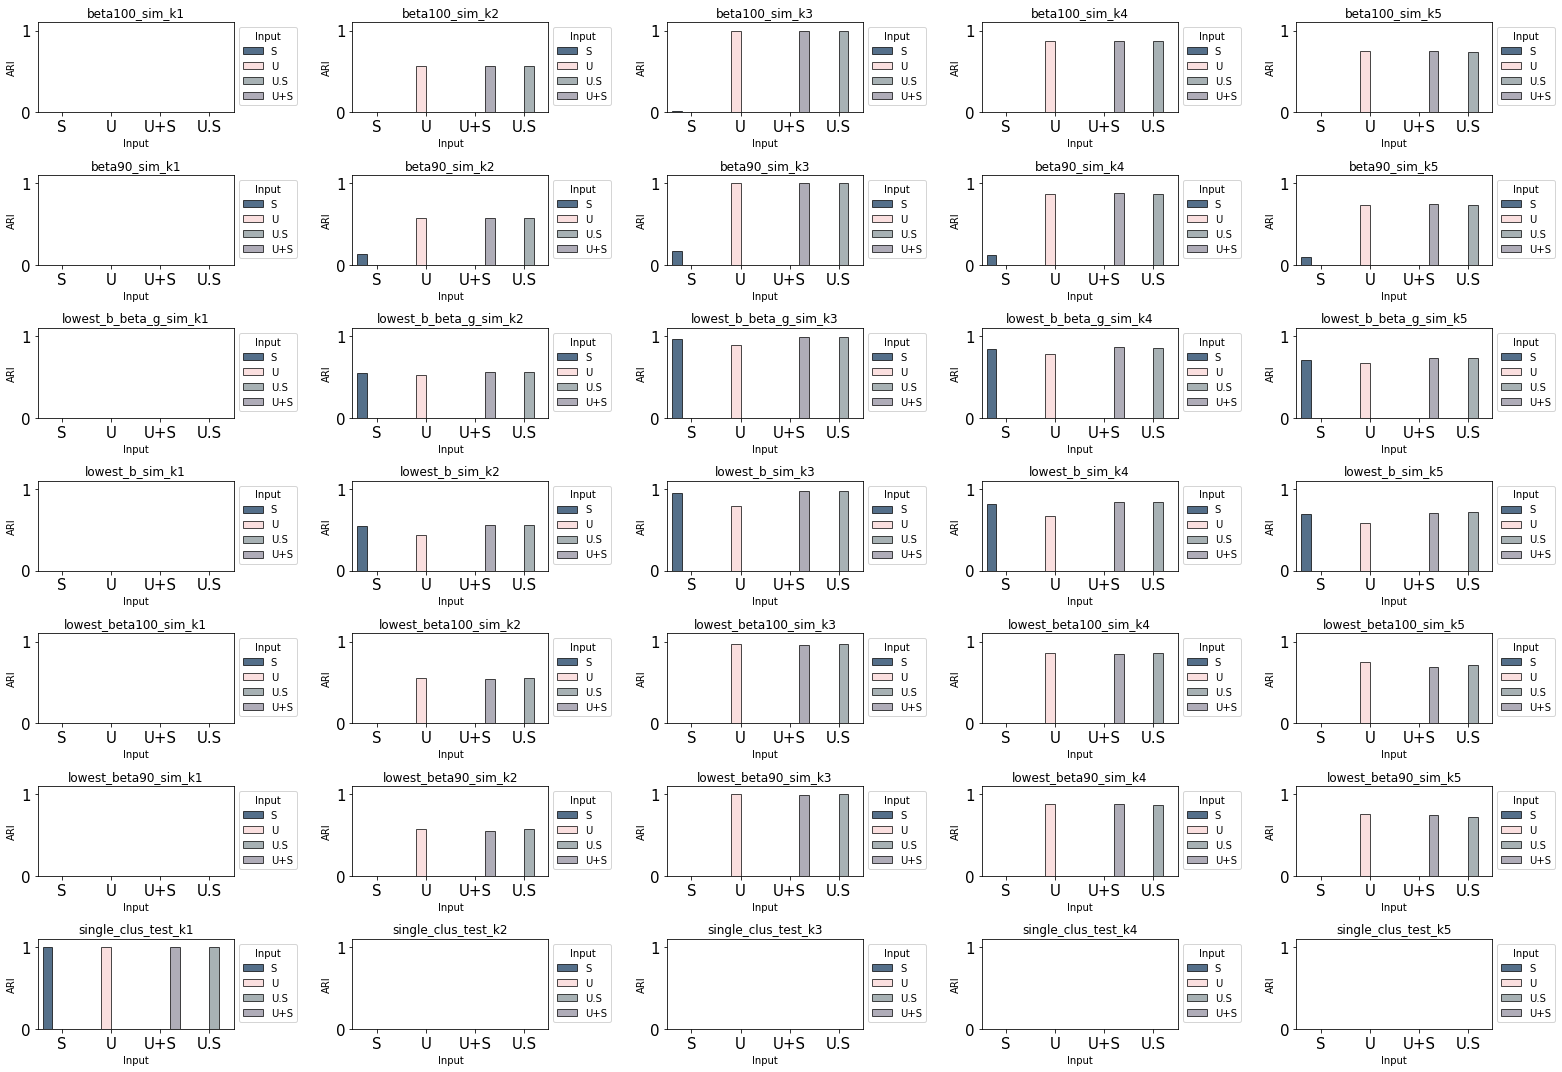

In [452]:
#Make plots of ARI scores for every K-Means run

aris_df = pd.DataFrame()
aris_df['ARI'] = aris
aris_df['Input'] = in_type
aris_df['K'] = kmeans_k
aris_df['Dataset'] = which_data

palette={'S':'#003366','U':'#FFCCCC', 'U+S':'#8c879e','U.S':'#809499'}

num_cols = len(np.unique(aris_df['K']))
fig, ax = plt.subplots(nrows=int(len(np.unique(which_data))/num_cols), ncols=num_cols, figsize=(22,15))

for i in range(len(np.unique(which_data))):
    select = np.unique(which_data)[i]
    sub_ari = aris_df[aris_df.Dataset == select]


    g = sns.barplot(data=sub_ari,x='Input',y='ARI',
                        hue='Input',order=['S','U','U+S','U.S'],
                    palette=palette,edgecolor='black',ax=ax[int(i/num_cols),i%num_cols],
                   alpha=0.7,)
    
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

    ax[int(i/num_cols),i%num_cols].set_title(select)
    ax[int(i/num_cols),i%num_cols].set_ylim((0,1.1))
    
    ax[int(i/num_cols),i%num_cols].tick_params(axis='both', which='major', labelsize=15)
    ax[int(i/num_cols),i%num_cols].tick_params(axis='both', which='minor', labelsize=15)
    
plt.tight_layout()
plt.savefig('ari_sim.pdf')


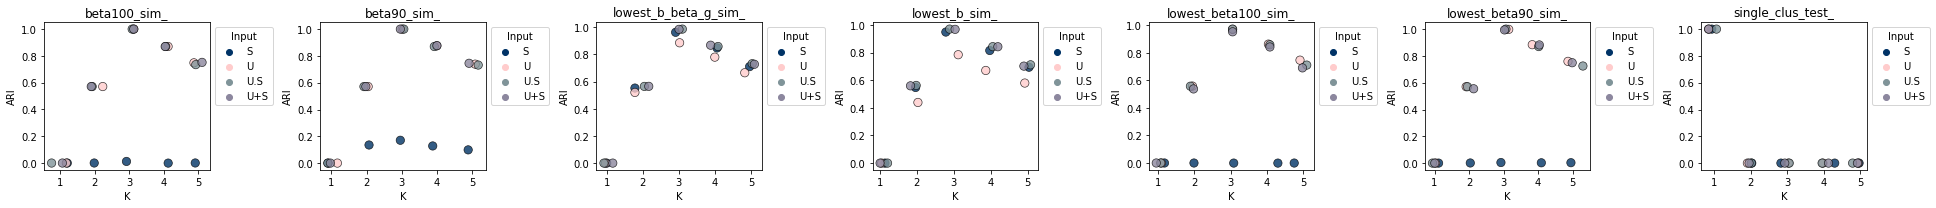

In [464]:
#Make summary ARI plots for each simulation dataset
aris_df['Data_noK'] = [i[:-2] for i in aris_df['Dataset']]


fig, ax = plt.subplots(ncols=int(len(np.unique(which_data))/num_cols), figsize=(27,3))

for i in range(len(np.unique(aris_df['Data_noK']))):
    select = np.unique(aris_df['Data_noK'])[i]
    sub_ari = aris_df[aris_df.Data_noK == select]
    g=sns.scatterplot(data=sub_ari,x=sub_ari.K+np.random.normal(0,0.1,len(sub_ari.K)),
                      y='ARI',hue='Input',palette=palette,
                    s=70,edgecolor='black',alpha=0.8,ax=ax[i])
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    ax[i].set_title(select)
    
plt.tight_layout()
plt.savefig('ari_sim_summary.pdf')


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

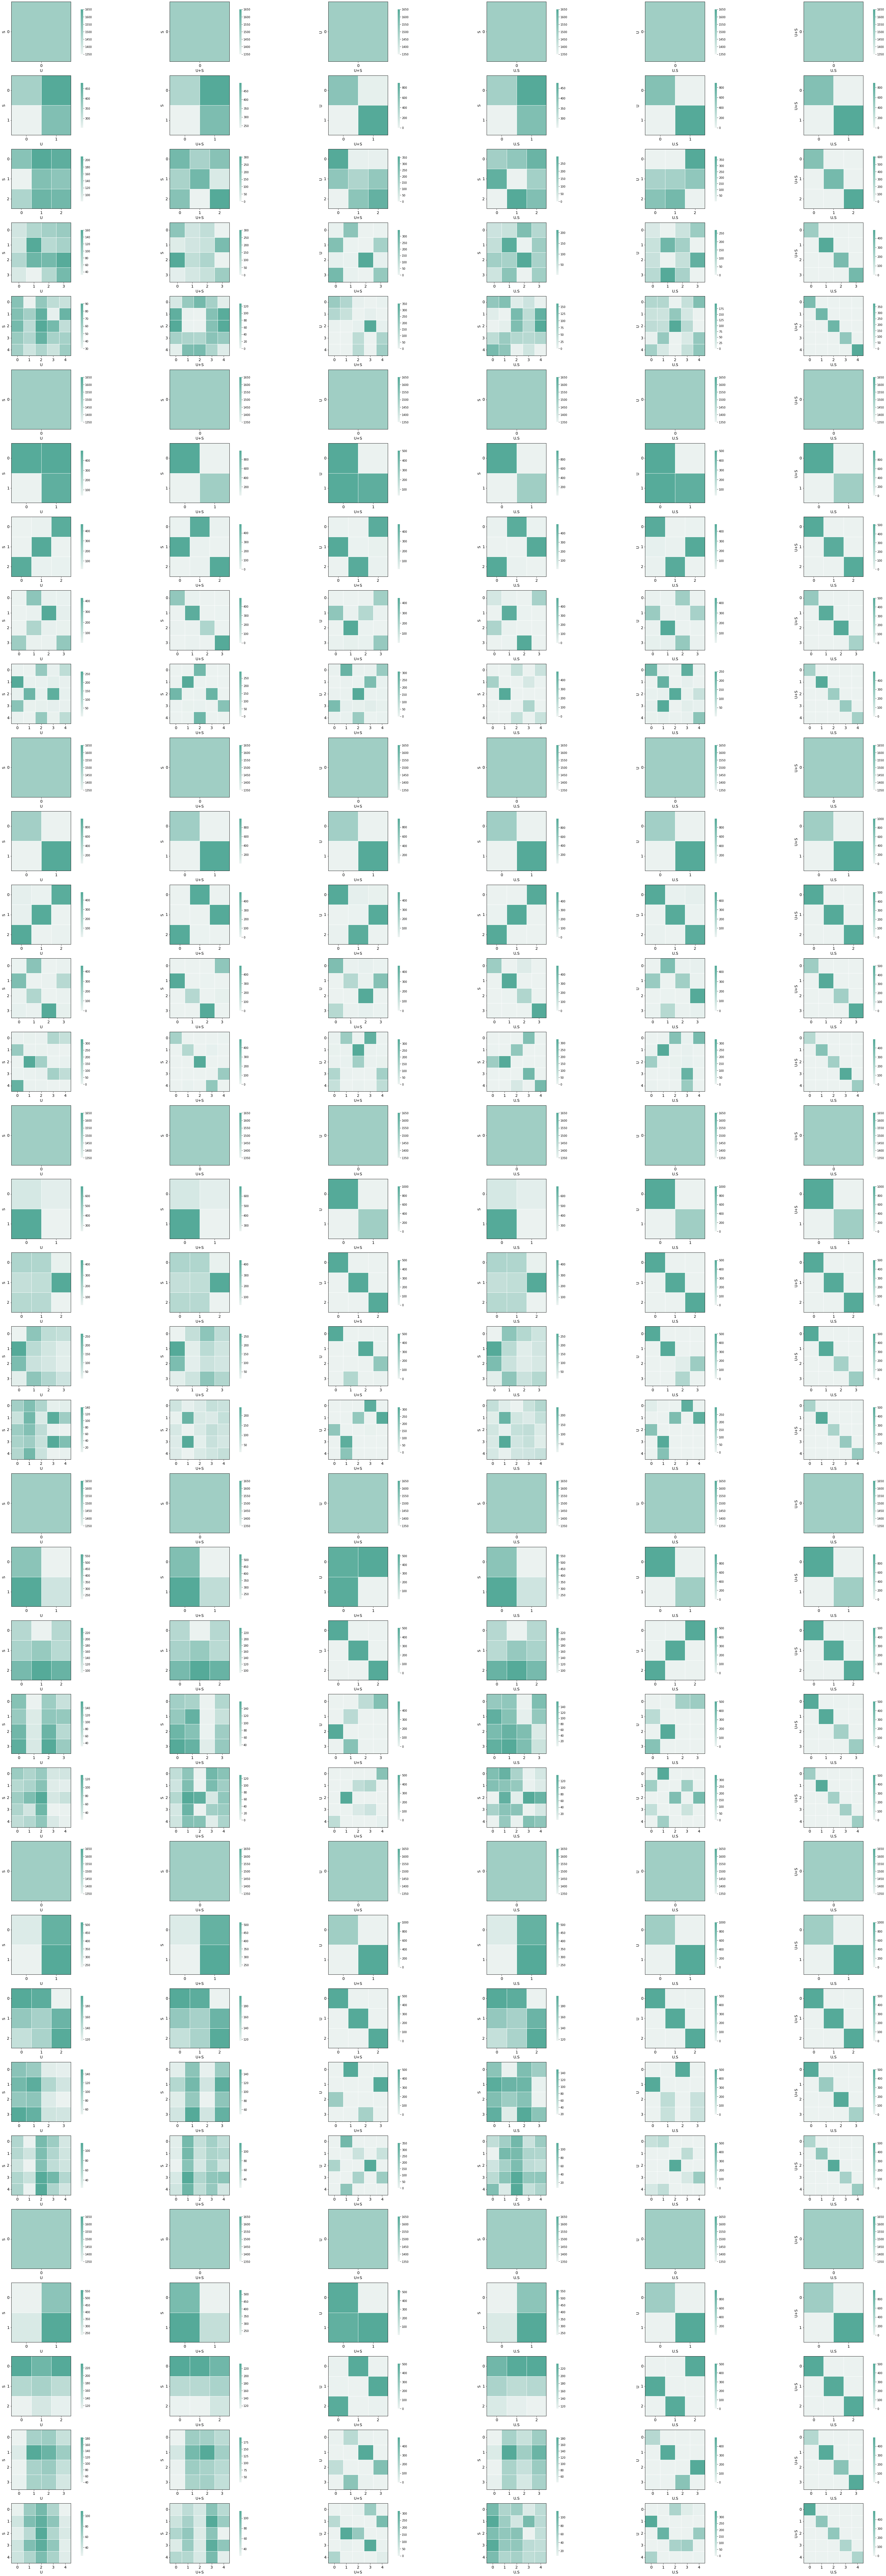

In [466]:
#Compare overlap/concordance of all k-means assignments (S v U,S v U+S,U v U+S)

num_per_set = len(ks)-3

pairs = [(0,1),(0,3),(1,3),(0,2),(1,2),(2,2)]
labs = [('S','U'),('S','U+S'),('U','U+S'),('S','U.S'),('U','U.S'),('U+S','U.S')]
#Plot confmats
fig, ax = plt.subplots(nrows=num_per_set, ncols=len(pairs), figsize=(50,130))
    
for i in range(0,num_per_set):
    
    for j in range(len(pairs)):
        
        p = pairs[j]
        
        assign = all_groups_kmeans[p[1]*(num_per_set)+i]
        true = all_groups_kmeans[p[0]*(num_per_set)+i]

        true_copy = list(true)
        assign_copy = list(assign)

        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    true_copy += [a]
                    assign_copy += [a]


        conmat = confusion_matrix(true_copy, assign_copy)
        val = np.mat(conmat) 
        classnames = list(set(true_copy))
        df_cm = pd.DataFrame(

                val, index=classnames, columns=classnames, 

            )


        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    print(df_cm.shape)
                    df_cm.loc[a,a] = df_cm.loc[a,a]-1


        heatmap = sns.heatmap(df_cm, annot=False, 
                              cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[i,j],
                             square=True,linewidths=1, cbar_kws={"shrink": 0.75})
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
        
        heatmap.axhline(y=0, color='k',linewidth=2)
        heatmap.axhline(y=val.shape[1], color='k',linewidth=2)
        heatmap.axvline(x=0, color='k',linewidth=2)
        heatmap.axvline(x=val.shape[0], color='k',linewidth=2)

        ax[i,j].set_ylabel(labs[j][0],fontsize=14)
        ax[i,j].set_xlabel(labs[j][1],fontsize=14)
        
        ax[i,j].tick_params(axis='both', which='minor', labelsize=14,)
        ax[i,j].tick_params(axis='both', which='major', labelsize=14)
        #ax[i,j].tick_params(axis='x',labelrotation=-90)


plt.tight_layout()  
#plt.show()
plt.savefig('kmeans_conf_sim.pdf')
    

In [35]:
out_names

['single_clus_test',
 'lowest_b_sim',
 'lowest_b_beta_g_sim',
 'beta90_sim',
 'lowest_beta90_sim',
 'beta100_sim',
 'lowest_beta100_sim']

Get what Leiden clusters look like

In [488]:
neigh = 30
all_groups = []
res = [0.25,0.5,1.0,1.5,2.0]*len(out_names) #Test different Leiden resolutions, default of 1 


aris = []
in_type = []
kmeans_k = []
which_data = []



In [489]:
#From https://github.com/scverse/scanpy/blob/ed3b277b2f498e3cab04c9416aaddf97eec8c3e2/scanpy/tools/_leiden.py#L24-L177
for i in range(len(ks)-3):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    #Spliced
    S = search_data.layers[1,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)

    A = kneighbors_graph(S_t, neigh, mode='connectivity', include_self=True)
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=False) #True in scanpy, which is odd
    g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))

    g.es['weight'] = weights
    
    partition_type = la.RBConfigurationVertexPartition
    
    
    part = la.find_partition(g, partition_type, 
                                    weights=np.array(g.es['weight']).astype(np.float64), 
                                    n_iterations=-1, resolution_parameter=res[i])

    all_groups += [np.array(part.membership)]
    
    labels = np.array(part.membership)
    if i <5:
        trues = [0]*500*3
    else:
        trues = [0]*500+[1]*500+[2]*500
    aris += [adjusted_rand_score(labels,trues)]
    in_type += ['S']
    kmeans_k += [res[i]]
    which_data += [dataset_names[which]]
    
    


INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k2/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k3/raw.sd.
INFO

INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta100_sim_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta100_sim_k2/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta100_sim_k3/raw.sd.
INFO:root:Beginning data extractio

In [490]:
for i in range(len(ks)-3):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    #Unspliced
    S = search_data.layers[0,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)

    A = kneighbors_graph(S_t, neigh, mode='connectivity', include_self=True)
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=False) #True in scanpy, which is odd
    g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))

    g.es['weight'] = weights
    
    partition_type = la.RBConfigurationVertexPartition
    
    
    part = la.find_partition(g, partition_type, 
                                    weights=np.array(g.es['weight']).astype(np.float64), 
                                    n_iterations=-1, resolution_parameter=res[i])

    all_groups += [np.array(part.membership)]
    
    labels = np.array(part.membership)
    if i <5:
        trues = [0]*500*3
    else:
        trues = [0]*500+[1]*500+[2]*500
    aris += [adjusted_rand_score(labels,trues)]
    in_type += ['U']
    kmeans_k += [res[i]]
    which_data += [dataset_names[which]]
    

INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k2/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k3/raw.sd.
INFO

INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta100_sim_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta100_sim_k2/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta100_sim_k3/raw.sd.
INFO:root:Beginning data extractio

In [491]:
for i in range(len(ks)-3):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    
    U = search_data.layers[0,:,:]
    U_t = U.T
    S = search_data.layers[1,:,:]
    S_t = S.T
    
    concat = np.concatenate((U_t, S_t), axis=1)

    tots = np.sum(concat,axis=1)
    divids = (1e4/tots)[:,None]
    concat = concat*divids
    concat = np.log1p(concat)
    
    A = kneighbors_graph(concat, neigh, mode='connectivity', include_self=True)
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=False) #True in scanpy, which is odd
    g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))

    g.es['weight'] = weights
    
    partition_type = la.RBConfigurationVertexPartition
    
    
    part = la.find_partition(g, partition_type, 
                                    weights=np.array(g.es['weight']).astype(np.float64), 
                                    n_iterations=-1, resolution_parameter=res[i])

    all_groups += [np.array(part.membership)]
    
    labels = np.array(part.membership)
    if i <5:
        trues = [0]*500*3
    else:
        trues = [0]*500+[1]*500+[2]*500
    aris += [adjusted_rand_score(labels,trues)]
    in_type += ['U.S']
    kmeans_k += [res[i]]
    which_data += [dataset_names[which]]
    
    

INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k2/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k3/raw.sd.
INFO

INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta100_sim_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta100_sim_k2/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta100_sim_k3/raw.sd.
INFO:root:Beginning data extractio

In [492]:
for i in range(len(ks)-3):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    
    U = search_data.layers[0,:,:]
    U_t = U.T
    S = search_data.layers[1,:,:]
    S_t = S.T
    
    concat = U_t+S_t

    tots = np.sum(concat,axis=1)
    divids = (1e4/tots)[:,None]
    concat = concat*divids
    concat = np.log1p(concat)
    
    A = kneighbors_graph(concat, neigh, mode='connectivity', include_self=True)
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=False) #True in scanpy, which is odd
    g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))

    g.es['weight'] = weights
    
    partition_type = la.RBConfigurationVertexPartition
    
    
    part = la.find_partition(g, partition_type, 
                                    weights=np.array(g.es['weight']).astype(np.float64), 
                                    n_iterations=-1, resolution_parameter=res[i])

    all_groups += [np.array(part.membership)]
    
    labels = np.array(part.membership)
    if i <5:
        trues = [0]*500*3
    else:
        trues = [0]*500+[1]*500+[2]*500
    aris += [adjusted_rand_score(labels,trues)]
    in_type += ['U+S']
    kmeans_k += [res[i]]
    which_data += [dataset_names[which]]
    
    

INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k2/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: single_clus_test_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/single_clus_test_k3/raw.sd.
INFO

INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k1
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta100_sim_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k2
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta100_sim_k2/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: beta100_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta100_sim_k3/raw.sd.
INFO:root:Beginning data extractio

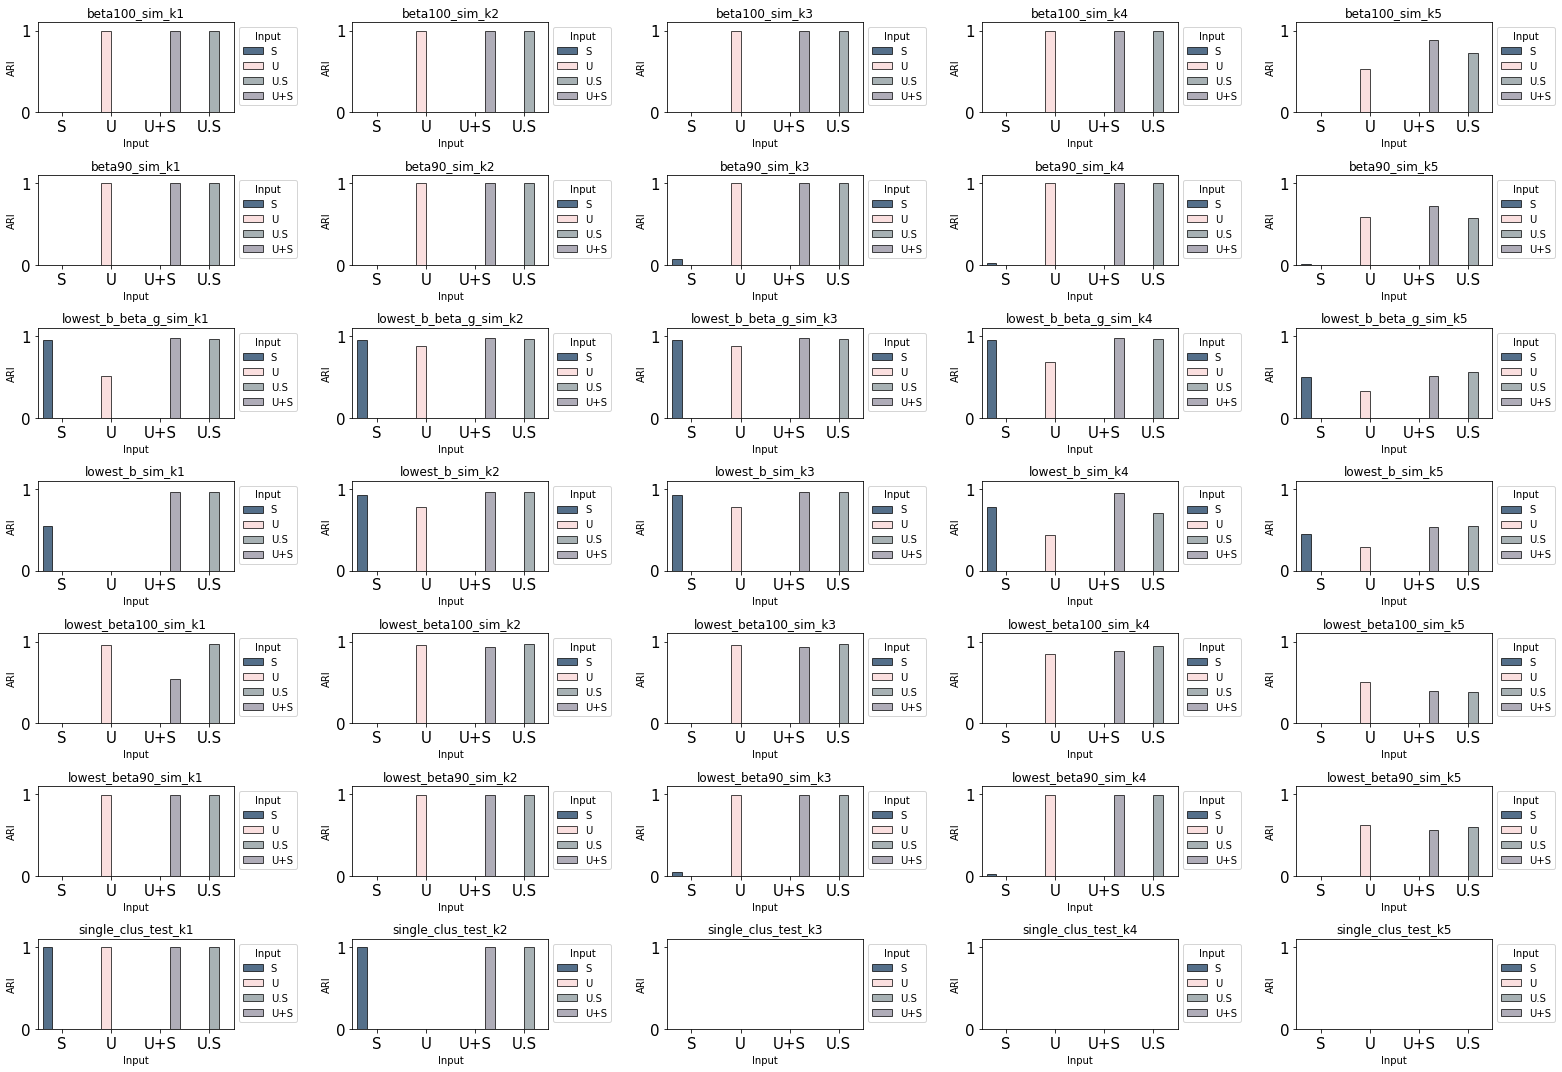

In [494]:
#Make plots of ARI scores for every K-Means run

aris_df = pd.DataFrame()
aris_df['ARI'] = aris
aris_df['Input'] = in_type
aris_df['K'] = kmeans_k
aris_df['Dataset'] = which_data

palette={'S':'#003366','U':'#FFCCCC', 'U+S':'#8c879e','U.S':'#809499'}

num_cols = len(np.unique(aris_df['K']))
fig, ax = plt.subplots(nrows=int(len(np.unique(which_data))/num_cols), ncols=num_cols, figsize=(22,15))

for i in range(len(np.unique(which_data))):
    select = np.unique(which_data)[i]
    sub_ari = aris_df[aris_df.Dataset == select]
    


    g = sns.barplot(data=sub_ari,x='Input',y='ARI',order=['S','U','U+S','U.S'],
                        hue='Input',palette=palette,edgecolor='black',ax=ax[int(i/num_cols),i%num_cols],
                   alpha=0.7)

    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

    ax[int(i/num_cols),i%num_cols].set_title(select)
    ax[int(i/num_cols),i%num_cols].set_ylim((0,1.1))
    
    ax[int(i/num_cols),i%num_cols].tick_params(axis='both', which='major', labelsize=15)
    ax[int(i/num_cols),i%num_cols].tick_params(axis='both', which='minor', labelsize=15)
    
plt.tight_layout()
plt.savefig('ari_leiden_sim.pdf')

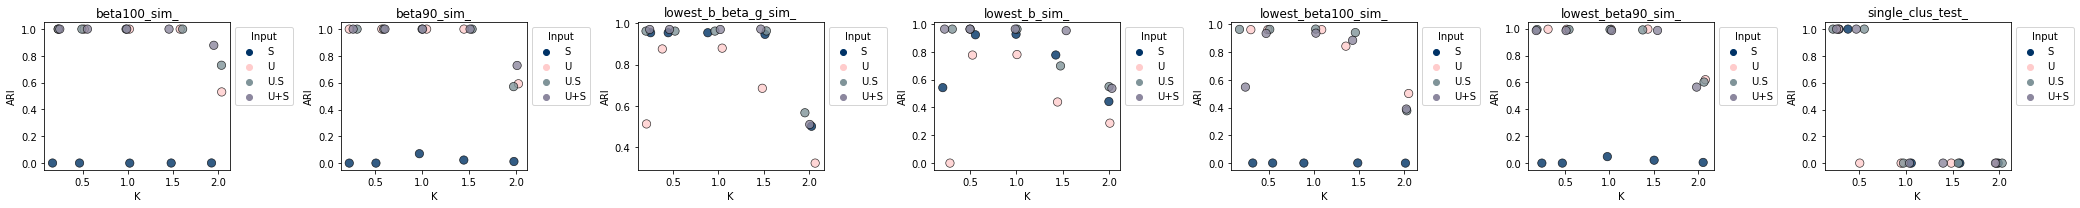

In [495]:
#Make summary ARI plots for each simulation dataset
aris_df['Data_noK'] = [i[:-2] for i in aris_df['Dataset']]


fig, ax = plt.subplots(ncols=int(len(np.unique(which_data))/num_cols), figsize=(29,3))

for i in range(len(np.unique(aris_df['Data_noK']))):
    select = np.unique(aris_df['Data_noK'])[i]
    sub_ari = aris_df[aris_df.Data_noK == select]
    g=sns.scatterplot(data=sub_ari,x=sub_ari.K+np.random.normal(0,0.05,len(sub_ari.K)),
                    y='ARI',hue='Input',palette=palette,
                    s=70,edgecolor='black',alpha=0.8,ax=ax[i])
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    ax[i].set_title(select)
    
plt.tight_layout()
plt.savefig('ari_leiden_sim_summary.pdf')


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(2, 2)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(8, 8)
(8, 8)
(8, 8)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(8, 8)
(8, 8)
(8, 8)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(24, 24)
(24, 24)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(24, 24)
(24, 24)
(24, 24)
(24, 24)
(24, 24)
(24, 24)
(24, 24)
(24, 24)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(23, 23)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(23, 23)
(23, 23)
(23, 23)
(23, 23)
(23, 23)
(23, 23)
(23, 23)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(39, 39)
(39, 39)
(39, 39)
(39, 39)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(39, 39)
(39, 39)
(39, 39)
(39, 39)
(39, 39)
(39, 39)
(39, 39)
(39, 39)
(39, 39)
(39, 39)
(39, 39)
(39, 39)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(36, 36)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(36, 36)
(36, 36)
(36, 36)
(36, 36)
(36, 36)
(36, 36)
(36, 36)
(36, 36)
(36, 36)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(3, 3)
(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(3, 3)
(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(16, 16)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(16, 16)
(16, 16)
(16, 16)
(16, 16)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(17, 17)
(17, 17)
(17, 17)
(17, 17)
(17, 17)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(17, 17)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(15, 15)
(15, 15)
(15, 15)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(13, 13)
(13, 13)
(13, 13)
(13, 13)
(13, 13)
(13, 13)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(8, 8)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(16, 16)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(16, 16)
(16, 16)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(15, 15)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(3, 3)
(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(3, 3)
(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(3, 3)
(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(3, 3)
(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(3, 3)
(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(3, 3)
(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(6, 6)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(3, 3)
(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(3, 3)
(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(3, 3)
(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(3, 3)
(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(3, 3)
(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(3, 3)
(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(8, 8)
(8, 8)
(8, 8)
(8, 8)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(8, 8)
(8, 8)
(8, 8)
(8, 8)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(18, 18)
(18, 18)
(18, 18)
(18, 18)
(18, 18)
(18, 18)
(18, 18)
(18, 18)
(18, 18)
(18, 18)
(18, 18)
(18, 18)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(11, 11)
(11, 11)
(11, 11)
(11, 11)
(11, 11)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(3, 3)
(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(3, 3)
(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(3, 3)
(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(3, 3)
(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(3, 3)
(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(3, 3)
(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(3, 3)
(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(2, 2)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(3, 3)
(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(3, 3)
(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(3, 3)
(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(3, 3)
(3, 3)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(9, 9)
(9, 9)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(14, 14)
(14, 14)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(15, 15)
(15, 15)
(15, 15)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(15, 15)


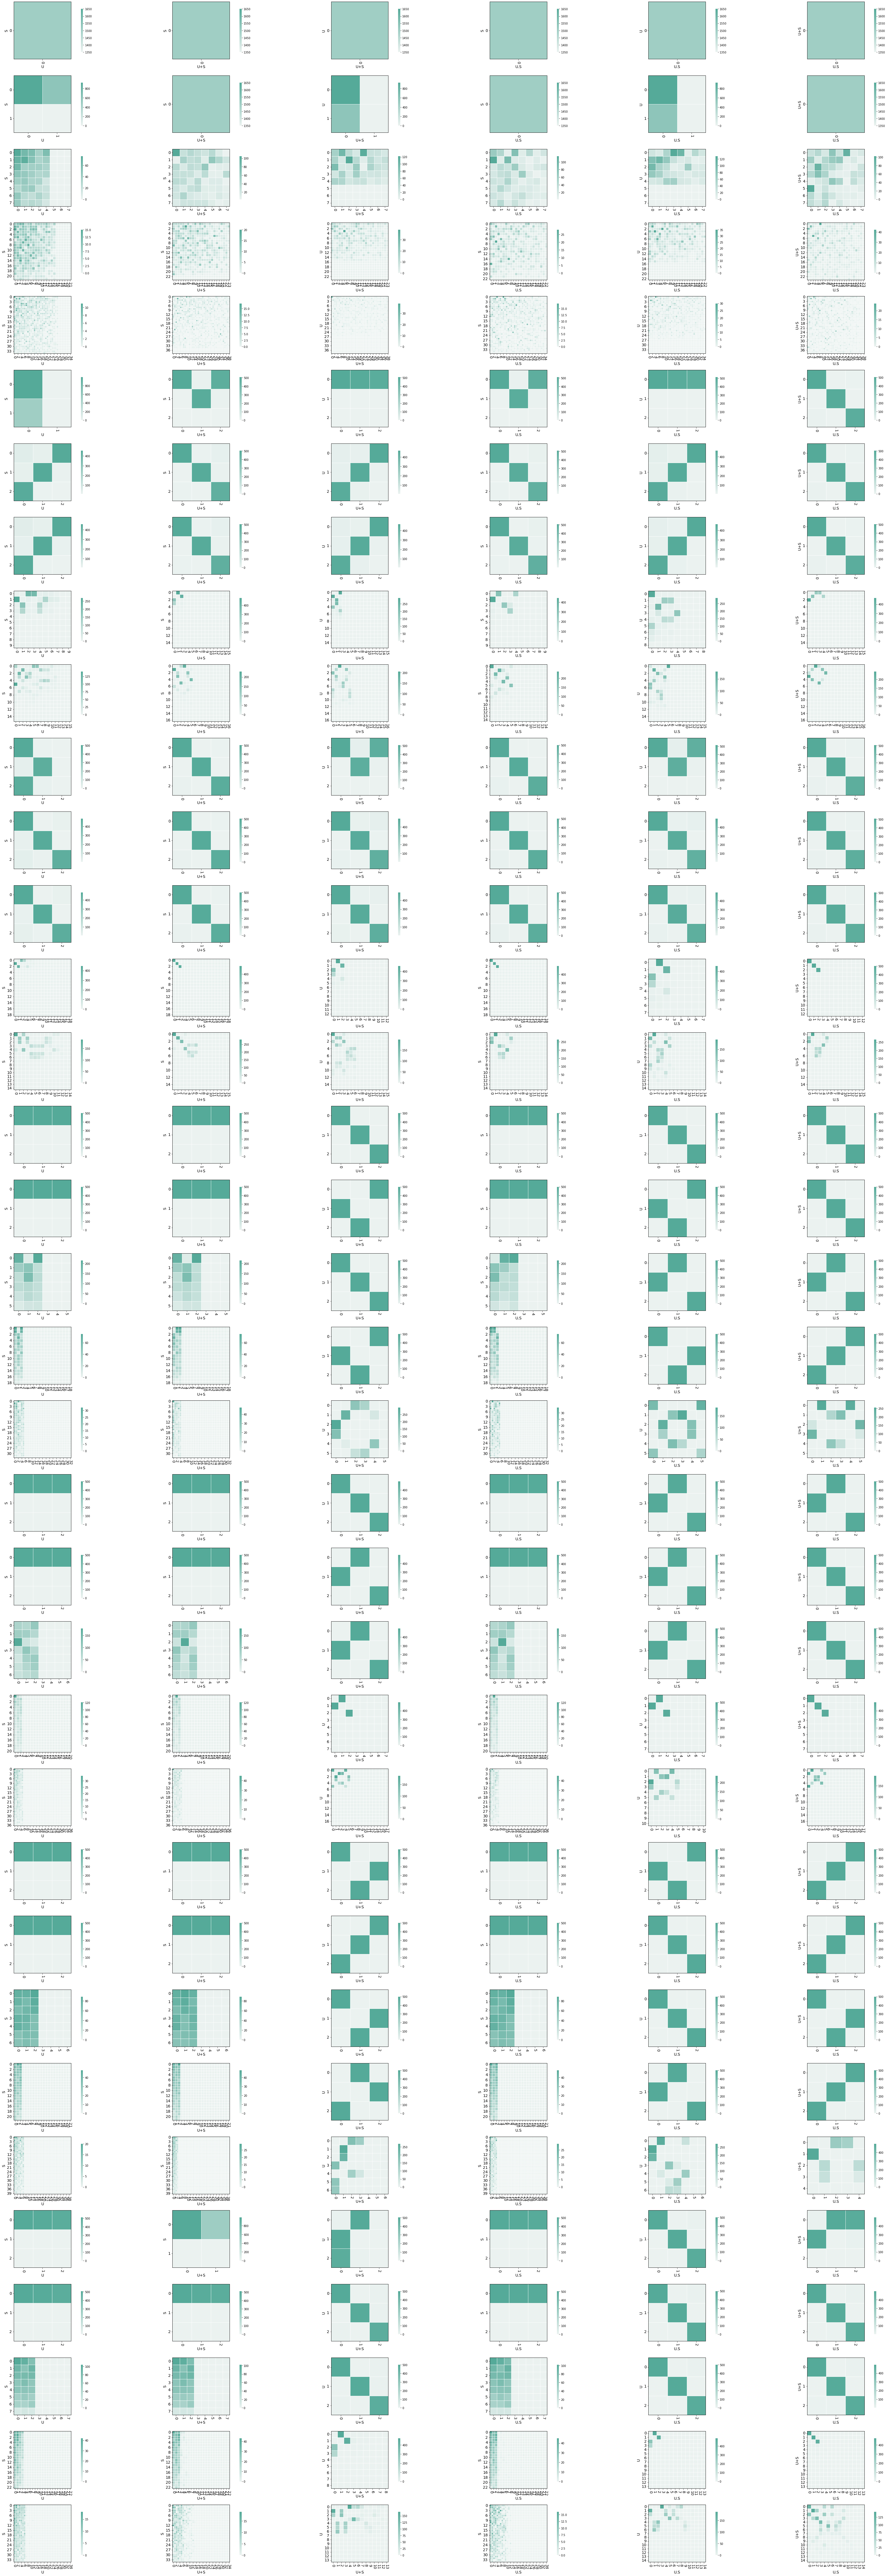

In [496]:
#compare overlap of all leiden assignments (S v U,S v U+S,U v U+S)

num_per_set = len(ks)-3

pairs = [(0,1),(0,3),(1,3),(0,2),(1,2),(3,2)]
labs = [('S','U'),('S','U+S'),('U','U+S'),('S','U.S'),('U','U.S'),('U+S','U.S')]
#Plot confmats
fig, ax = plt.subplots(nrows=num_per_set, ncols=len(pairs), figsize=(50,130))
    
for i in range(0,num_per_set):
    
    for j in range(len(pairs)):
        
        p = pairs[j]
        
        assign = all_groups[p[1]*(num_per_set)+i]
        true = all_groups[p[0]*(num_per_set)+i]

        true_copy = list(true)
        assign_copy = list(assign)

        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    true_copy += [a]
                    assign_copy += [a]


        conmat = confusion_matrix(true_copy, assign_copy)
        val = np.mat(conmat) 
        classnames = list(set(true_copy))
        df_cm = pd.DataFrame(

                val, index=classnames, columns=classnames, 

            )


        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    print(df_cm.shape)
                    df_cm.loc[a,a] = df_cm.loc[a,a]-1


        heatmap = sns.heatmap(df_cm, annot=False, 
                                  cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[i,j],
                                 square=True,linewidths=1, cbar_kws={"shrink": 0.75})
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
        
        heatmap.axhline(y=0, color='k',linewidth=2)
        heatmap.axhline(y=val.shape[1], color='k',linewidth=2)
        heatmap.axvline(x=0, color='k',linewidth=2)
        heatmap.axvline(x=val.shape[0], color='k',linewidth=2)

        ax[i,j].set_ylabel(labs[j][0],fontsize=14)
        ax[i,j].set_xlabel(labs[j][1],fontsize=14)
        
        ax[i,j].tick_params(axis='both', which='minor', labelsize=14,)
        ax[i,j].tick_params(axis='both', which='major', labelsize=14)
        ax[i,j].tick_params(axis='x',labelrotation=-90)

plt.tight_layout()
#plt.show()
plt.savefig('leiden_conf_sim.pdf')
    

In [32]:
out_names

['single_clus_test',
 'lowest_b_sim',
 'lowest_b_beta_g_sim',
 'beta90_sim',
 'lowest_beta90_sim',
 'beta100_sim',
 'lowest_beta100_sim']

## **Analysis of Results**

In [409]:
#Plot cluster concordance with true labels, and distribution of clusters 
def vis_assign(true,assign,title='',figsize=(18, 5),save_file=None):
    true_copy = list(true)
    assign_copy = list(assign)
    if np.max(assign) > np.max(true): 
        for a in np.unique(assign):
            if a > np.max(true):
                true_copy += [a]
                assign_copy += [a]
    true_copy = np.array(true_copy)
    assign_copy = np.array(assign_copy)
    
    conmat = confusion_matrix(true_copy, assign_copy)
    val = np.mat(conmat) 
    classnames = list(set(true_copy))
    df_cm = pd.DataFrame(

            val, index=classnames, columns=classnames, 

        )
    
    if np.max(assign) > np.max(true): 
        for a in np.unique(assign):
            if a > np.max(true):
                print(df_cm.shape)
                df_cm.loc[a,a] = df_cm.loc[a,a]-1

    #Plot assignment distributions
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    g= sns.histplot(x=assign,hue=true, kde=False,ax=ax[0],
                    palette='tab20',multiple="dodge",
                    discrete=True)
    ax[0].set_xlabel('MM Assignment')
    ax[0].set_title(title)
    
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

    
    #Plot confusion matrix
    heatmap = sns.heatmap(df_cm, annot=True, cmap=sns.color_palette("light:#5A9", as_cmap=True),
                          ax=ax[1],square=True,linewidths=1, cbar_kws={"shrink": 0.5})
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',
                                 fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0,
                                fontsize=15)
    
    heatmap.axhline(y=0, color='k',linewidth=2)
    heatmap.axhline(y=val.shape[1], color='k',linewidth=2)
    heatmap.axvline(x=0, color='k',linewidth=2)
    heatmap.axvline(x=val.shape[0], color='k',linewidth=2)

    ax[1].set_ylabel('True State',fontsize=15)
    ax[1].set_xlabel('Assigned State',fontsize=15)
    
    plt.tight_layout()
    if save_file is None:
        plt.show()
    else:
        plt.savefig(save_file)

    

In [237]:
#Plot  aics and loss over time for each k iteration

def vis_metrics(results,title,ks,figsize=(18, 5),s=50,save_file=None):
    num_ks = len(results)
    sets = []
    nlls = []
    res = pd.DataFrame()
    aics = pd.DataFrame()
    klds = pd.DataFrame()
    
    aic = []
    fin_k = []
    kls = []
    
    epoch = len(results[0].all_qs)
    epos = list(range(1,epoch+1))*num_ks
    
    for i in range(num_ks):
        
        nlls += list(-1*np.array(results[i].all_qs))
        sets += [ks[i]]*epoch
        aic += [results[i].aic] #-2*n_cells*clus
        fin_k += [len(np.unique(results[i].assigns))]
        #kls += [np.mean([np.mean(results[i].klds[:,k]) for k in np.unique(results[i].assigns)])]
        
        kls += list(np.mean(np.sum(np.array(results[i].all_klds)[:,:,list(np.unique(results[i].assigns))],axis=1),axis=1))
        
        
    
    
    
    res['NLL'] = nlls
    res['KLD'] = kls
    res['epoch'] = epos
    res['setting'] = [str(j) for j in sets]
    
    aics['AIC'] = aic
    aics['k'] = [str(j) for j in ks ]
    aics['fin_k'] = fin_k
    

    
    
    #Plot klds over time
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    sns.lineplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',
                   alpha=0.7,legend=False)
    g=sns.scatterplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[0].set_xlabel('Epoch',fontsize=12)
    ax[0].set_ylabel('NLL',fontsize=12)
    ax[0].set_title(title)
    ax[0].legend(
          title='Set K')
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    
    
    #Plot klds
    sns.lineplot(data=res,x='epoch',y='KLD',hue='setting', 
                    ax=ax[1],palette='Dark2',
                   alpha=0.7,legend=False)
    g2=sns.scatterplot(data=res,x='epoch',y='KLD',hue='setting', 
                    ax=ax[1],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[1].set_xlabel('Epoch',fontsize=12)
    ax[1].set_ylabel('KLD',fontsize=12)
    ax[1].legend(
          title='Set K')
    sns.move_legend(g2, "upper left", bbox_to_anchor=(1, 1))

    
    
    #Plot aics
    g3=sns.scatterplot(data=aics,x='fin_k',y='AIC',hue='k', ax=ax[2],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[2].set_xlabel('Final K',fontsize=12)
    ax[2].set_ylabel('-AIC',fontsize=12)
    ax[2].legend(
          title='Set K')
    sns.move_legend(g3, "upper left", bbox_to_anchor=(1, 1))
    
    
    plt.tight_layout()
    if save_file is None:
        plt.show()
    else:
        plt.savefig(save_file)
    
    
    


In [410]:
#Mixture Model results
import pickle 
results = [i+'/Bursty_Poisson_1x1/grid_point_0.gp' for i in dataset_strings[:-3]]
grid_point_results = []
for r in results:
    with open(r, "rb") as ipfs:
        grid_point_results += [pickle.load(ipfs)]

    

In [411]:
titles_to_save = ['lowest_b_sim_k3/Bursty_Poisson_1x1','beta90_sim_k3/Bursty_Poisson_1x1']

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


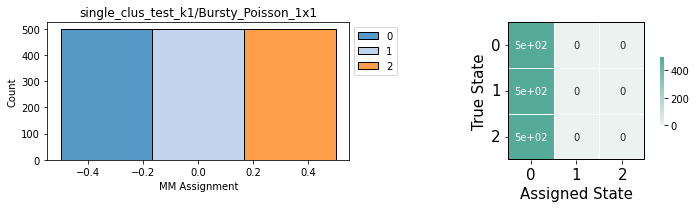

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


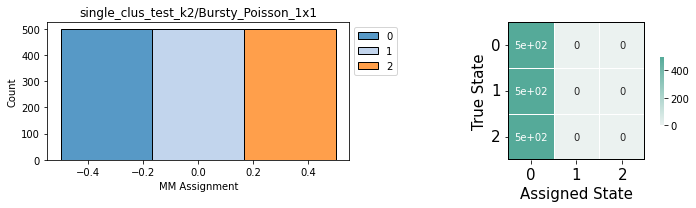

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


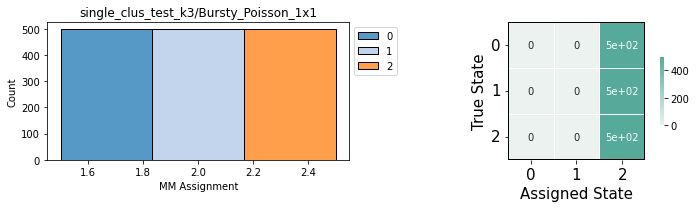

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


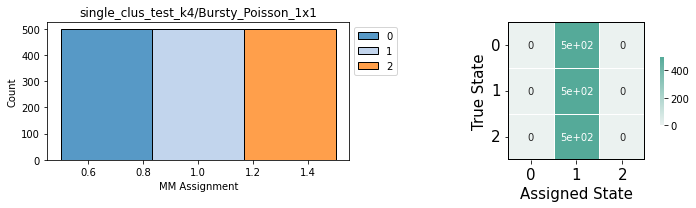

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


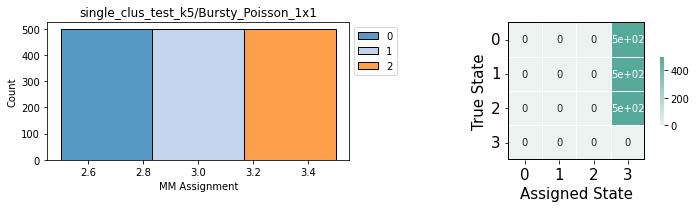

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


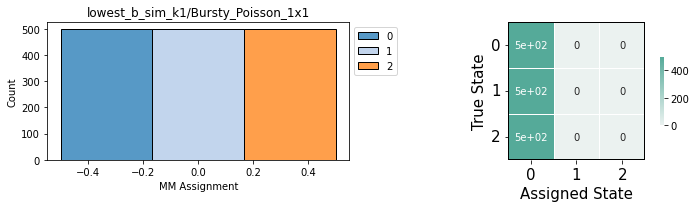

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


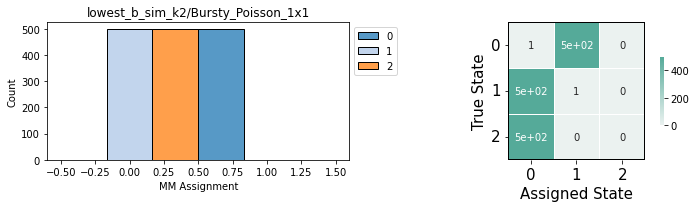

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


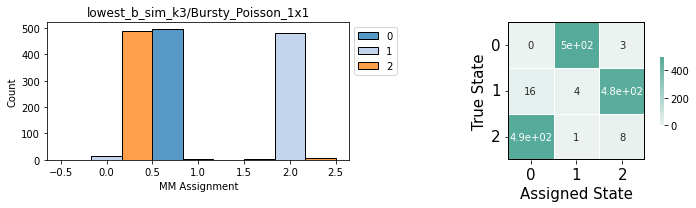

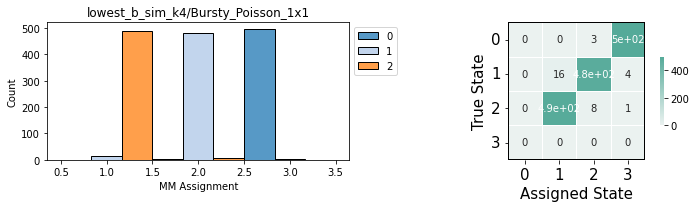

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


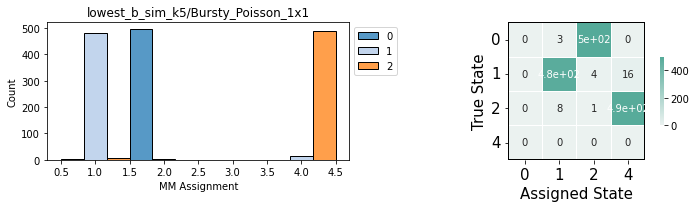

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


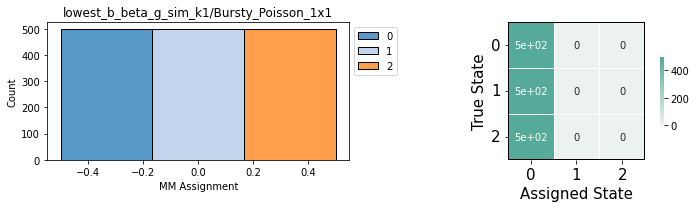

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


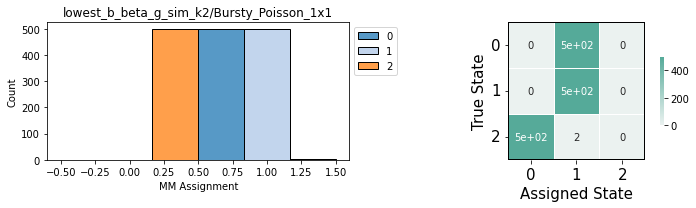

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


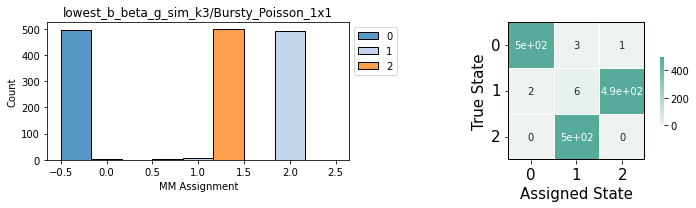

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


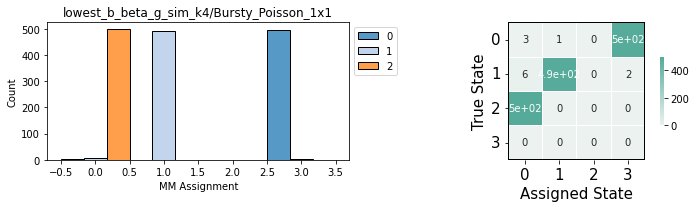

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


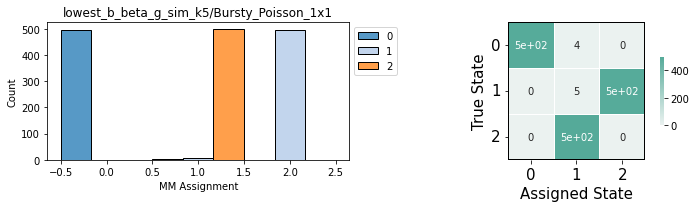

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


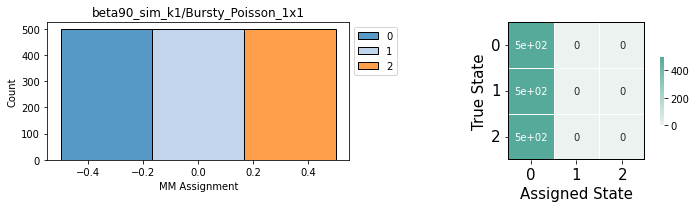

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


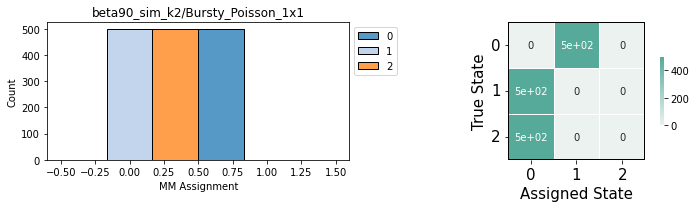

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


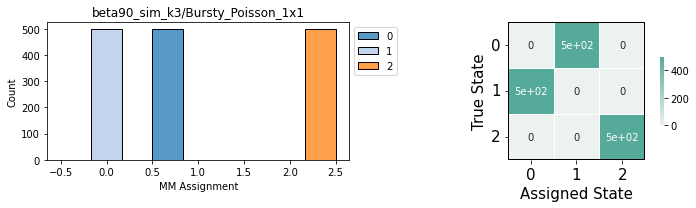

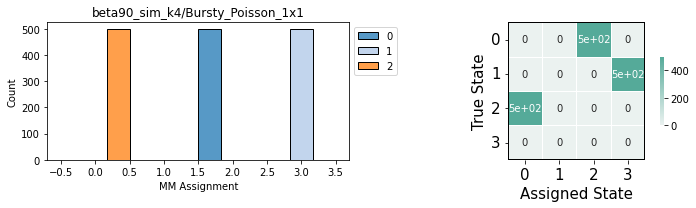

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(5, 5)
(5, 5)


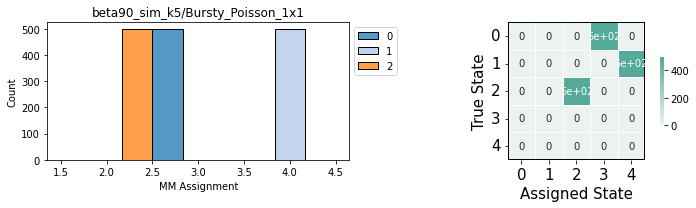

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


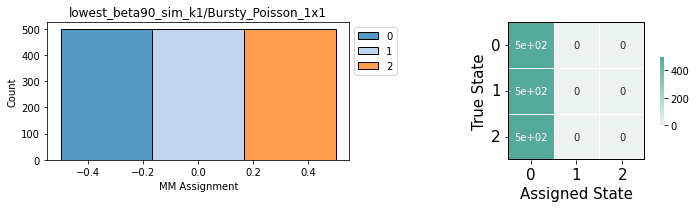

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


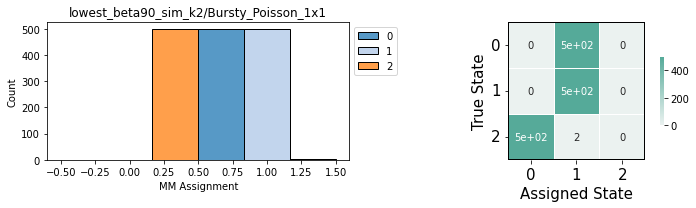

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


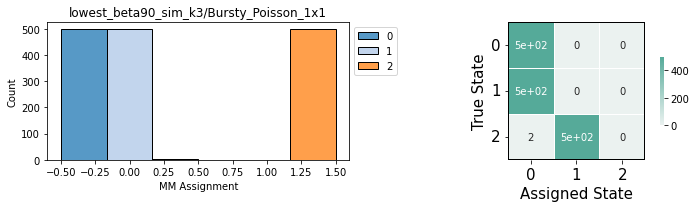

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


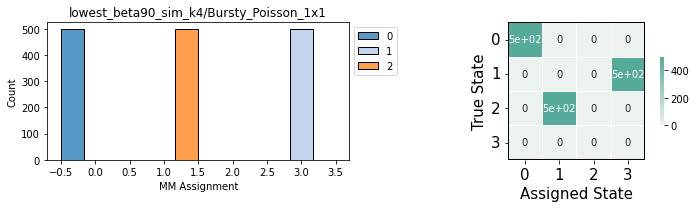

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


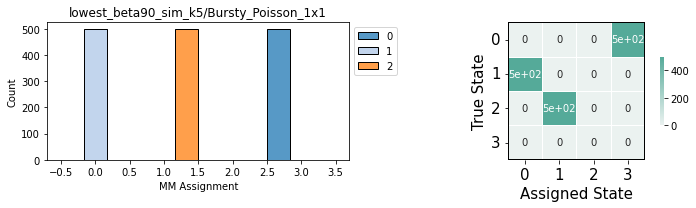

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


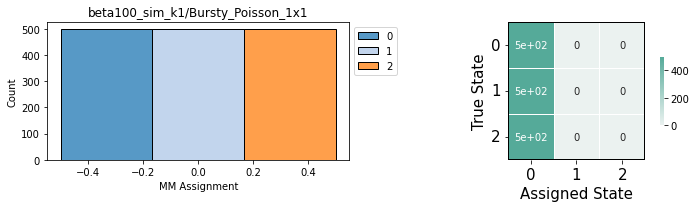

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


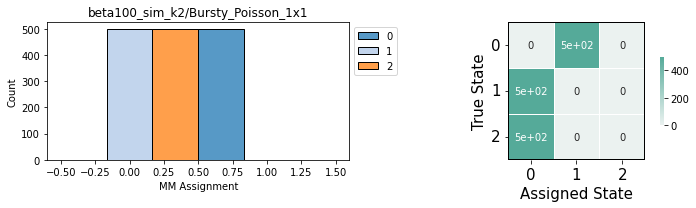

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


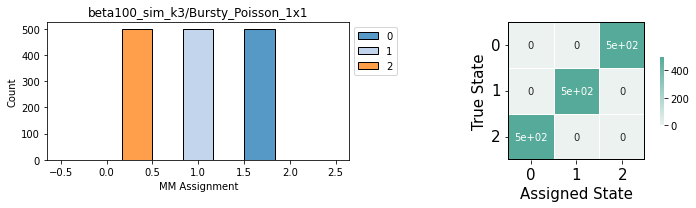

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


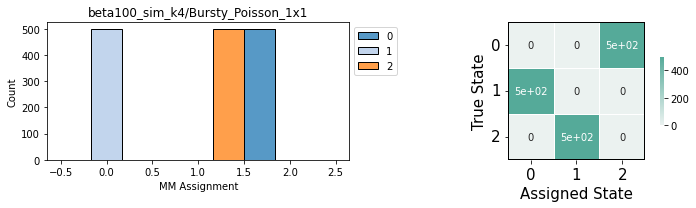

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


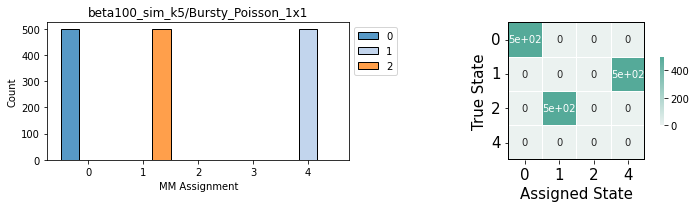

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


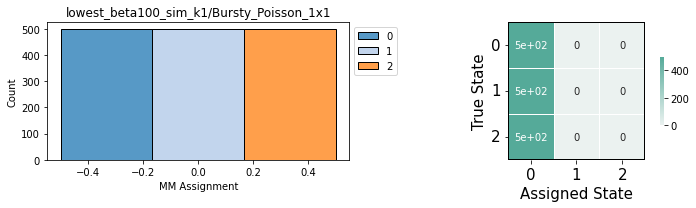

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


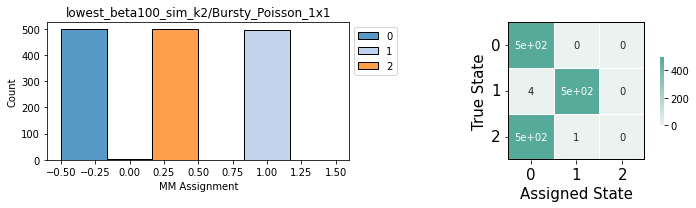

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


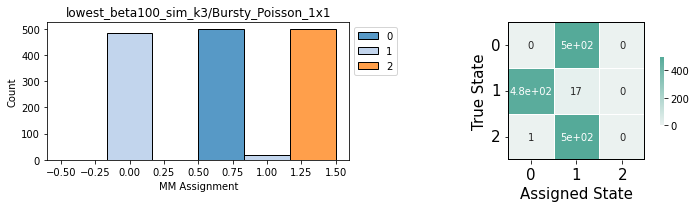

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


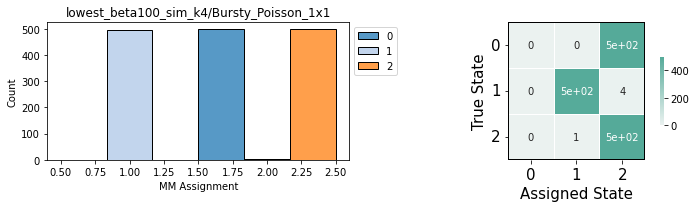

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(5, 5)
(5, 5)


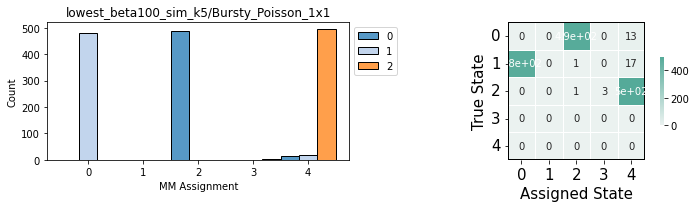

In [412]:
for r in grid_point_results:
    title = r.inference_string.replace('./fits/gg_230509_025_simTests_MM_1/','') #./fits/gg_230411_025_simTests_MM_1/
    if title in titles_to_save:
        file_out = title.replace('/','_')+'.pdf'
    else:
        file_out=None
    vis_assign(np.array(all_assigns),r.assigns,title,figsize=(10,3),save_file = file_out) 



In [421]:
titles_to_save = ['single_clus_test','lowest_b_sim','beta90_sim']

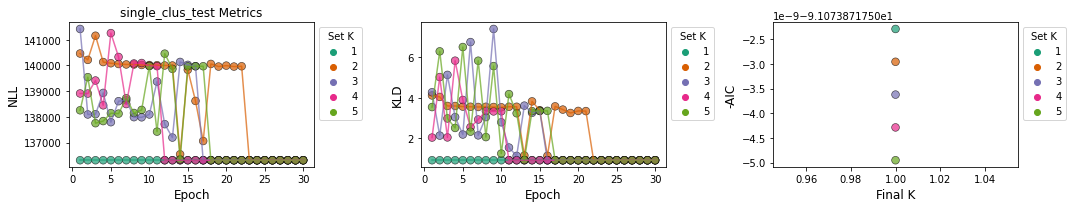

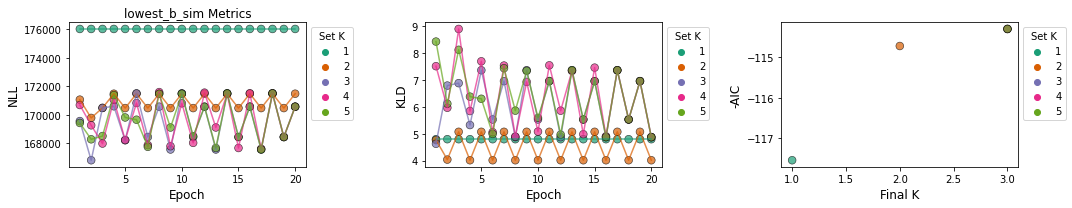

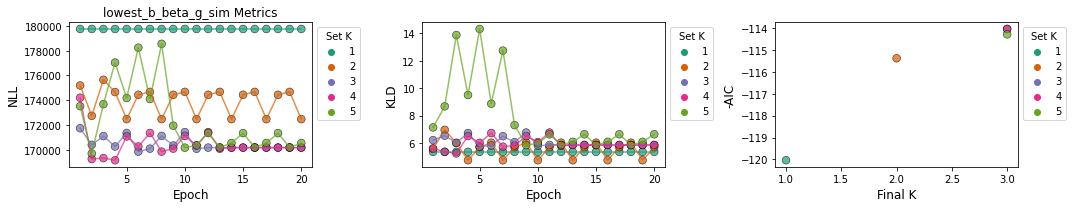

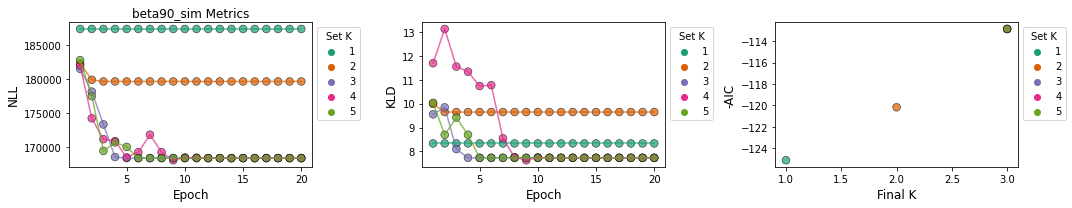

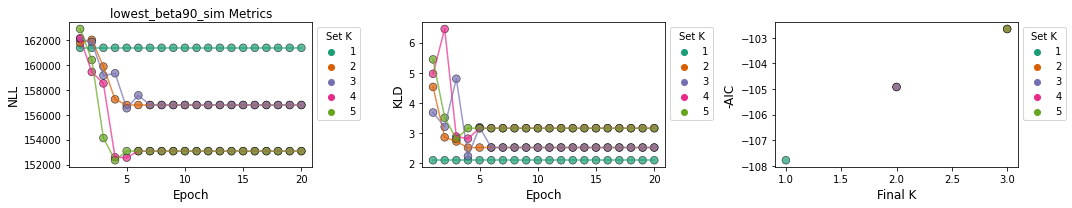

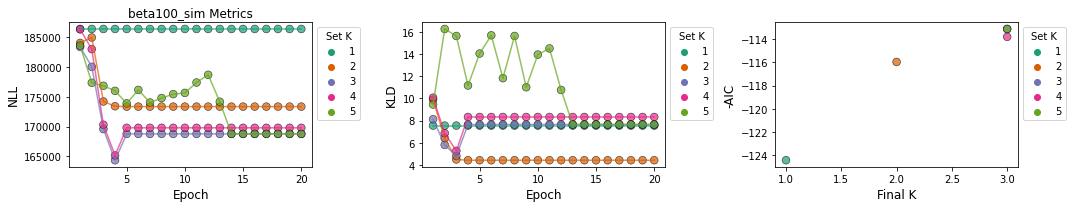

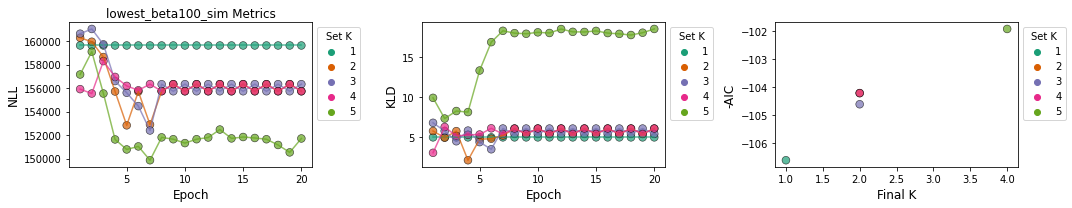

In [422]:

for i in range(0, len(grid_point_results), 5):
    r = grid_point_results[i:i+5]
    title = dataset_meta[i]+' Metrics'
    if dataset_meta[i] in titles_to_save:
        file_out = title.replace(' ','_')+'.pdf'
    else:
        file_out=None
        
    vis_metrics(r,title,ks[i:i+5],figsize=(15,3),s=60,save_file = file_out)

In [ ]:
for i in range(len(dataset_names)):
    print(str(i)+': '+dataset_names[i])

### **Compare meK-Means Fits to Simulation and (Standard) Monod Fits**

In [243]:
col_all_par = '#4472C4'
col_b = '#1B9AAA'
col_beta = '#9fcbee'
col_gamma ='#3C50B1'
col_expr = '#9299A0'


In [241]:
def check_at_bounds(phys_params,thr=0.01):
    #Check for genes where parameter fits are close to boundary of grid
    x = np.any(np.logical_or(
        np.array(phys_lb)+thr > phys_params,
        np.array(phys_ub)-thr < phys_params) ,1)
    return x

In [242]:
#Check results for burst size > 1
def get_logL(ps,counts,search_data):
    bs = ps[:,0]
    betas = ps[:,1]
    gammas = ps[:,2]
    
    EPS=1e-15
    
    logL = 0
    
    for g in range(n_genes):
        

        x = counts[:,g,:].T
        x = x.astype(int)
        
        b = 10**bs[g]
        beta = 10**betas[g]
        gamma = 10**gammas[g]
        
        
        
        g_len = lens_sub[g]

        lam_n = 10**((glob_samp[0]) + np.log10(g_len))
        lam_m = 10**(glob_samp[1])

        p = np.log10(np.asarray([b,beta,gamma])) #[b,beta,gamma]
        burst_model = BurstModel('Poisson')


        proposal = burst_model.get_Pss(p,search_data.M[:, g],np.log10([lam_n,lam_m]))

        proposal[proposal < EPS] = EPS

        proposal = proposal[tuple(x)]
        logL += np.sum(np.log(proposal))
        
    return logL

In [293]:
def plot_params(search_data,all_counts,sr,all_params,grid_point_results,res_inds=[0,0,0],clus_inds=[0,0,0],save_fig=None,figsize=(18,18)):
    
    b_sim_monod = sr[res_inds[0]].param_estimates[clus_inds[0]]
    b_sim_true = all_params[res_inds[1]][clus_inds[1],:,:] #kxgenex6 -->0,2,3 b,beta,gamma
    b_sim_mm = grid_point_results[res_inds[2]].param_estimates[:,:,clus_inds[2]]
    
    filt = ~check_at_bounds(b_sim_mm ,thr=0.01)
    
    #Get true counts + print likelihoods
    true_counts = all_counts[res_inds[1]][0:500,:,:]
    
    print('True Param LogL: ',get_logL(b_sim_true[:,[0,2,3]],true_counts,search_data))
    print('Monod Param LogL: ',get_logL(b_sim_monod,true_counts,search_data))
    print('meK-Means Param LogL: ',get_logL(b_sim_mm,true_counts,search_data))
    
    
    rho =[]
    p = []   
    

    comps = pd.DataFrame()
    comps['b'] = list(b_sim_monod[filt,0])+list(b_sim_true[filt,0])+list(b_sim_mm[filt,0])
    comps['beta'] = list(b_sim_monod[filt,1])+list(b_sim_true[filt,2])+list(b_sim_mm[filt,1])
    comps['gamma'] = list(b_sim_monod[filt,2])+list(b_sim_true[filt,3])+list(b_sim_mm[filt,2])
    comps['setting'] = ['Monod']*np.sum(filt) + ['Sim']*np.sum(filt) + ['meK-Means']*np.sum(filt)


    #Plot param histograms
    fig, ax = plt.subplots(nrows=4, ncols=3, figsize=figsize)

    #b,beta,gamma histograms
    g1=sns.histplot(data=comps,x='b',hue='setting',kde=True,ax=ax[0,0])
    sns.move_legend(g1, "upper left", bbox_to_anchor=(1, 1))
    g2=sns.histplot(data=comps,x='beta',hue='setting',kde=True,ax=ax[0,1])
    sns.move_legend(g2, "upper left", bbox_to_anchor=(1, 1))
    g3=sns.histplot(data=comps,x='gamma',hue='setting',kde=True,ax=ax[0,2])
    sns.move_legend(g3, "upper left", bbox_to_anchor=(1, 1))
    



    #----Plot correlations for Monod vs True------
    comps_monod = comps[comps.setting.isin(['Monod'])]
    comps_true = comps[comps.setting.isin(['Sim'])]
    comps_mm = comps[comps.setting.isin(['meK-Means'])]
    sns.scatterplot(x=list(comps_monod['b']),y=list(comps_true['b']),
                    s=60,edgecolor='black',color=col_b, alpha=0.7,ax=ax[1,0])
    ax[1,0].tick_params(axis='both', which='major', labelsize=14,)
    
    rho += [np.corrcoef(list(comps_monod['b']),y=list(comps_true['b']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['b']),list(comps_true['b']))[0]]

    sns.scatterplot(x=list(comps_monod['beta']),y=list(comps_true['beta']),
                    s=60,edgecolor='black',color=col_beta, alpha=0.7,ax=ax[1,1],legend=False)
    ax[1,1].tick_params(axis='both', which='major', labelsize=14,)
    
    rho += [np.corrcoef(list(comps_monod['beta']),list(comps_true['beta']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['beta']),list(comps_true['beta']))[0]]


    sns.scatterplot(x=list(comps_monod['gamma']),y=list(comps_true['gamma']),
                    s=60,edgecolor='black',color=col_gamma, alpha=0.7,ax=ax[1,2],legend=False)
    ax[1,2].tick_params(axis='both', which='major', labelsize=14,)
    
    rho += [np.corrcoef(list(comps_monod['gamma']),list(comps_true['gamma']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['gamma']),list(comps_true['gamma']))[0]]
    
    ax[1,0].set_xlabel('Monod',fontsize=14)
    ax[1,0].set_ylabel('True',fontsize=14)



    #-----Plot correlations for monod v mek-means----
    sns.scatterplot(x=list(comps_monod['b']),y=list(comps_mm['b']),
                    s=60,edgecolor='black',color=col_b, alpha=0.7,ax=ax[2,0])
    ax[2,0].tick_params(axis='both', which='major', labelsize=14,)
    
    rho += [np.corrcoef(list(comps_monod['b']),list(comps_mm['b']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['b']),list(comps_mm['b']))[0]]
    

    sns.scatterplot(x=list(comps_monod['beta']),y=list(comps_mm['beta']),
                    s=60,edgecolor='black',color=col_beta, alpha=0.7,ax=ax[2,1],legend=False)
    ax[2,1].tick_params(axis='both', which='major', labelsize=14,)
    rho += [np.corrcoef(list(comps_monod['beta']),list(comps_mm['beta']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['beta']),list(comps_mm['beta']))[0]]


    sns.scatterplot(x=list(comps_monod['gamma']),y=list(comps_mm['gamma']),
                    s=60,edgecolor='black',color=col_gamma, alpha=0.7,ax=ax[2,2],legend=False)
    ax[2,2].tick_params(axis='both', which='major', labelsize=14,)
    rho += [np.corrcoef(list(comps_monod['gamma']),list(comps_mm['gamma']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['gamma']),list(comps_mm['gamma']))[0]]
    
    ax[2,0].set_xlabel('Monod',fontsize=14)
    ax[2,0].set_ylabel('meK-Means',fontsize=14)


    #----Plot correlations for true vs mek-means----
    sns.scatterplot(x=list(comps_mm['b']),y=list(comps_true['b']),
                    s=60,edgecolor='black',color=col_b, alpha=0.7,ax=ax[3,0])
    ax[3,0].tick_params(axis='both', which='major', labelsize=14,)
    rho += [np.corrcoef(list(comps_mm['b']),list(comps_true['b']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_mm['b']),list(comps_true['b']))[0]]

    sns.scatterplot(x=list(comps_mm['beta']),y=list(comps_true['beta']),
                    s=60,edgecolor='black',color=col_beta, alpha=0.7,ax=ax[3,1],legend=False)
    ax[3,1].tick_params(axis='both', which='major', labelsize=14,)
    rho += [np.corrcoef(list(comps_mm['beta']),list(comps_true['beta']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_mm['beta']),list(comps_true['beta']))[0]]


    sns.scatterplot(x=list(comps_mm['gamma']),y=list(comps_true['gamma']),
                    s=60,edgecolor='black',color=col_gamma, alpha=0.7,ax=ax[3,2],legend=False)
    ax[3,2].tick_params(axis='both', which='major', labelsize=14,)
    rho += [np.corrcoef(list(comps_mm['gamma']),list(comps_true['gamma']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_mm['gamma']),list(comps_true['gamma']))[0]]
    
    ax[3,0].set_xlabel('meK-Means',fontsize=14)
    ax[3,0].set_ylabel('True',fontsize=14)
    
    
    for i, a in enumerate(ax.flat):

        if i not in [0,1,2]:
            bot,top = a.get_ylim()
            l,r = a.get_xlim()

            newl = np.min([bot,l])
            newr = np.max([top,r])

            a.set_xlim((newl,newr))
            a.set_ylim((newl,newr))
            
            a.text(.05,.6,r'$r$ = {:.2f}'.format(rho[i-3]),fontsize=15,transform=a.transAxes)
            a.text(.05,.8,r'$\rho$ = {:.2f}'.format(p[i-3]),fontsize=15,transform=a.transAxes)
            
            a.plot(a.get_xlim(),a.get_xlim(),'--',color=[116/255,112/255,113/255],linewidth=3,alpha=0.4)
        
        
    plt.tight_layout()
    if save_fig is None:
        plt.show()
    else:
        plt.savefig(save_fig)
        

In [249]:
out_path = '/home/tchari/counts/mixMod_sims/loom/'
all_params = np.load(out_path+'all_params.npy',allow_pickle=True)
all_marks = np.load(out_path+'all_marks.npy',allow_pickle=True)

In [256]:
#Recreate all_counts from saved looms
reread_looms = list(pd.unique(['/home/tchari/counts/mixMod_sims/loom/'+i+'.loom' for i in dataset_meta[:-3]]))
reread_looms

['/home/tchari/counts/mixMod_sims/loom/single_clus_test.loom',
 '/home/tchari/counts/mixMod_sims/loom/lowest_b_sim.loom',
 '/home/tchari/counts/mixMod_sims/loom/lowest_b_beta_g_sim.loom',
 '/home/tchari/counts/mixMod_sims/loom/beta90_sim.loom',
 '/home/tchari/counts/mixMod_sims/loom/lowest_beta90_sim.loom',
 '/home/tchari/counts/mixMod_sims/loom/beta100_sim.loom',
 '/home/tchari/counts/mixMod_sims/loom/lowest_beta100_sim.loom']

In [266]:
all_counts = []
for r in reread_looms:
    new_counts = np.zeros((clus*n_cells,n_genes,2))
    ds = lp.connect(r)
    old_u = ds.layers['unspliced'][:,:].T
    old_s = ds.layers['spliced'][:,:].T
    new_counts[:,:,0] = old_u
    new_counts[:,:,1] = old_s
    
    all_counts += [new_counts]
    ds.close()

    

In [87]:
dataset_names[7]

'lowest_b_sim_k3'

Compare parameter fits between meK-Means,Simulation (truth), and Monod (on the single clusters)

INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/lowest_b_sim_k3/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/lowest_b_sim_k3/raw.sd.
True Param LogL:  -55138.17914472037
Monod Param LogL:  -54986.29498705643
meK-Means Param LogL:  -54992.08195514626


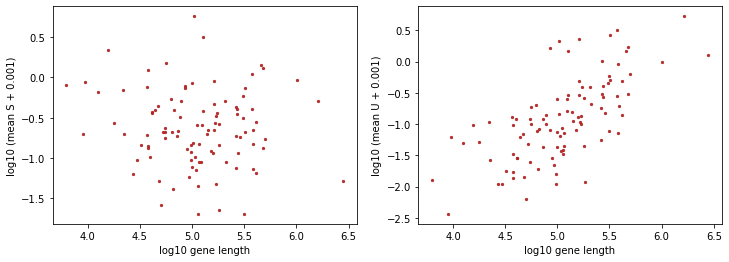

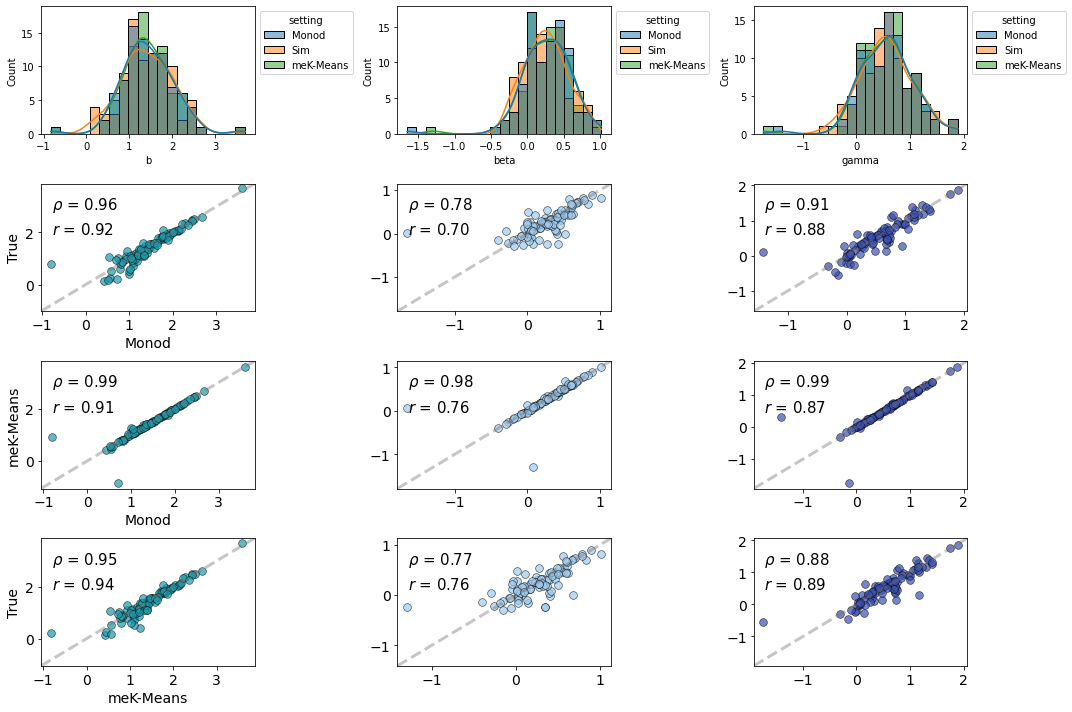

In [294]:
#0,1,7 lowest_b_sim_k3 
search_data = monod.extract_data.extract_data(loom_filepaths[7], transcriptome_filepath, dataset_names[7],
                dataset_strings[7], dir_string, dataset_attr_names=attribute_names,cf=cf[7])
    
plot_params(search_data,all_counts,sr,all_params,grid_point_results,res_inds=[0,1,7],
            clus_inds=[0,0,1],figsize=(15,10))

INFO:root:Beginning data extraction.
INFO:root:Dataset: lowest_b_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/lowest_b_sim_k3/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/lowest_b_sim_k3/raw.sd.
True Param LogL:  -55138.17914472037
Monod Param LogL:  -54986.29498705643
meK-Means Param LogL:  -59472.89240945395


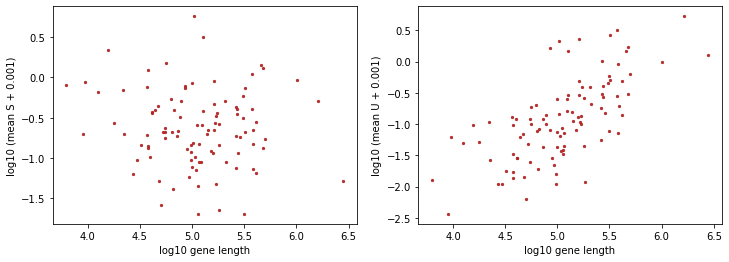

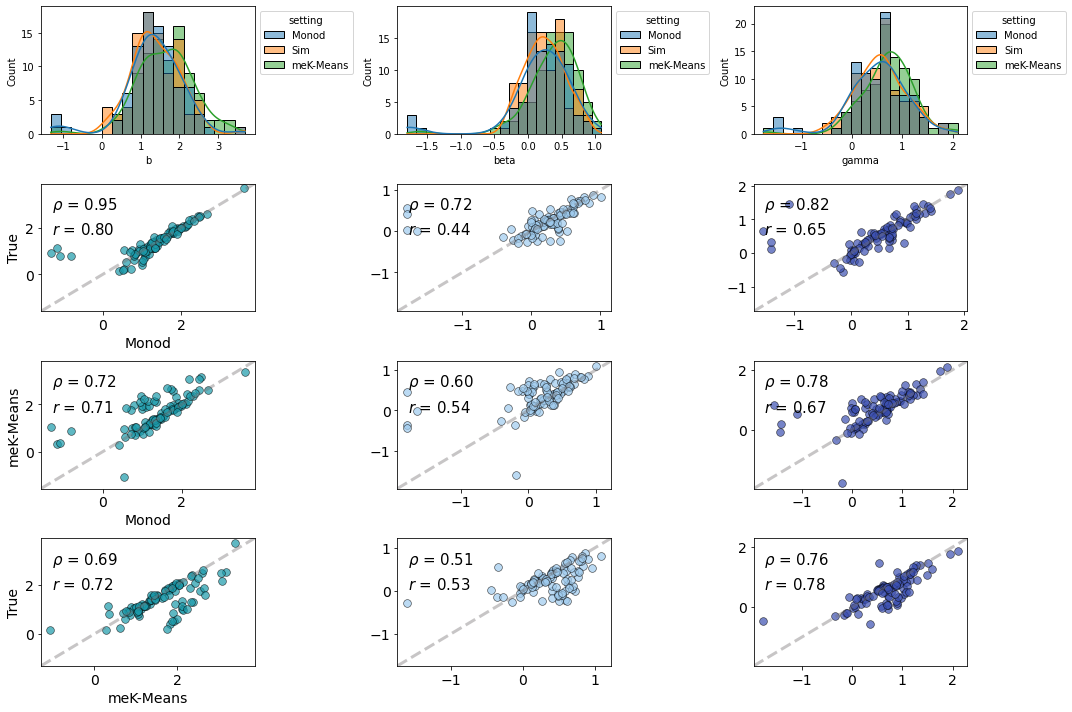

In [295]:
#compare to fits if K=1 for meK-Means
search_data = monod.extract_data.extract_data(loom_filepaths[7], transcriptome_filepath, dataset_names[7],
                dataset_strings[7], dir_string, dataset_attr_names=attribute_names,cf=cf[7])
    
plot_params(search_data,all_counts,sr,all_params,grid_point_results,res_inds=[0,1,5],
            clus_inds=[0,0,0],figsize=(15,10))

In [92]:
dataset_names[17]

'beta90_sim_k3'

INFO:root:Beginning data extraction.
INFO:root:Dataset: beta90_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/beta90_sim_k3/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta90_sim_k3/raw.sd.
True Param LogL:  -53492.40848004077
Monod Param LogL:  -57272.80457805495
meK-Means Param LogL:  -57272.80457805495


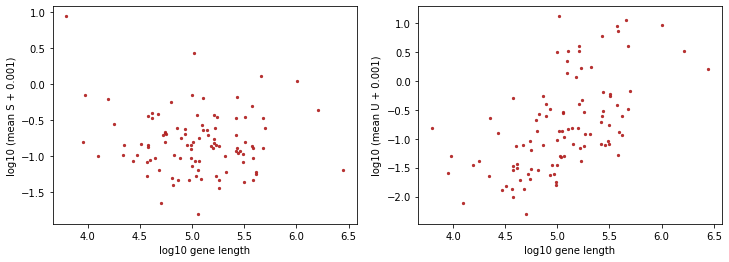

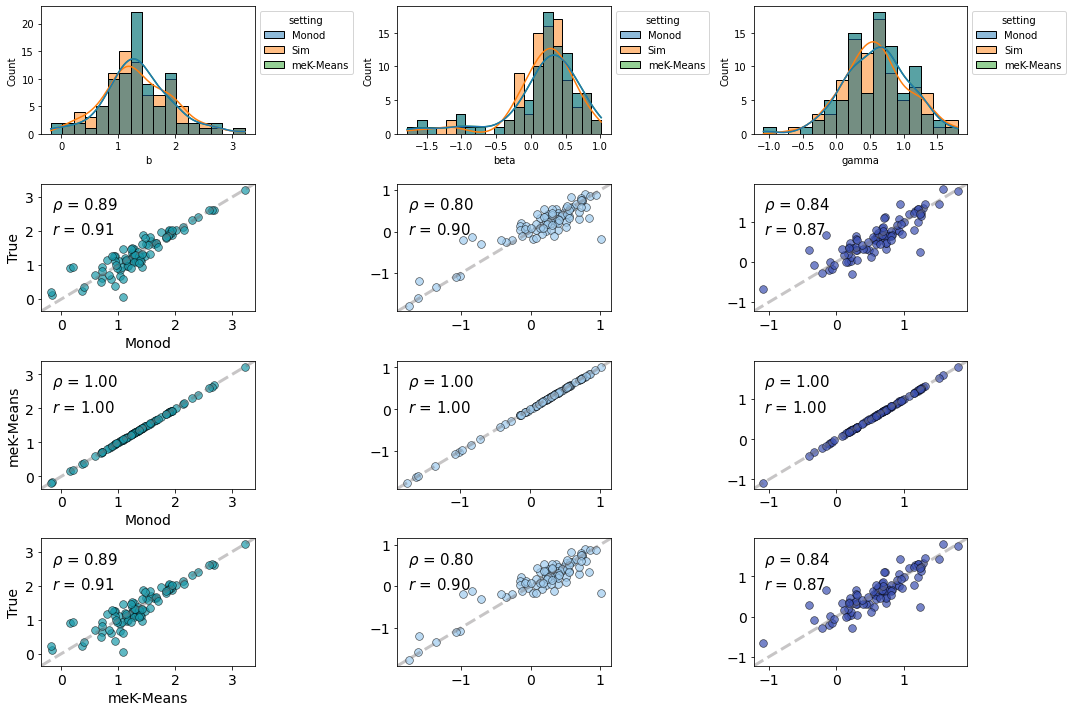

In [296]:
#2,3,17 beta90_sim_k3 simulation/meK-Means fit

search_data = monod.extract_data.extract_data(loom_filepaths[17], transcriptome_filepath, dataset_names[17],
                dataset_strings[17], dir_string, dataset_attr_names=attribute_names,cf=cf[17])
    
plot_params(search_data,all_counts,sr,all_params,grid_point_results,res_inds=[2,3,17],
            clus_inds=[0,0,1],save_fig='beta90_param_fits.pdf',figsize=(15,10))



INFO:root:Beginning data extraction.
INFO:root:Dataset: beta90_sim_k3
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230509_025_simTests_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230509_025_simTests_MM_1/beta90_sim_k3/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230509_025_simTests_MM_1/beta90_sim_k3/raw.sd.
True Param LogL:  -53492.40848004077
Monod Param LogL:  -57272.80457805495
meK-Means Param LogL:  -61914.631223785385


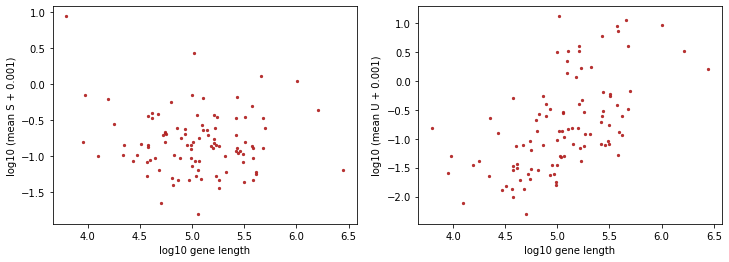

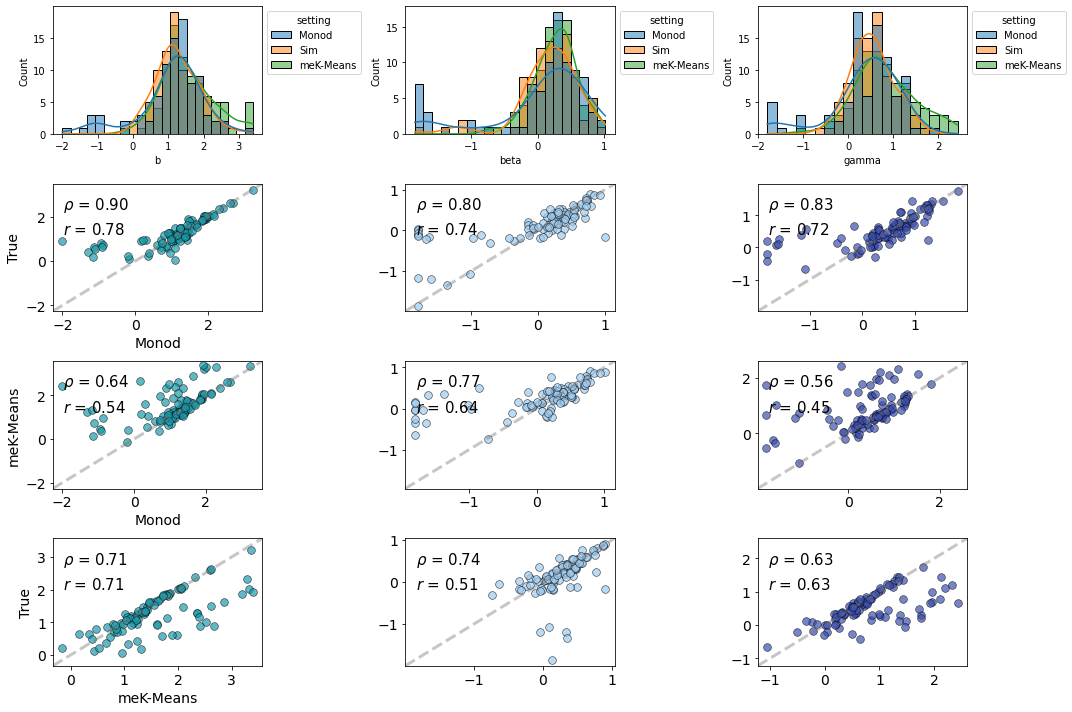

In [297]:
#compare to fits if K=1 for meK-Means
search_data = monod.extract_data.extract_data(loom_filepaths[17], transcriptome_filepath, dataset_names[17],
                dataset_strings[17], dir_string, dataset_attr_names=attribute_names,cf=cf[17])
    
plot_params(search_data,all_counts,sr,all_params,grid_point_results,res_inds=[2,3,15],
            clus_inds=[0,0,0],figsize=(15,10))



**Make plots of (inferred) params for marker genes between the cell states**

For beta90_sim (with k=3 meK-Means results)

In [345]:
print(dataset_names)
len(all_marks)

['single_clus_test_k1', 'single_clus_test_k2', 'single_clus_test_k3', 'single_clus_test_k4', 'single_clus_test_k5', 'lowest_b_sim_k1', 'lowest_b_sim_k2', 'lowest_b_sim_k3', 'lowest_b_sim_k4', 'lowest_b_sim_k5', 'lowest_b_beta_g_sim_k1', 'lowest_b_beta_g_sim_k2', 'lowest_b_beta_g_sim_k3', 'lowest_b_beta_g_sim_k4', 'lowest_b_beta_g_sim_k5', 'beta90_sim_k1', 'beta90_sim_k2', 'beta90_sim_k3', 'beta90_sim_k4', 'beta90_sim_k5', 'lowest_beta90_sim_k1', 'lowest_beta90_sim_k2', 'lowest_beta90_sim_k3', 'lowest_beta90_sim_k4', 'lowest_beta90_sim_k5', 'beta100_sim_k1', 'beta100_sim_k2', 'beta100_sim_k3', 'beta100_sim_k4', 'beta100_sim_k5', 'lowest_beta100_sim_k1', 'lowest_beta100_sim_k2', 'lowest_beta100_sim_k3', 'lowest_beta100_sim_k4', 'lowest_beta100_sim_k5', 'oneClus_lowest_b_sim_k1', 'oneClus_lowest_b_beta_g_sim_k1', 'oneClus_beta90_sim_k1']


7

In [346]:
num_marks

10

          b      beta     gamma         state
0  1.246049 -1.756123  0.622372  Marked State
1  3.222625  0.219144  0.290465  Marked State
2  0.389265 -1.020151  0.255654  Marked State
3  1.132725 -1.365100  0.472261  Marked State
4  0.889016 -1.600068  0.702292  Marked State


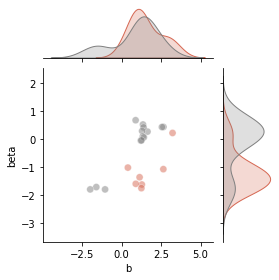

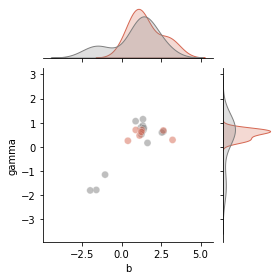

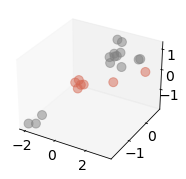

In [400]:

marker_clus = 1
true_clus = 0

allinds = np.array(range(n_genes))
other_inds = [i for i in range(3) if i != marker_clus]

filt = ~check_at_bounds(grid_point_results[17].param_estimates[:,:,marker_clus] ,thr=0.01) 

marks = all_marks[3][true_clus*num_marks:(true_clus*num_marks+num_marks)]
toplot = [i for i in marks if i in list(allinds[filt])]

all_b_beta = pd.DataFrame()
all_b_beta['b'] = list(grid_point_results[17].param_estimates[toplot,0,marker_clus]) + list(grid_point_results[17].param_estimates[toplot,0,:][:,other_inds].flatten())
all_b_beta['beta'] = list(grid_point_results[17].param_estimates[toplot,1,marker_clus]) + list(grid_point_results[17].param_estimates[toplot,1,:][:,other_inds].flatten())
all_b_beta['gamma'] = list(grid_point_results[17].param_estimates[toplot,2,marker_clus]) + list(grid_point_results[17].param_estimates[toplot,2,:][:,other_inds].flatten())
all_b_beta['state'] = ['Marked State']*len(toplot) + ['Other States']*len(toplot)*2


print(all_b_beta.head())


palette={'Marked State':'#d66853','Other States':'grey'}

sns.jointplot(data=all_b_beta.sort_values('state',ascending=False), x="b", y="beta", hue="state",
              alpha=0.5,s=50,height=4,
              ratio=3,palette=palette,legend=False,marginal_kws={'common_norm':False})

plt.savefig('beta90_2d_mark_beta.pdf')

sns.jointplot(data=all_b_beta.sort_values('state',ascending=False), x="b", y="gamma", hue="state",
              alpha=0.5,s=50,height=4,
              ratio=3,palette=palette,legend=False,marginal_kws={'common_norm':False})

plt.savefig('beta90_2d_mark_gamma.pdf')

plt.show()


fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(projection='3d')

all_colors = [palette[i] for i in all_b_beta['state']]
ax.scatter(all_b_beta['b'], all_b_beta['beta'], all_b_beta['gamma'],
           c=all_colors,s=80,alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=14,pad=-3)



ax.grid(None)



plt.savefig('beta90_3d_mark.pdf')


          b      beta     gamma         state
0  0.799741 -1.205276  1.189100  Marked State
1  1.415204 -0.793449  0.928483  Marked State
2  1.963198 -1.035359  0.303616  Marked State
3  1.933469 -0.724746  1.787831  Marked State
4  0.693456 -1.298874  0.299225  Marked State


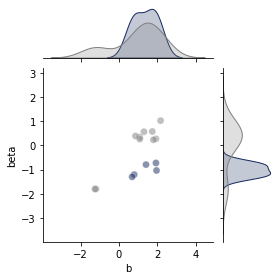

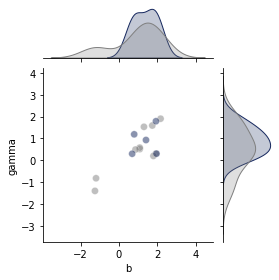

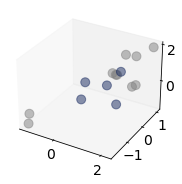

In [399]:

marker_clus = 0 #From meK-Means assignment
true_clus = 1

allinds = np.array(range(n_genes))
other_inds = [i for i in range(3) if i != marker_clus]

filt = ~check_at_bounds(grid_point_results[17].param_estimates[:,:,marker_clus] ,thr=0.01) 

marks = all_marks[3][(true_clus)*num_marks:((true_clus)*num_marks+num_marks)]
toplot = [i for i in marks if i in list(allinds[filt])]

all_b_beta = pd.DataFrame()
all_b_beta['b'] = list(grid_point_results[17].param_estimates[toplot,0,marker_clus]) + list(grid_point_results[17].param_estimates[toplot,0,:][:,other_inds].flatten())
all_b_beta['beta'] = list(grid_point_results[17].param_estimates[toplot,1,marker_clus]) + list(grid_point_results[17].param_estimates[toplot,1,:][:,other_inds].flatten())
all_b_beta['gamma'] = list(grid_point_results[17].param_estimates[toplot,2,marker_clus]) + list(grid_point_results[17].param_estimates[toplot,2,:][:,other_inds].flatten())
all_b_beta['state'] = ['Marked State']*len(toplot) + ['Other States']*len(toplot)*2


print(all_b_beta.head())


palette={'Marked State':'#17295f','Other States':'grey'}


sns.jointplot(data=all_b_beta.sort_values('state',ascending=False), x="b", y="beta", hue="state",
              alpha=0.5,s=50,height=4,
              ratio=3,palette=palette,legend=False,marginal_kws={'common_norm':False})

plt.savefig('beta90_2d_mark2_beta.pdf')

sns.jointplot(data=all_b_beta.sort_values('state',ascending=False), x="b", y="gamma", hue="state",
              alpha=0.5,s=50,height=4,
              ratio=3,palette=palette,legend=False,marginal_kws={'common_norm':False})



plt.savefig('beta90_2d_mark2_gamma.pdf')


fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(projection='3d')

all_colors = [palette[i] for i in all_b_beta['state']]
ax.scatter(all_b_beta['b'], all_b_beta['beta'], all_b_beta['gamma'],
           c=all_colors,s=80,alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=14,pad=-3)

ax.grid(None)
plt.savefig('beta90_3d_mark2.pdf')


          b      beta     gamma    state
0  4.246049 -1.756123  0.622372  State 1
1  6.222625  0.219144  0.290465  State 1
2  3.389265 -1.020151  0.255654  State 1
3  4.132725 -1.365100  0.472261  State 1
4  3.889016 -1.600068  0.702292  State 1


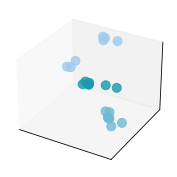

In [408]:
#Make 3D plot for Fig 1 conceptual graphic

marker_clus = 1
true_clus = 0

allinds = np.array(range(n_genes))

filt = ~check_at_bounds(grid_point_results[17].param_estimates[:,:,marker_clus] ,thr=0.01) 

marks = all_marks[3][true_clus*num_marks:(true_clus*num_marks+num_marks)]
toplot = [i for i in marks if i in list(allinds[filt])]

all_b_beta = pd.DataFrame()
all_b_beta['b'] = list(grid_point_results[17].param_estimates[toplot,0,marker_clus]+3) + list(grid_point_results[17].param_estimates[toplot,0,0]) + list(grid_point_results[17].param_estimates[toplot,0,2]+3)
all_b_beta['beta'] = list(grid_point_results[17].param_estimates[toplot,1,marker_clus]) + list(grid_point_results[17].param_estimates[toplot,1,0]+10)+ list(grid_point_results[17].param_estimates[toplot,1,2]+3)
all_b_beta['gamma'] = list(grid_point_results[17].param_estimates[toplot,2,marker_clus]) + list(grid_point_results[17].param_estimates[toplot,2,0]) + list(grid_point_results[17].param_estimates[toplot,2,2]-4)
all_b_beta['state'] = ['State 1']*len(toplot) + ['State 2']*len(toplot) + ['State 3']*len(toplot)


print(all_b_beta.head())


palette={'State 1':col_b,'State 2':col_beta,'State 3':'#6FBBD1'}


fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(projection='3d')

all_colors = [palette[i] for i in all_b_beta['state']]
ax.scatter(all_b_beta['b'], all_b_beta['beta'], all_b_beta['gamma'],
           c=all_colors,s=80,alpha=0.8,)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.grid(None)


plt.savefig('fig1_3d_concept.pdf')



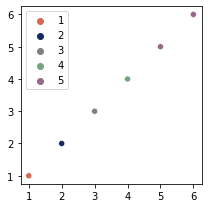

In [420]:
#Make legend with all 3d plot colors for Figs
plt.figure(figsize=(3,3))
sns.scatterplot(x=[1,2,3,4,5,6],y=[1,2,3,4,5,6],hue=[1,2,3,4,5,5],
                palette={1:'#d66853' ,2:'#17295f', 3:'grey', 4:'#73a580' ,5:'#996888' })
plt.tight_layout()
plt.savefig('all_3d_legend_colors.pdf')